# Illustration of POUnets experiments

### The LSGD here can perform the regularization lambda in LS with a decay if stagnation is detected, but set lam_init: float = 0, rho: float = 1.0 in the config, therefore it will not be applied during training. (we use the original LSGD without regularization for illustration)
### For non-seperable POUnets, there are three POU architectures to choose, MLP, RBF and Resnet.
### For seperable POUnets, we can choose Sep-MLP-POUnets or Sep-RBF-POUnets.
### For Sep-POUnets, tau is set to be 1.0 as default (same as the equation in the thesis, larger tau may encourage overlap)
### Only 1D and 2D input are supported with a maximum polynomial degree up to 3

In [ ]:
from __future__ import annotations
import functools
import dataclasses
import pathlib

import jax
from jax import random
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# JAX configuration and setup
jax.config.update("jax_enable_x64", True)
key = jax.random.PRNGKey(42)
SAVE_DIR = pathlib.Path("POUnets_result")
SAVE_DIR.mkdir(exist_ok=True, parents=True)


def glorot(key: jax.random.PRNGKey, shape: tuple[int, int]) -> jnp.ndarray:
    fan_in, fan_out = shape
    lim = jnp.sqrt(6. / (fan_in + fan_out))
    return jax.random.uniform(key, shape, minval=-lim, maxval=lim)

def _design_matrix(x: jnp.ndarray, poly_degree: int) -> jnp.ndarray:
    """
    Builds the Vandermonde design matrix for a polynomial of a given degree.
    """
    d = x.shape[-1]
    if d == 1:
        x1 = x[:, 0]
        if poly_degree == 1:
            return jnp.stack([jnp.ones_like(x1), x1], axis=-1)
        elif poly_degree == 2:
            return jnp.stack([jnp.ones_like(x1), x1, x1**2], axis=-1)
        elif poly_degree == 3:
            return jnp.stack([jnp.ones_like(x1), x1, x1**2, x1**3], axis=-1)
        else:
            raise ValueError("For 1D, poly_degree must be 1, 2, or 3.")
    elif d == 2:
        x1, x2 = x[:, 0], x[:, 1]
        if poly_degree == 1:
            return jnp.stack([jnp.ones_like(x1), x1, x2], axis=-1)
        elif poly_degree == 2:
            return jnp.stack([jnp.ones_like(x1), x1, x2, x1**2, x1*x2, x2**2], axis=-1)
        elif poly_degree == 3:
            return jnp.stack([jnp.ones_like(x1), x1, x2, x1**2, x1*x2, x2**2, x1**3, x1**2*x2, x1*x2**2, x2**3], axis=-1)
        else:
            raise ValueError("For 2D, poly_degree must be 1, 2, or 3.")
    else:
        raise ValueError("Only 1D or 2D inputs are supported.")

def fit_local_polynomials(x: jnp.ndarray, y: jnp.ndarray, w: jnp.ndarray, poly_degree: int, lam: float = 0.0) -> jnp.ndarray:
    A, y_reshaped = _design_matrix(x, poly_degree), y[:, None]
    k = A.shape[-1]
    def _solve(weights: jnp.ndarray) -> jnp.ndarray:
        Aw = A * weights[:, None]
        M = A.T @ Aw
        b = (Aw.T @ y_reshaped).squeeze(-1)
        return jnp.linalg.solve(M + lam * jnp.eye(k), b)
    return jax.vmap(_solve, in_axes=1, out_axes=0)(w)

def _predict_from_coeffs(x: jnp.ndarray, coeffs: jnp.ndarray, partitions: jnp.ndarray, poly_degree: int) -> jnp.ndarray:
    A = _design_matrix(x, poly_degree)
    y_local = A @ coeffs.T
    return jnp.sum(partitions * y_local, axis=1)


class BasePOUNet:
    num_experts: int
    input_dim: int
    def init_params(self): raise NotImplementedError
    def forward(self, params, x): raise NotImplementedError

class MLPPOUNet(BasePOUNet):
    def __init__(self, input_dim: int, num_experts: int, hidden: tuple[int, ...] = (64, 64), key: jax.random.PRNGKey = key):
        self.input_dim, self.num_experts = input_dim, num_experts
        keys = random.split(key, len(hidden) + 1)
        p, in_dim = {}, input_dim
        for i, h in enumerate(hidden):
            p[f"W{i}"] = glorot(keys[i], (in_dim, h))
            p[f"b{i}"] = jnp.zeros((h,))
            in_dim = h
        p["W_out"] = glorot(keys[-1], (in_dim, num_experts))
        p["b_out"] = jnp.zeros((num_experts,))
        self._init_params = p
    def init_params(self): return {k: v.copy() for k, v in self._init_params.items()}
    @staticmethod
    def forward(params, x):
        h, n_layer = x, (len(params) // 2) - 1
        for i in range(n_layer):
            h = jax.nn.relu(h @ params[f"W{i}"] + params[f"b{i}"])
        logits = h @ params["W_out"] + params["b_out"]
        return jax.nn.softmax(logits, axis=-1)

class RBFPOUNet(BasePOUNet):
    def __init__(self, input_dim: int, num_centers: int, key: jax.random.PRNGKey = key):
        self.input_dim, self.num_experts = input_dim, num_centers
        self._init_centers = random.uniform(key, (num_centers, input_dim))
        self._init_widths = 0.25 * jnp.ones((num_centers,))
    def init_params(self): return {"centers": self._init_centers.copy(), "widths": self._init_widths.copy()}
    @staticmethod
    def forward(params, x):
        c, w = params["centers"], params["widths"]
        d2 = jnp.sum((x[:, None, :] - c[None, :, :])**2, axis=-1)
        log_phi = -d2 / (w**2 + 1e-12)
        log_phi_stable = log_phi - jnp.max(log_phi, axis=1, keepdims=True)
        phi = jnp.exp(log_phi_stable)
        return phi / jnp.sum(phi, axis=1, keepdims=True)

def _init_layer_from_tf(rng, input_dim, output_dim, depth, ind, arch):
    k1, k2 = random.split(rng)
    n_hat = random.normal(k1, (input_dim, output_dim))
    n = n_hat / (jnp.linalg.norm(n_hat, axis=1, keepdims=True) + 1e-9)
    if arch == 'plain':
        p_max = jnp.maximum(0., jnp.sign(n))
        p = random.uniform(k2, (input_dim, output_dim))
        maxval = jnp.sum((p_max - p) * n, axis=0) + 1e-9
        k = 1.0 / maxval
    elif arch == 'resnet':
        m = (1.0 + 1.0 / depth) ** ind
        p_max = m * jnp.maximum(0., jnp.sign(n))
        p = random.uniform(k2, (input_dim, output_dim), minval=0, maxval=m)
        maxval = jnp.sum((p_max - p) * n, axis=0) + 1e-9
        k = 1.0 / (depth * maxval)
    W = k * n
    b = -k * jnp.sum(p * n, axis=0)
    return {"W": W, "b": b}

class ResNetPOUNet(BasePOUNet):
    def __init__(self, input_dim, num_partitions, hidden_dim, depth, key=None):
        if key is None: key = random.PRNGKey(0)
        self.input_dim = input_dim
        self.num_experts = num_partitions
        keys = random.split(key, depth + 2)
        self.p_in = _init_layer_from_tf(keys[0], input_dim, hidden_dim, depth=1, ind=1, arch='plain')
        self.p_blocks = []
        for i in range(depth):
            block_params = _init_layer_from_tf(keys[i+1], hidden_dim, hidden_dim, depth=depth, ind=i+1, arch='resnet')
            self.p_blocks.append(block_params)
        self.p_out = _init_layer_from_tf(keys[-1], hidden_dim, num_partitions, depth=1, ind=1, arch='resnet')
    def init_params(self):
        return {
            "p_in": jax.tree_util.tree_map(lambda x: x.copy(), self.p_in),
            "p_blocks": [jax.tree_util.tree_map(lambda x: x.copy(), p) for p in self.p_blocks],
            "p_out": jax.tree_util.tree_map(lambda x: x.copy(), self.p_out)
        }
    @staticmethod
    def forward(params, x):
        h = jax.nn.relu(x @ params['p_in']['W'] + params['p_in']['b'])
        for p_block in params['p_blocks']:
            res = jax.nn.relu(h @ p_block['W'] + p_block['b'])
            h = h + res
        logits = h @ params['p_out']['W'] + params['p_out']['b']
        return jax.nn.softmax(logits, axis=-1)

# Separable POU Networks for 2D 
def _init_mlp_1d(key, hidden, num_outputs):
    keys = random.split(key, len(hidden) + 1)
    params = {}
    in_dim = 1
    for i, h in enumerate(hidden):
        params[f"W{i}"] = glorot(keys[i], (in_dim, h))
        params[f"b{i}"] = jnp.zeros((h,))
        in_dim = h
    params["W_out"] = glorot(keys[-1], (in_dim, num_outputs))
    params["b_out"] = jnp.zeros((num_outputs,))
    return params

def _mlp_forward_1d(params, x):
    h = x
    n_layer = (len(params) // 2) - 1
    for i in range(n_layer):
        h = jax.nn.relu(h @ params[f"W{i}"] + params[f"b{i}"])
    logits = h @ params["W_out"] + params["b_out"]
    return logits

def _rbf_forward_1d(params, x):
    c, w = params["centers"], params["widths"]
    d2 = (x - c)**2
    log_phi = -d2 / (w**2 + 1e-12)
    return log_phi

class SepMLPPOUNet(BasePOUNet):
    def __init__(self, input_dim: int, nx: int, ny: int,
                 hidden: tuple[int, ...] = (32, 32),
                 tau: float = 1.0,
                 key: jax.random.PRNGKey = jax.random.PRNGKey(42)):
        if input_dim != 2: raise ValueError("Separable MLP POU is only defined for 2D inputs.")
        self.input_dim = input_dim
        self.nx, self.ny = int(nx), int(ny)
        self.num_experts = self.nx * self.ny
        self.tau = float(tau)
        kx, ky = jax.random.split(key)
        self.param_x = _init_mlp_1d(kx, hidden, self.nx)
        self.param_y = _init_mlp_1d(ky, hidden, self.ny)
    def init_params(self) -> dict: return {"x": self.param_x, "y": self.param_y}
    def forward(self, params: dict, xy: jnp.ndarray) -> jnp.ndarray:
        xy = jnp.atleast_2d(xy)
        x, y = xy[:, :1], xy[:, 1:]
        z_x = _mlp_forward_1d(params["x"], x)
        z_y = _mlp_forward_1d(params["y"], y)
        logits = (z_x[:, :, jnp.newaxis] + z_y[:, jnp.newaxis, :]) / self.tau
        logits = logits.reshape(xy.shape[0], -1)
        return jax.nn.softmax(logits, axis=1)

class SepRBFPOUNet(BasePOUNet):
    def __init__(self, input_dim: int, nx: int, ny: int,
                 tau: float = 1.0,
                 key: jax.random.PRNGKey = jax.random.PRNGKey(42)):
        if input_dim != 2: raise ValueError("Separable RBF POU is only defined for 2D inputs.")
        self.input_dim = input_dim
        self.nx, self.ny = int(nx), int(ny)
        self.num_experts = self.nx * self.ny
        self.tau = float(tau)
        kx, ky = jax.random.split(key)
        self.param_x = {"centers": random.uniform(kx, (1, self.nx)), "widths": 0.25 * jnp.ones((self.nx,))}
        self.param_y = {"centers": random.uniform(ky, (1, self.ny)), "widths": 0.25 * jnp.ones((self.ny,))}
    def init_params(self) -> dict: return {"x": self.param_x, "y": self.param_y}
    def forward(self, params: dict, xy: jnp.ndarray) -> jnp.ndarray:
        xy = jnp.atleast_2d(xy)
        x, y = xy[:, :1], xy[:, 1:]
        z_x = _rbf_forward_1d(params["x"], x)
        z_y = _rbf_forward_1d(params["y"], y)
        logits = (z_x[:, :, jnp.newaxis] + z_y[:, jnp.newaxis, :]) / self.tau
        logits = logits.reshape(xy.shape[0], -1)
        return jax.nn.softmax(logits, axis=1)

# LSGD Training Algorithm

@dataclasses.dataclass
class LSGDConfig:
    n_epochs: int = 8000
    lr: float = 5e-4
    lam_init: float = 0
    rho: float = 1.0
    n_stag: int = 200
    prints_per_run: int = 10
    viz_interval: int | None = None
    poly_degree: int = 2

def run_lsgd(model: BasePOUNet, params: dict, x: jnp.ndarray, y: jnp.ndarray, cfg: LSGDConfig) -> dict:
    lam = jnp.array(cfg.lam_init)
    best_loss, stagnation_counter = jnp.inf, 0
    log_interval = max(1, cfg.n_epochs // cfg.prints_per_run)
    
    @functools.partial(jax.jit, static_argnums=(3,))
    def loss_fn(p, current_lam, y_data, poly_degree):
        partitions = model.forward(p, x)
        coeffs = fit_local_polynomials(x, y_data, partitions, poly_degree, current_lam)
        pred = _predict_from_coeffs(x, coeffs, partitions, poly_degree)
        return jnp.mean((pred - y_data)**2)

    grad_fn = jax.jit(jax.grad(loss_fn, argnums=0), static_argnums=(3,))

    optimizer = optax.adam(cfg.lr)
    opt_state = optimizer.init(params)
    
    if not hasattr(run_lsgd, 'compiled'):
        print(" First run: JIT compiling the training step...", end="", flush=True)
        grad_fn(params, lam, y, cfg.poly_degree)
        print(" Done!")
        run_lsgd.compiled = True

    for ep in range(cfg.n_epochs):
        grads = grad_fn(params, lam, y, cfg.poly_degree)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        
        if cfg.viz_interval and ep > 0 and ep % cfg.viz_interval == 0:
            display(Markdown(f"**--- Epoch {ep}: Visualizing Partitions ---**"))
            fig = viz_partitions(model, params, x)
            if fig:
                plt.show(fig)
                plt.close(fig)
                
        if ep % log_interval == 0: 
            current_loss = loss_fn(params, lam, y, cfg.poly_degree)
            print(f"  Epoch {ep:6d} | Loss: {current_loss:.6e}")
            if current_loss < best_loss - 1e-12:
                best_loss, stagnation_counter = current_loss, 0
            else:
                stagnation_counter += 1
            if stagnation_counter > cfg.n_stag:
                lam *= cfg.rho; stagnation_counter = 0
                
    return params

def viz_partitions(model: BasePOUNet, params: dict, x: jnp.ndarray):
    partitions = model.forward(params, x)
    dim = x.shape[-1]
    if dim == 1:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        sorted_indices = jnp.argsort(x[:, 0])
        x_sorted, partitions_sorted = x[sorted_indices], partitions[sorted_indices]
        for i in range(model.num_experts):
            ax.plot(x_sorted[:, 0], partitions_sorted[:, i], linewidth=4)
        ax.grid(True)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        for spine in ax.spines.values():
            spine.set_linewidth(3.5)
        ax.tick_params(width=3.5, labelsize=20)
    elif dim == 2:
        grid_size = int(jnp.sqrt(x.shape[0]))
        n_cols = int(jnp.ceil(jnp.sqrt(model.num_experts)))
        n_rows = int(jnp.ceil(model.num_experts / n_cols))
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.5 * n_cols, 2.5 * n_rows), squeeze=False)
        axes = axes.flatten()
        for i in range(model.num_experts):
            ax = axes[i]
            zz = partitions[:, i].reshape(grid_size, grid_size)
            im = ax.imshow(zz, cmap='viridis', extent=[0, 1, 0, 1], origin='lower', vmin=0, vmax=1)
            ax.set_xticks([])
            ax.set_yticks([])
            cbar = fig.colorbar(im, ax=ax, shrink=0.8)
            for label in cbar.ax.get_yticklabels():
                label.set_fontweight('bold')
                label.set_fontsize(14)
        for i in range(model.num_experts, len(axes)):
            axes[i].axis('off')
    else:
        return None
    return fig

def viz_final(model: BasePOUNet, params: dict, x: jnp.ndarray, y: jnp.ndarray, poly_degree: int):
    partitions = model.forward(params, x)
    coeffs = fit_local_polynomials(x, y, partitions, poly_degree)
    y_pred = _predict_from_coeffs(x, coeffs, partitions, poly_degree)
    dim = x.shape[-1]
    
    relative_l2_error = jnp.linalg.norm(y - y_pred) / (jnp.linalg.norm(y) + 1e-9)

    if dim == 1:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        sorted_indices = jnp.argsort(x[:, 0])
        ax.plot(x[sorted_indices, 0], y[sorted_indices], 'k-', label='Ground Truth', linewidth=4, zorder=1)
        ax.plot(x[sorted_indices, 0], y_pred[sorted_indices], 'r--', label='POUnets Approximation', linewidth=4.5, zorder=2)
        
        ax.set_title(f'Final Approximation (Rel L2 Err: {relative_l2_error:.4f})', fontsize=20, fontweight='bold')
        
        ax.legend(fontsize=18); ax.grid(True)
        ax.set_xlim(0, 1)
        ax.set_ylim(-1.1, 1.1)
        for spine in ax.spines.values():
            spine.set_linewidth(3.5)
        ax.tick_params(width=3.5, labelsize=20)
    else: # 2D
        grid_size = int(jnp.sqrt(x.shape[0]))
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
        
        vmin = min(jnp.min(y), jnp.min(y_pred))
        vmax = max(jnp.max(y), jnp.max(y_pred))

        im1 = ax1.imshow(y.reshape(grid_size, grid_size), cmap='viridis', extent=[0, 1, 0, 1], origin='lower', vmin=vmin, vmax=vmax)
        ax1.set_title("Ground Truth", fontsize=20, fontweight='bold')
        ax1.set_xticks([]); ax1.set_yticks([])
        cbar1 = fig.colorbar(im1, ax=ax1, shrink=0.8)
        for label in cbar1.ax.get_yticklabels():
            label.set_fontweight('bold')
            label.set_fontsize(14)

        im2 = ax2.imshow(y_pred.reshape(grid_size, grid_size), cmap='viridis', extent=[0, 1, 0, 1], origin='lower', vmin=vmin, vmax=vmax)
        ax2.set_title("POUnets Approximation", fontsize=20, fontweight='bold')
        ax2.set_xticks([]); ax2.set_yticks([])
        cbar2 = fig.colorbar(im2, ax=ax2, shrink=0.8)
        for label in cbar2.ax.get_yticklabels():
            label.set_fontweight('bold')
            label.set_fontsize(14)
        
        #pointwise_error = (y - y_pred)**2
        difference = y - y_pred
        im3 = ax3.imshow(difference.reshape(grid_size, grid_size), cmap='magma', extent=[0, 1, 0, 1], origin='lower')
        ax3.set_title(f"Difference (Rel L2: {relative_l2_error:.4f})", fontsize=16, fontweight='bold')
        ax3.set_xticks([]); ax3.set_yticks([])
        cbar3 = fig.colorbar(im3, ax=ax3, shrink=0.8)
        for label in cbar3.ax.get_yticklabels():
            label.set_fontweight('bold')
            label.set_fontsize(14)
        
    return fig

def _tri_func_1d(x: jnp.ndarray, p: int) -> jnp.ndarray:
    x1 = x[..., 0]
    return 4 * jnp.abs(p * x1 - jnp.floor(p * x1 + 0.5)) - 1.0

def _sin_func_1d(x: jnp.ndarray, k: int) -> jnp.ndarray:
    x1 = x[..., 0]
    return jnp.sin(2 * jnp.pi * k * x1)

def _sinsin_func_2d(x: jnp.ndarray) -> jnp.ndarray:
    x1, x2 = x[..., 0], x[..., 1]
    return jnp.sin(2 * jnp.pi * x1) * jnp.sin(2 * jnp.pi * x2)

def _sinsq_func_2d(x: jnp.ndarray) -> jnp.ndarray:
    x1, x2 = x[..., 0], x[..., 1]
    return jnp.sin(10 * jnp.pi * x1**2) * jnp.sin(10 * jnp.pi * x2**2)



### 3 different POU architectures

### 1D RBF Experiment (p=4, degree=1)

**--- Initial Partitions (Epoch 0) ---**

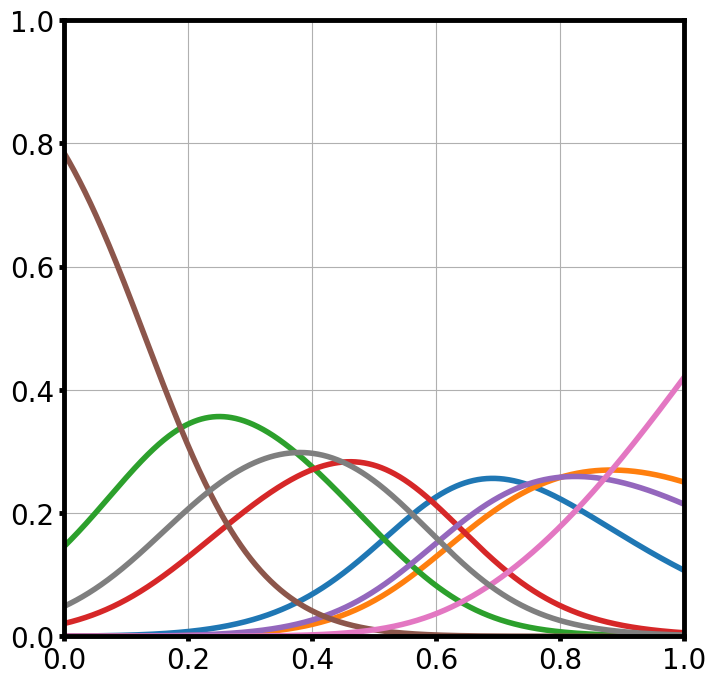

⏳ First run: JIT compiling the training step... Done!
  Epoch      0 | Loss: 3.301557e-01


**--- Epoch 1000: Visualizing Partitions ---**

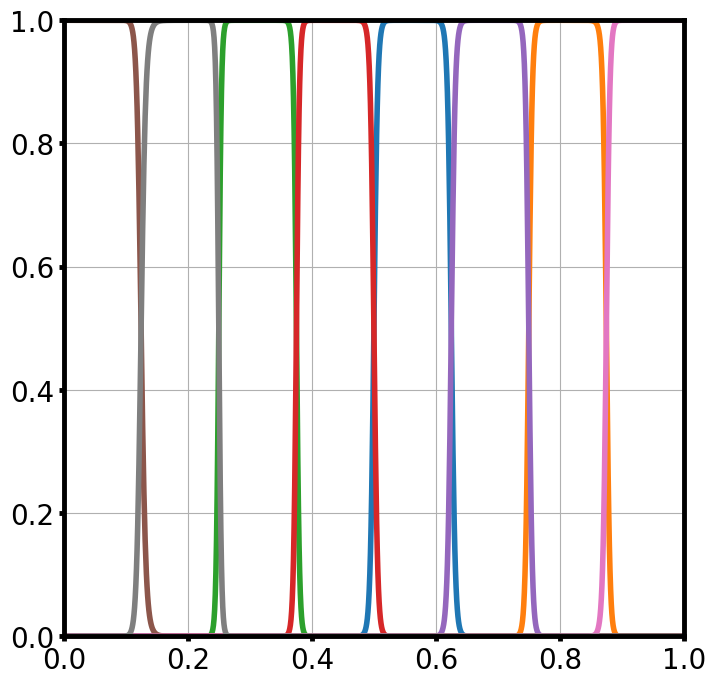

  Epoch   1000 | Loss: 3.226285e-05


**--- Epoch 2000: Visualizing Partitions ---**

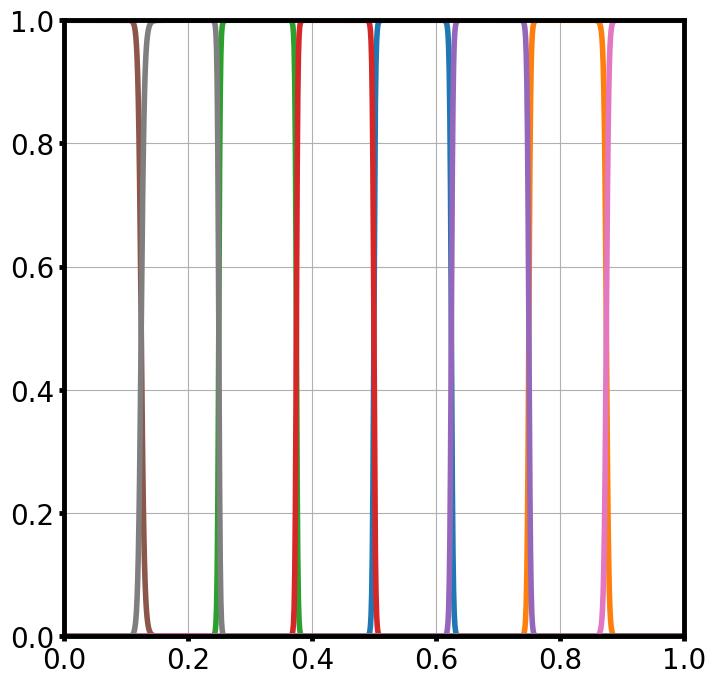

  Epoch   2000 | Loss: 8.377950e-06


**--- Epoch 3000: Visualizing Partitions ---**

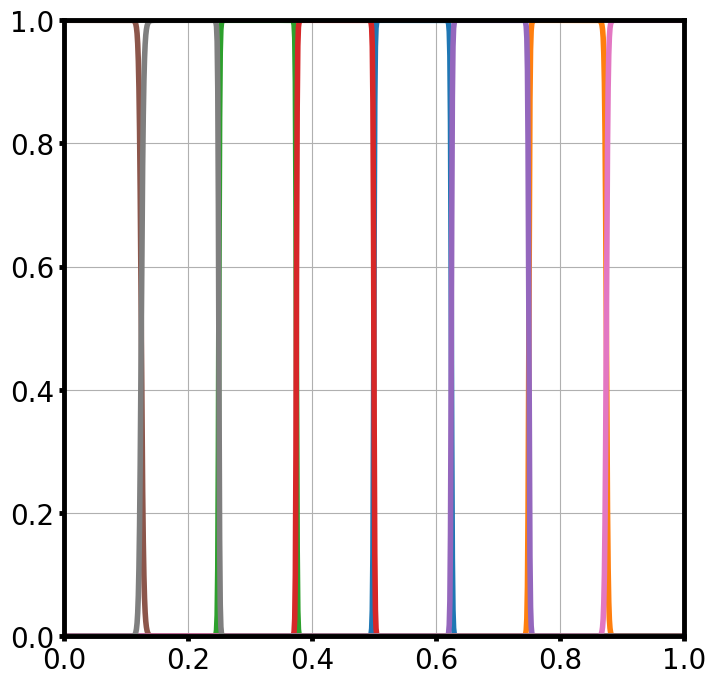

  Epoch   3000 | Loss: 3.075577e-06


**--- Epoch 4000: Visualizing Partitions ---**

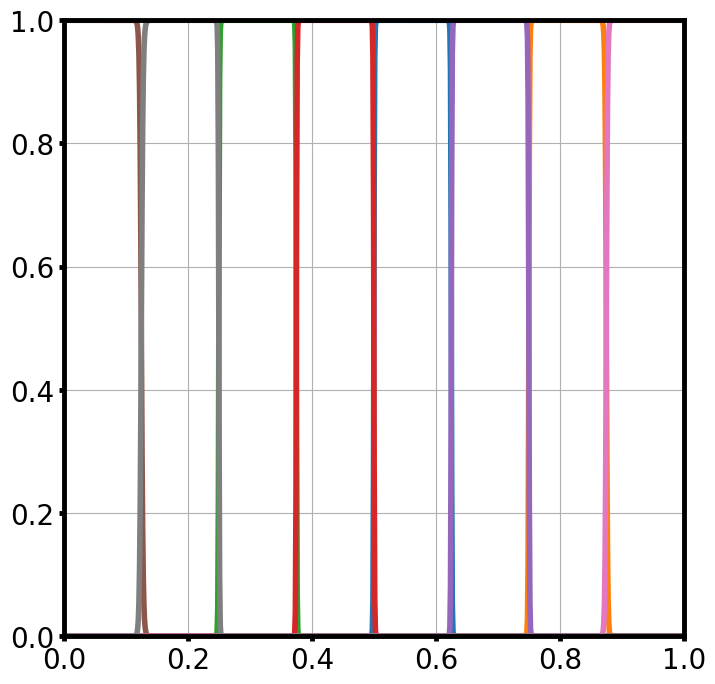

  Epoch   4000 | Loss: 1.306136e-06


**--- Epoch 5000: Visualizing Partitions ---**

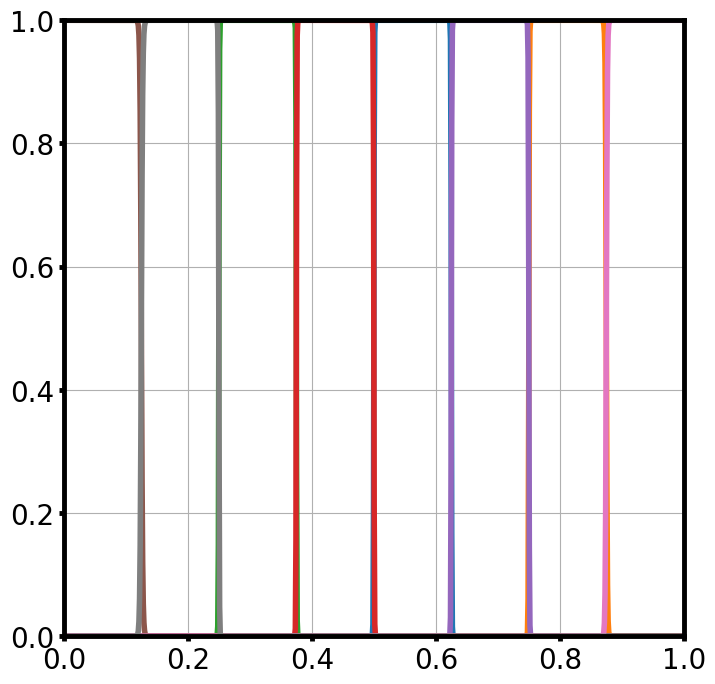

  Epoch   5000 | Loss: 5.908616e-07


**--- Epoch 6000: Visualizing Partitions ---**

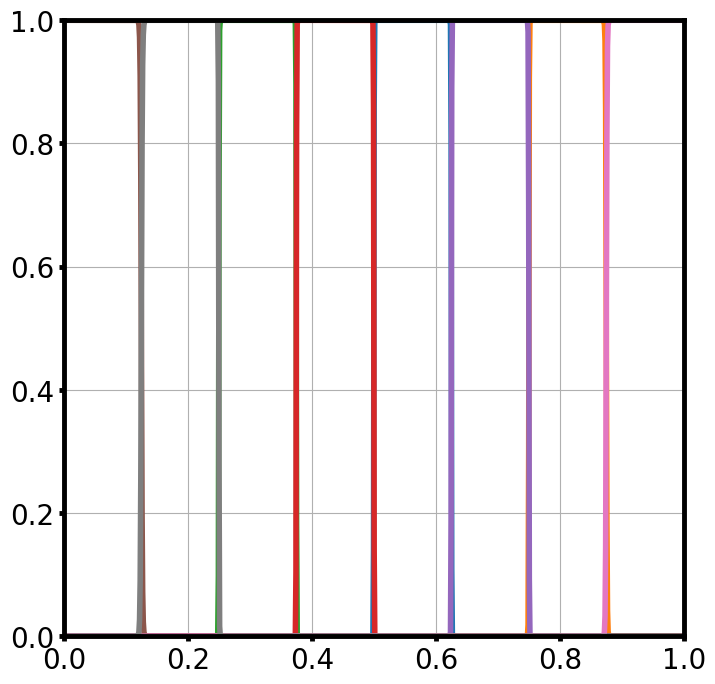

  Epoch   6000 | Loss: 2.655970e-07


**--- Epoch 7000: Visualizing Partitions ---**

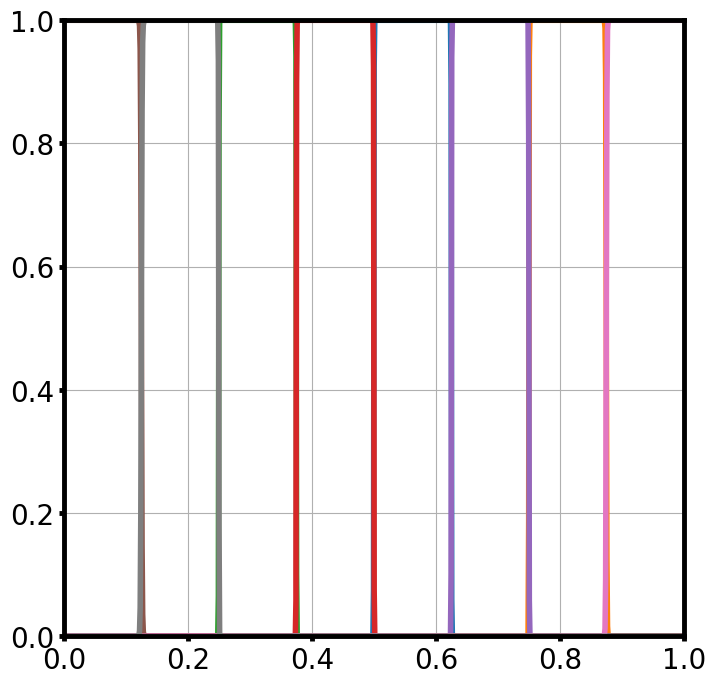

  Epoch   7000 | Loss: 1.115641e-07


**--- Epoch 8000: Visualizing Partitions ---**

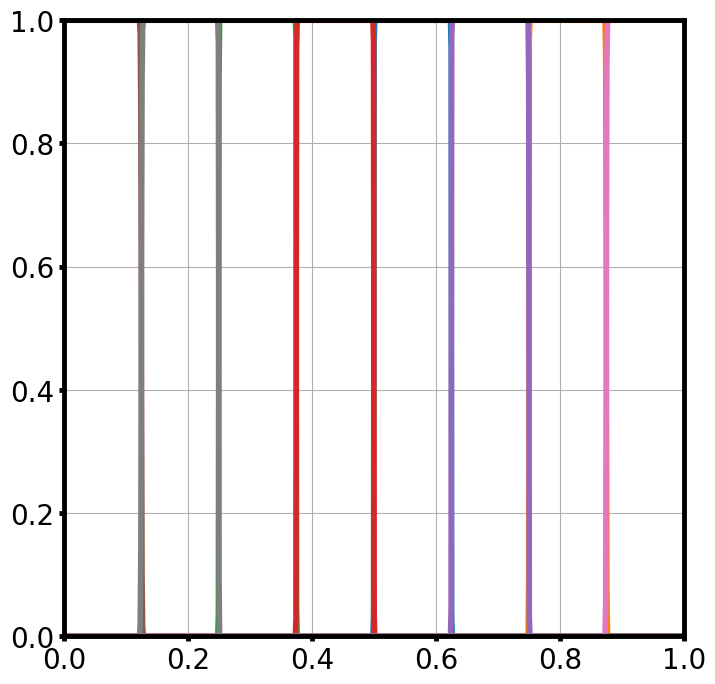

  Epoch   8000 | Loss: 4.495028e-08


**--- Epoch 9000: Visualizing Partitions ---**

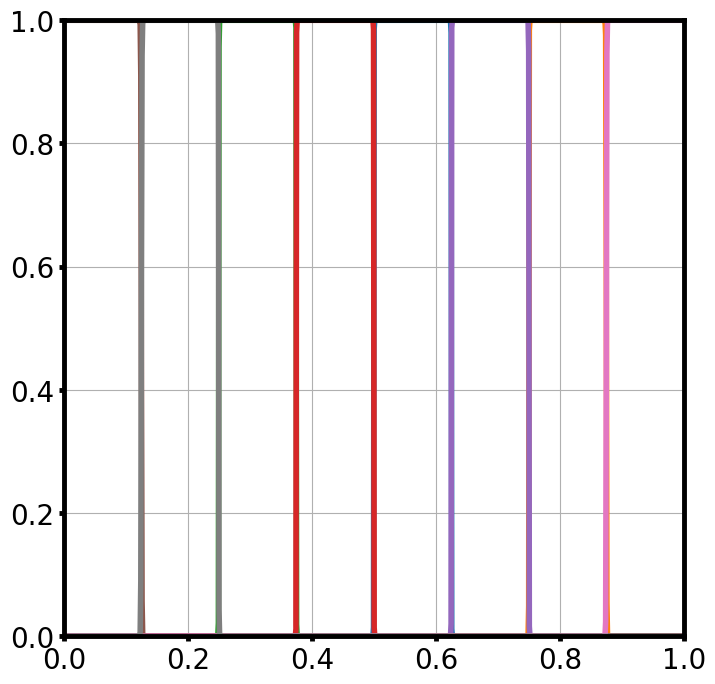

  Epoch   9000 | Loss: 1.903992e-08


**--- Final Result for p=4 ---**

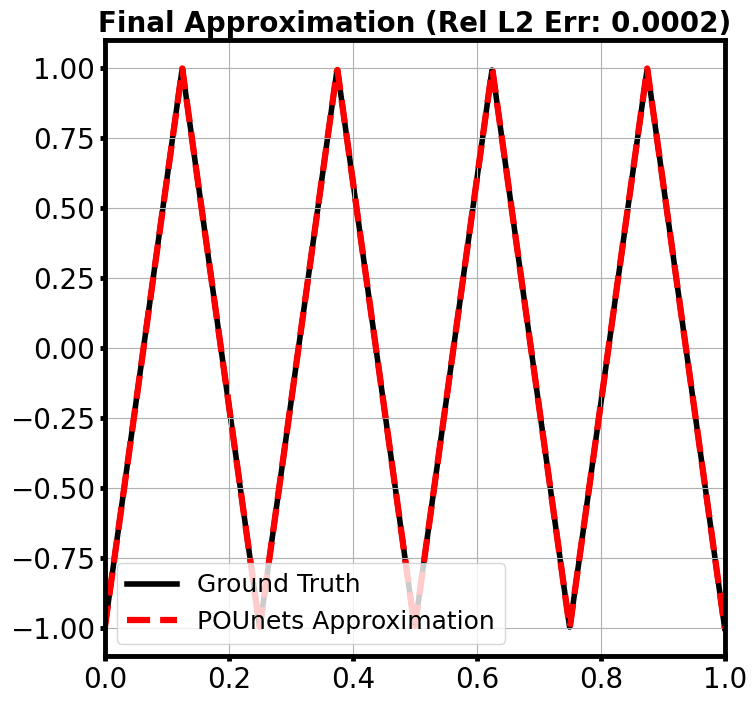

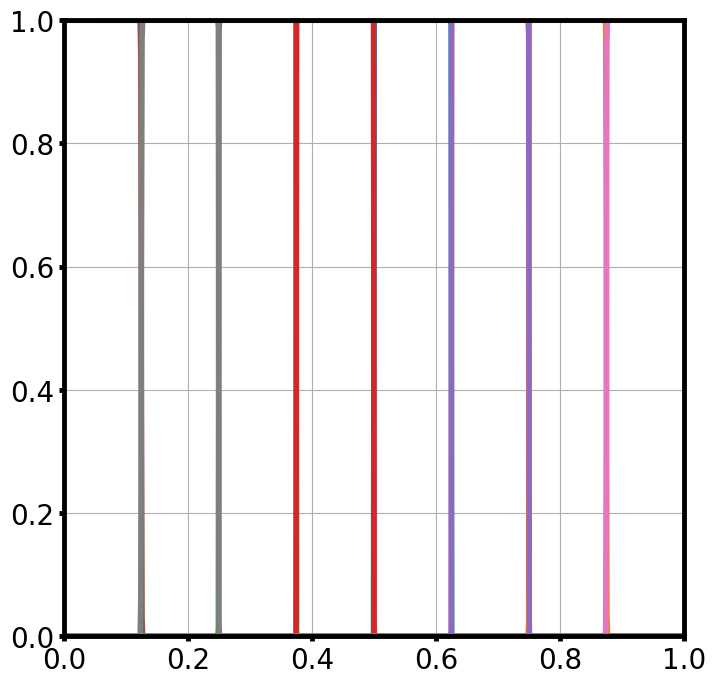

In [ ]:
NET_TAG = "rbf"
DIM = 1
EPOCHS = 10000
N_EXPERTS = 8
P_VALUE = 4
VIZ_INTERVAL = 1000
POLY_DEGREE = 1 
LEARNING_RATE = 1e-3

LAM_INIT = 0 # no regularization
RHO = 1.0
N_STAG = 100
key = jax.random.PRNGKey(2)
# --- Run Experiment ---
display(Markdown(f'### 1D {NET_TAG.upper()} Experiment (p={P_VALUE}, degree={POLY_DEGREE})'))

#  Data and Model Setup
x_train = jnp.linspace(0, 1, 1000)[:, None]
y_train = _tri_func_1d(x_train, p=P_VALUE)
net = RBFPOUNet(input_dim=DIM, num_centers=N_EXPERTS, key=key)
params = net.init_params()

# Initial Visualization
display(Markdown(f"**--- Initial Partitions (Epoch 0) ---**"))
fig_initial = viz_partitions(net, params, x_train)
if fig_initial:
    fig_initial.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_p{P_VALUE}_{N_EXPERTS}exp_initial_partitions.png")
    plt.show(fig_initial)

# Training
lsgd_cfg = LSGDConfig(n_epochs=EPOCHS, viz_interval=VIZ_INTERVAL, lr=LEARNING_RATE, 
                      lam_init=LAM_INIT, rho=RHO, n_stag=N_STAG, poly_degree=POLY_DEGREE)
final_params = run_lsgd(net, params, x_train, y_train, lsgd_cfg)

# Vis
display(Markdown(f"**--- Final Result for p={P_VALUE} ---**"))

fig_approx = viz_final(net, final_params, x_train, y_train, POLY_DEGREE)
if fig_approx:
    fig_approx.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_p{P_VALUE}_{N_EXPERTS}exp_final_approx.png")
    plt.show(fig_approx)
    
fig_part = viz_partitions(net, final_params, x_train)
if fig_part:
    fig_part.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_p{P_VALUE}_{N_EXPERTS}exp_final_partitions.png")
    plt.show(fig_part)

In [ ]:
"""
MLP-POUnet 
  depth  ∈ {2,4,8}
  width  ∈ {2,4,8,16,32}
  seeds  = 3
  metrics   = Relative L2 error
"""
import io, contextlib, itertools, jax, jax.numpy as jnp
DIM, EPOCHS = 1, 3000
P_VALUE, N_EXPERTS = 3, 6
POLY_DEGREE = 1

LR, LAM_INIT, RHO = 1e-3, 0.0, 1.0
N_STAG = 1000

DEPTHS  = [2, 4, 8]
WIDTHS  = [8, 16, 32]

def relative_l2(pred, truth) -> float:
    return float(jnp.linalg.norm(pred - truth) /
                 (jnp.linalg.norm(truth) + 1e-12))

def run_once(depth, width, seed):
    x = jnp.linspace(0., 1., 1000)[:, None]
    y = _tri_func_1d(x, p=P_VALUE)
    # pou
    net = MLPPOUNet(
        input_dim=DIM, num_experts=N_EXPERTS,
        hidden=(width,) * depth,
        key=jax.random.PRNGKey(seed)
    )
    params = net.init_params()
    # training
    cfg = LSGDConfig(
        n_epochs       = EPOCHS,
        lr             = LR,
        lam_init       = LAM_INIT,
        rho            = RHO,
        n_stag         = N_STAG,
        viz_interval   = None,
        prints_per_run = 10,
        poly_degree    = POLY_DEGREE,
    )
    with contextlib.redirect_stdout(io.StringIO()):
        params = run_lsgd(net, params, x, y, cfg)
    # prediction
    part   = net.forward(params, x)
    coeffs = fit_local_polynomials(x, y, part, POLY_DEGREE, lam=0.0)
    y_hat  = _predict_from_coeffs(x, coeffs, part, POLY_DEGREE)
    return relative_l2(y_hat, y)

for depth, width in itertools.product(DEPTHS, WIDTHS):
    errs = [run_once(depth, width, seed) for seed in range(3)]
    for seed, err in enumerate(errs):
        print(f"depth={depth:2d}, width={width:2d}, key={seed} → Rel L2 = {err:.6e}")
    errs_arr = jnp.array(errs)
    mean, std = float(jnp.mean(errs_arr)), float(jnp.std(errs_arr))
    print(f"depth={depth:2d}, width={width:2d} → mean={mean:.6e}, std={std:.6e}\n")


depth= 2, width= 8, key=0 → Rel L2 = 7.604057e-01
depth= 2, width= 8, key=1 → Rel L2 = 6.466261e-01
depth= 2, width= 8, key=2 → Rel L2 = 7.509404e-01
depth= 2, width= 8 → mean=7.193241e-01, std=5.155026e-02

depth= 2, width=16, key=0 → Rel L2 = 7.508974e-01
depth= 2, width=16, key=1 → Rel L2 = 6.415801e-01
depth= 2, width=16, key=2 → Rel L2 = 7.508016e-01
depth= 2, width=16 → mean=7.144264e-01, std=5.151011e-02

depth= 2, width=32, key=0 → Rel L2 = 6.423847e-01
depth= 2, width=32, key=1 → Rel L2 = 7.508064e-01
depth= 2, width=32, key=2 → Rel L2 = 7.507936e-01
depth= 2, width=32 → mean=7.146615e-01, std=5.110747e-02

depth= 4, width= 8, key=0 → Rel L2 = 8.545352e-01
depth= 4, width= 8, key=1 → Rel L2 = 6.423377e-01
depth= 4, width= 8, key=2 → Rel L2 = 6.422587e-01
depth= 4, width= 8 → mean=7.130439e-01, std=1.000495e-01

depth= 4, width=16, key=0 → Rel L2 = 6.422333e-01
depth= 4, width=16, key=1 → Rel L2 = 6.371658e-01
depth= 4, width=16, key=2 → Rel L2 = 6.423569e-01
depth= 4, width=16

In [159]:
"""
MLP-POUnet 网格测试（仅打印结果）
  depth  ∈ {2,4,8}
  width  ∈ {2,4,8,16,32}
  seeds  = 3
  指标   = Relative L2 error
"""
import io, contextlib, itertools, jax, jax.numpy as jnp

# ---- 复用你已有的工具 ----
# _tri_func_1d, MLPPOUNet, LSGDConfig, run_lsgd,
# fit_local_polynomials, _predict_from_coeffs

# --------- 固定超参 ----------
DIM, EPOCHS = 1, 5000
P_VALUE, N_EXPERTS = 3, 6
POLY_DEGREE = 1

LR, LAM_INIT, RHO = 1e-3, 0.0, 1.0
N_STAG = 1000

DEPTHS  = [2, 4, 8]
WIDTHS  = [8, 16, 32, 64]

def relative_l2(pred, truth) -> float:
    return float(jnp.linalg.norm(pred - truth) /
                 (jnp.linalg.norm(truth) + 1e-12))

def run_once(depth, width, seed):
    # 数据
    x = jnp.linspace(0., 1., 1000)[:, None]
    y = _tri_func_1d(x, p=P_VALUE)
    # 网络
    net = MLPPOUNet(
        input_dim=DIM, num_experts=N_EXPERTS,
        hidden=(width,) * depth,
        key=jax.random.PRNGKey(seed)
    )
    params = net.init_params()
    # 训练（静默）
    cfg = LSGDConfig(
        n_epochs       = EPOCHS,
        lr             = LR,
        lam_init       = LAM_INIT,
        rho            = RHO,
        n_stag         = N_STAG,
        viz_interval   = None,
        prints_per_run = 10,
        poly_degree    = POLY_DEGREE,
    )
    with contextlib.redirect_stdout(io.StringIO()):
        params = run_lsgd(net, params, x, y, cfg)
    # 预测 & 误差
    part   = net.forward(params, x)
    coeffs = fit_local_polynomials(x, y, part, POLY_DEGREE, lam=0.0)
    y_hat  = _predict_from_coeffs(x, coeffs, part, POLY_DEGREE)
    return relative_l2(y_hat, y)

# ------------- 主循环 -------------
for depth, width in itertools.product(DEPTHS, WIDTHS):
    errs = [run_once(depth, width, seed) for seed in range(3)]
    for seed, err in enumerate(errs):
        print(f"depth={depth:2d}, width={width:2d}, key={seed} → Rel L2 = {err:.6e}")
    errs_arr = jnp.array(errs)
    mean, std = float(jnp.mean(errs_arr)), float(jnp.std(errs_arr))
    print(f"depth={depth:2d}, width={width:2d} → mean={mean:.6e}, std={std:.6e}\n")


depth= 2, width= 8, key=0 → Rel L2 = 7.513351e-01
depth= 2, width= 8, key=1 → Rel L2 = 6.424110e-01
depth= 2, width= 8, key=2 → Rel L2 = 7.507997e-01
depth= 2, width= 8 → mean=7.148486e-01, std=5.122160e-02

depth= 2, width=16, key=0 → Rel L2 = 7.508053e-01
depth= 2, width=16, key=1 → Rel L2 = 6.372657e-01
depth= 2, width=16, key=2 → Rel L2 = 7.507929e-01
depth= 2, width=16 → mean=7.129547e-01, std=5.352018e-02

depth= 2, width=32, key=0 → Rel L2 = 6.422944e-01
depth= 2, width=32, key=1 → Rel L2 = 7.507935e-01
depth= 2, width=32, key=2 → Rel L2 = 7.507871e-01
depth= 2, width=32 → mean=7.146250e-01, std=5.114545e-02

depth= 2, width=64, key=0 → Rel L2 = 6.372509e-01
depth= 2, width=64, key=1 → Rel L2 = 6.372666e-01
depth= 2, width=64, key=2 → Rel L2 = 6.423002e-01
depth= 2, width=64 → mean=6.389392e-01, std=2.376545e-03

depth= 4, width= 8, key=0 → Rel L2 = 7.505732e-01
depth= 4, width= 8, key=1 → Rel L2 = 6.422794e-01
depth= 4, width= 8, key=2 → Rel L2 = 6.372476e-01
depth= 4, width= 8

### 1D MLP Experiment (p=4, degree=1)

**--- Initial Partitions (Epoch 0) ---**

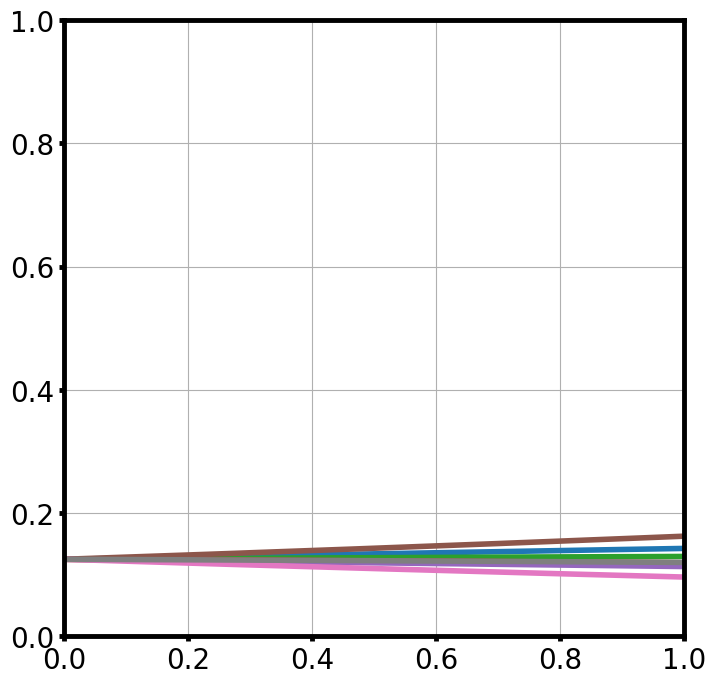

  Epoch      0 | Loss: 3.339955e-01


**--- Epoch 500: Visualizing Partitions ---**

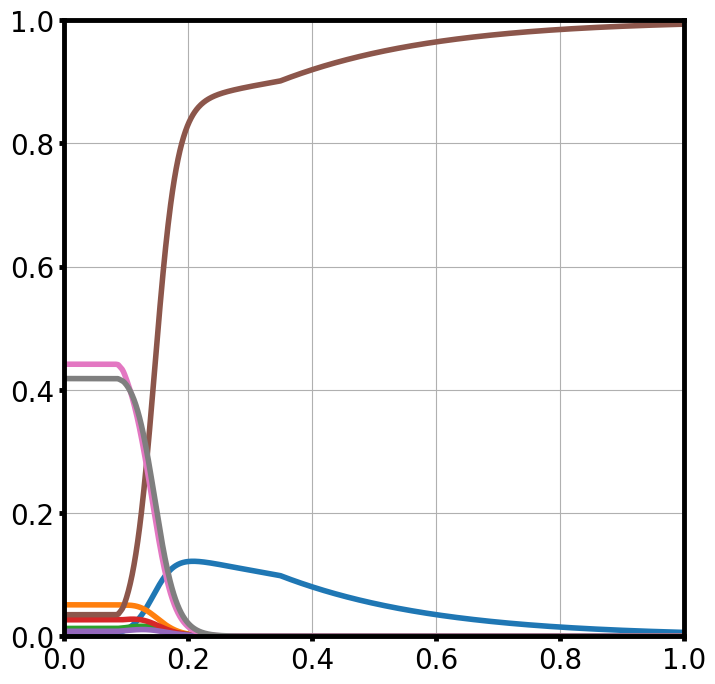

**--- Epoch 1000: Visualizing Partitions ---**

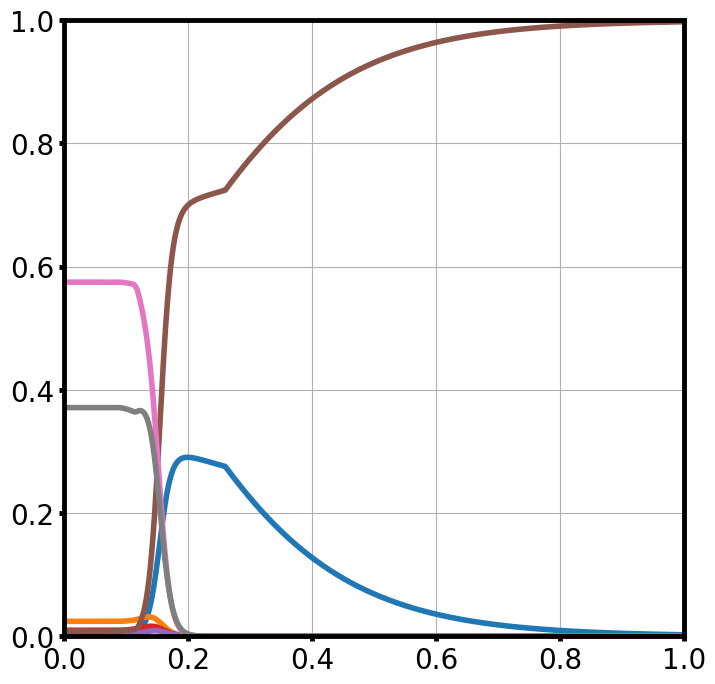

  Epoch   1000 | Loss: 2.716387e-01


**--- Epoch 1500: Visualizing Partitions ---**

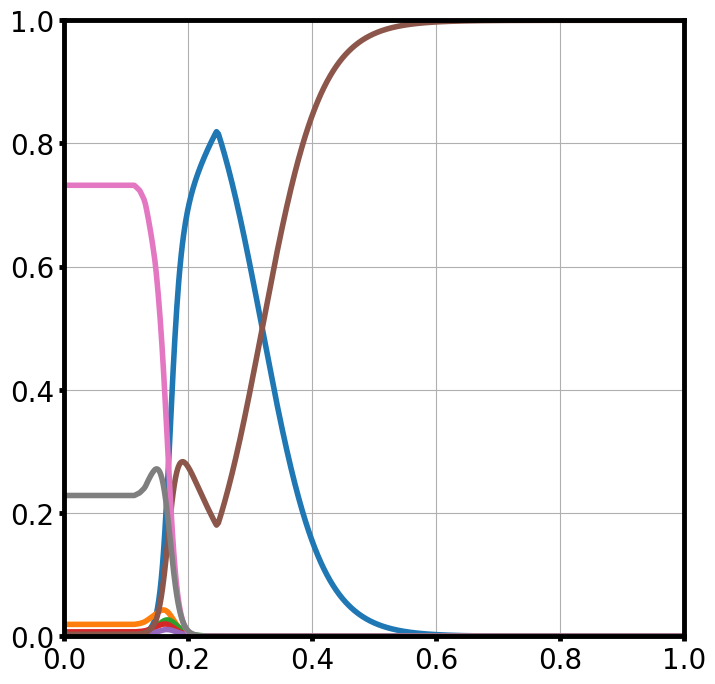

**--- Epoch 2000: Visualizing Partitions ---**

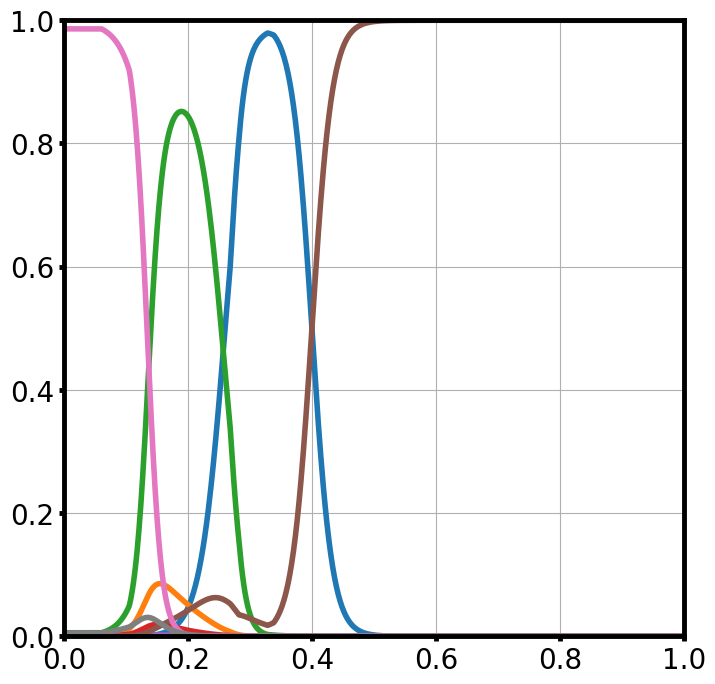

  Epoch   2000 | Loss: 2.006088e-01


**--- Epoch 2500: Visualizing Partitions ---**

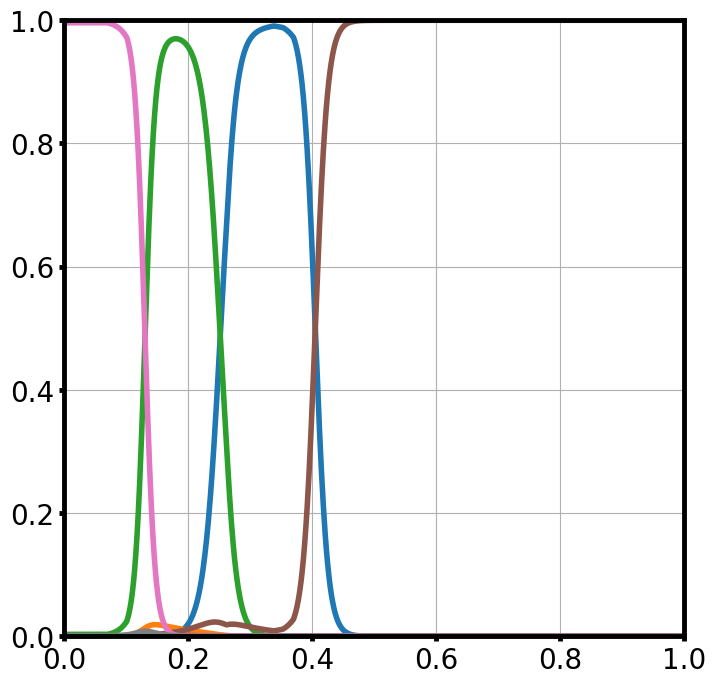

**--- Epoch 3000: Visualizing Partitions ---**

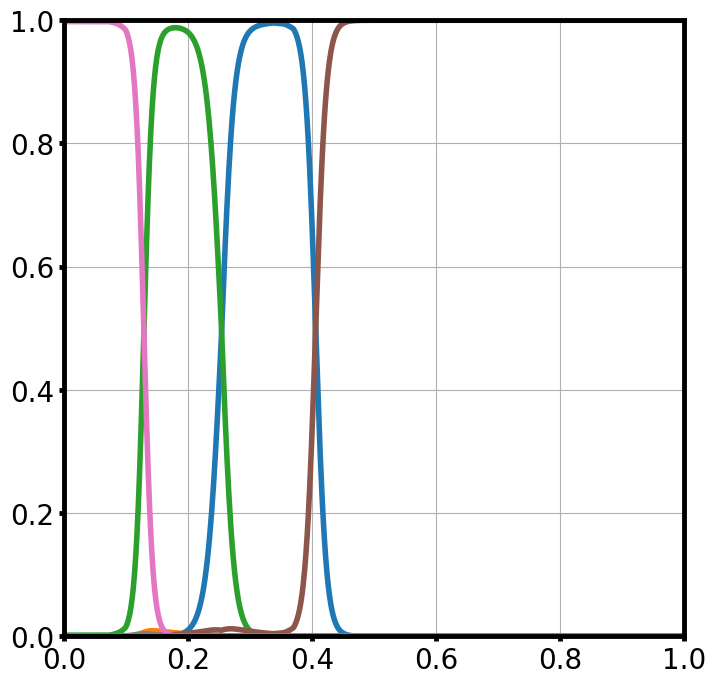

  Epoch   3000 | Loss: 1.886167e-01


**--- Epoch 3500: Visualizing Partitions ---**

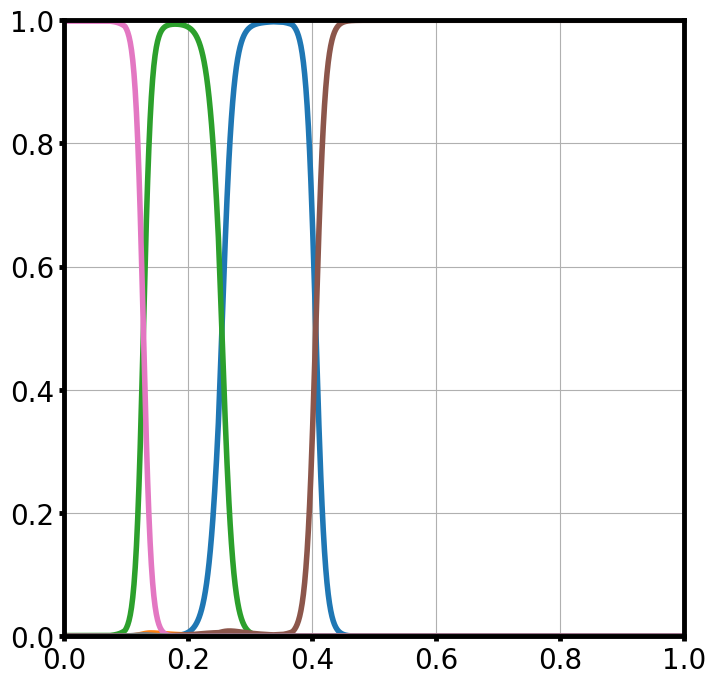

**--- Epoch 4000: Visualizing Partitions ---**

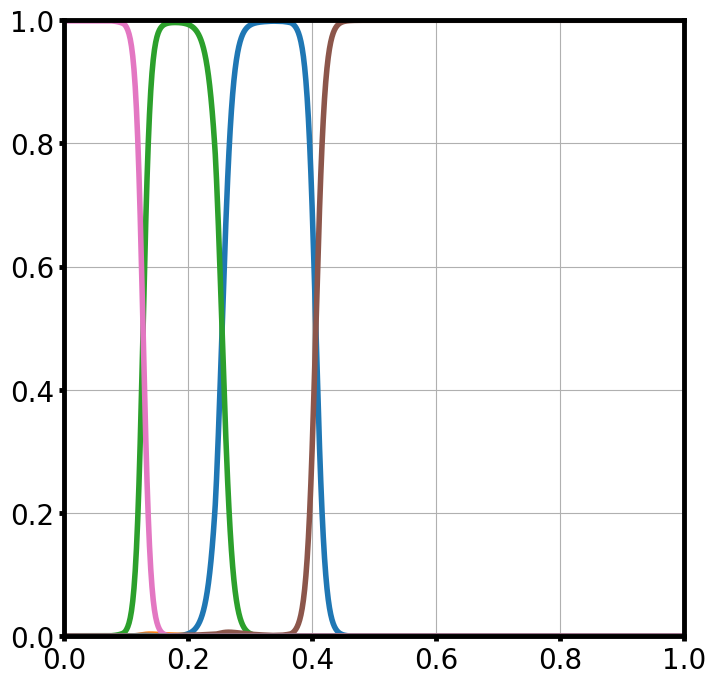

  Epoch   4000 | Loss: 1.879319e-01


**--- Epoch 4500: Visualizing Partitions ---**

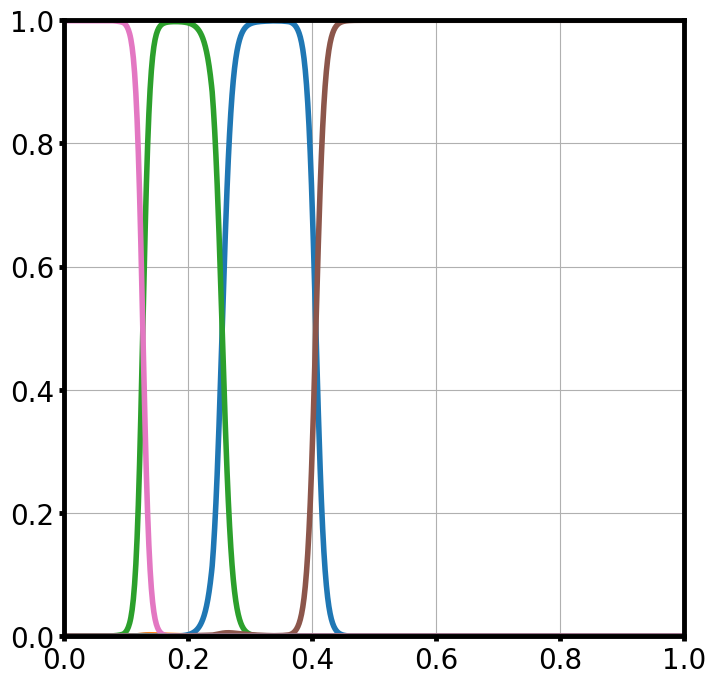

**--- Epoch 5000: Visualizing Partitions ---**

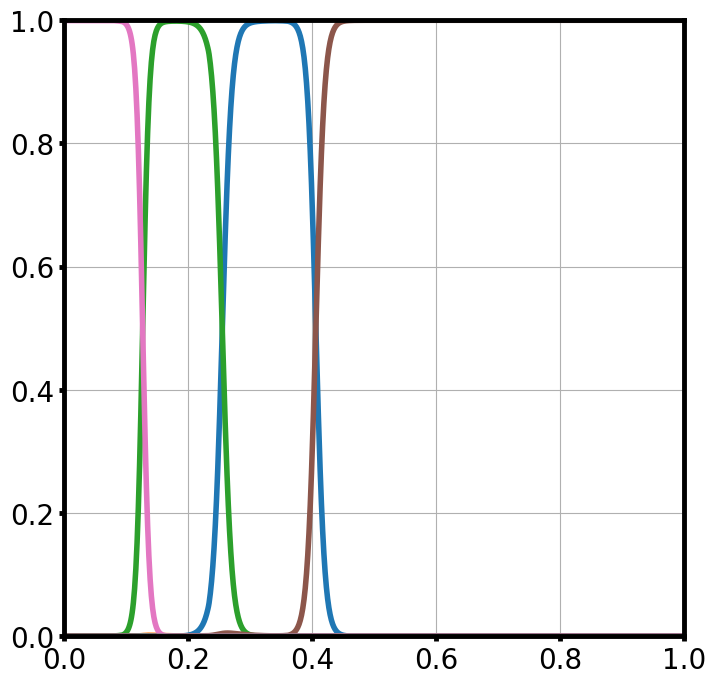

  Epoch   5000 | Loss: 1.877785e-01


**--- Epoch 5500: Visualizing Partitions ---**

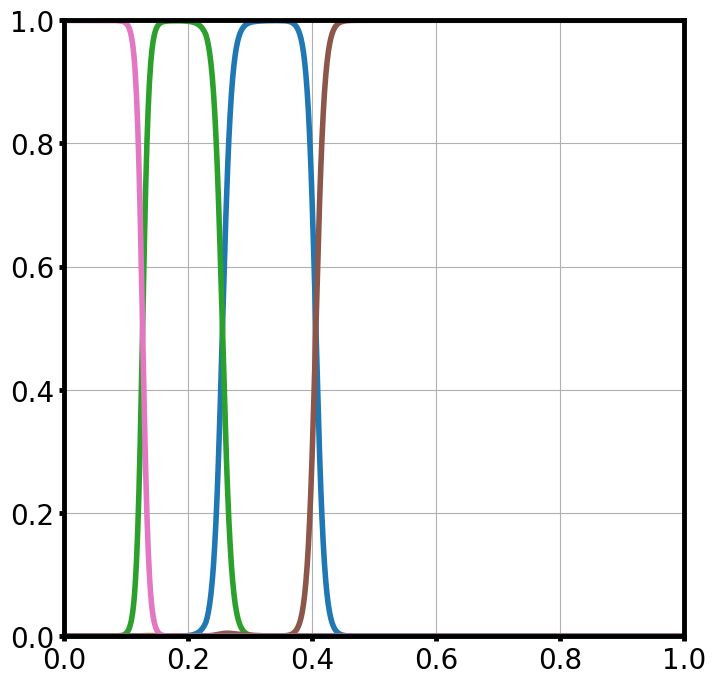

**--- Epoch 6000: Visualizing Partitions ---**

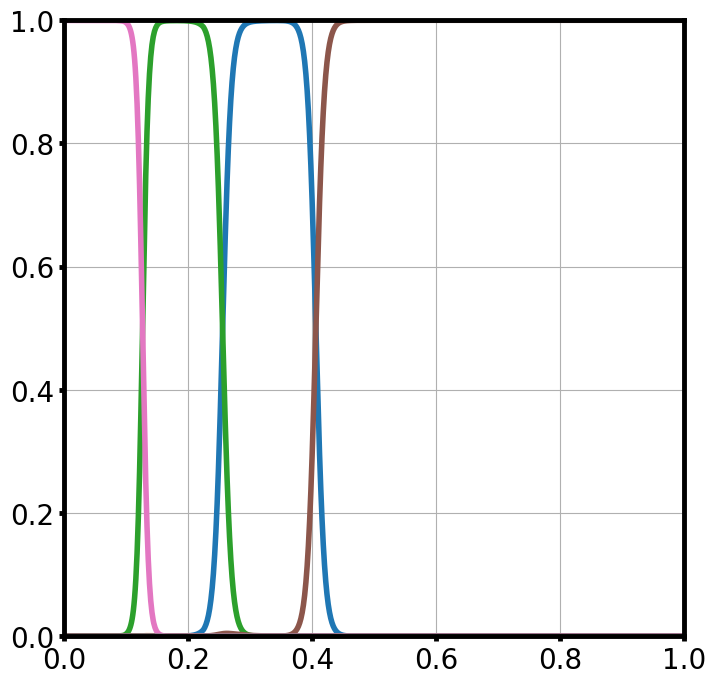

  Epoch   6000 | Loss: 1.877213e-01


**--- Epoch 6500: Visualizing Partitions ---**

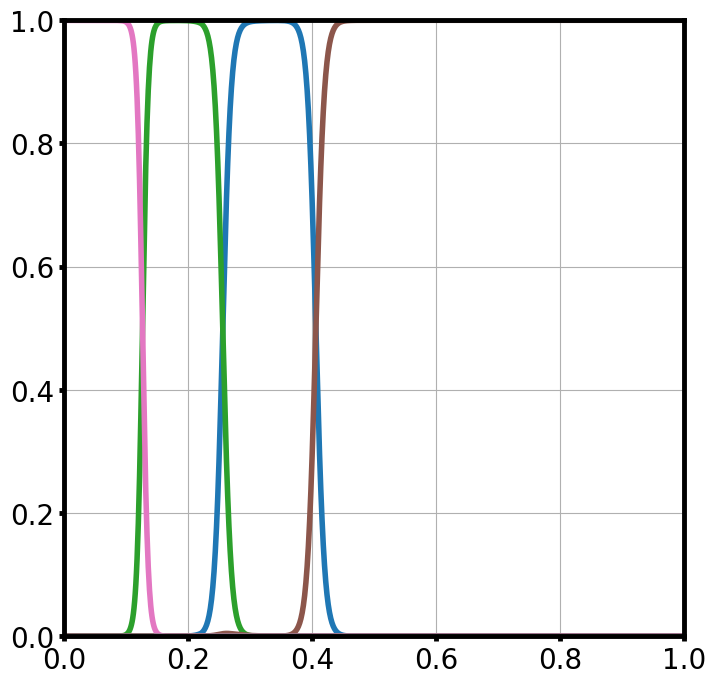

**--- Epoch 7000: Visualizing Partitions ---**

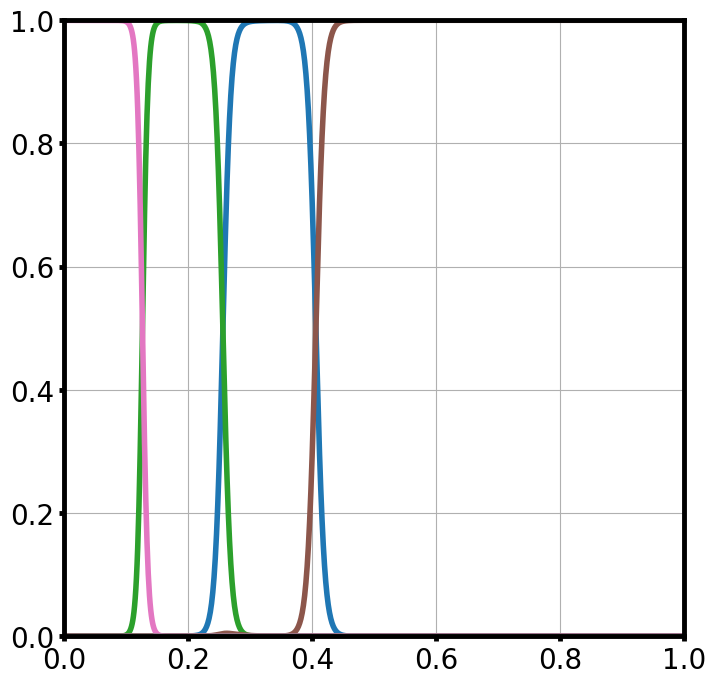

  Epoch   7000 | Loss: 1.876950e-01


**--- Epoch 7500: Visualizing Partitions ---**

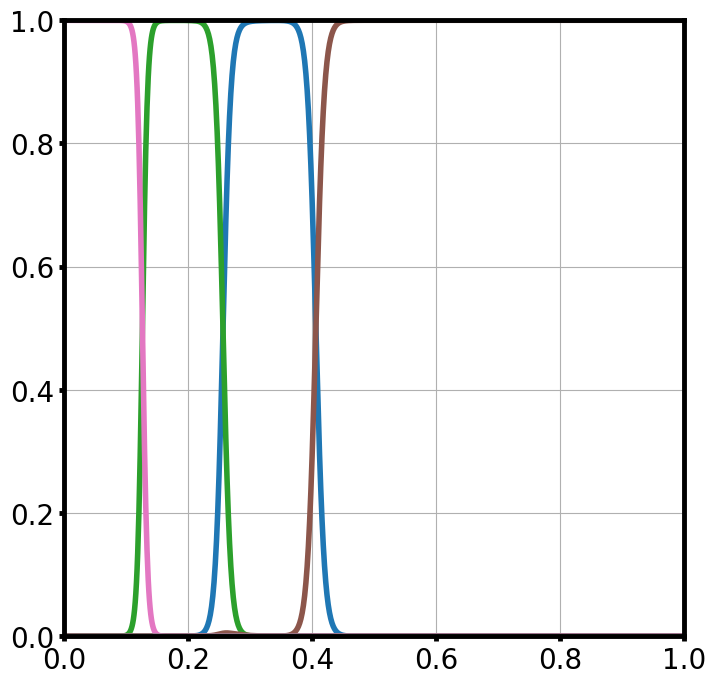

**--- Epoch 8000: Visualizing Partitions ---**

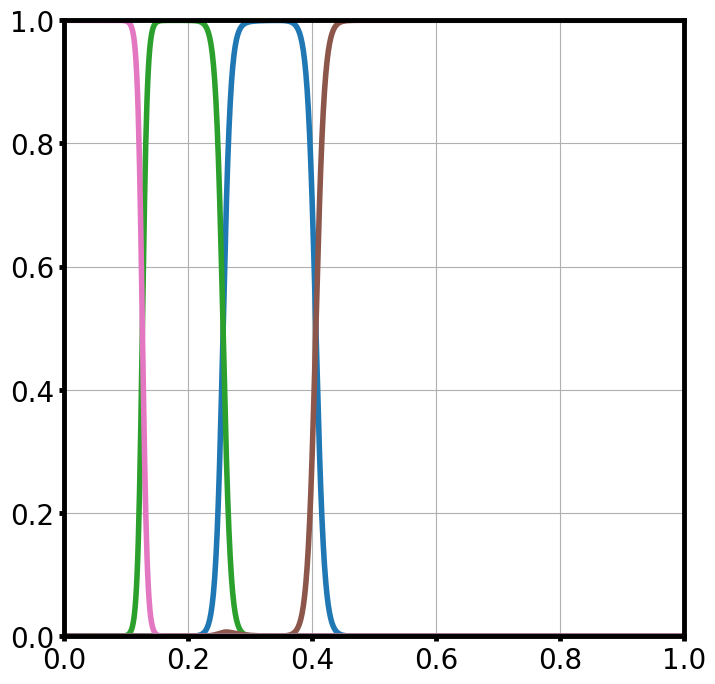

  Epoch   8000 | Loss: 1.876816e-01


**--- Epoch 8500: Visualizing Partitions ---**

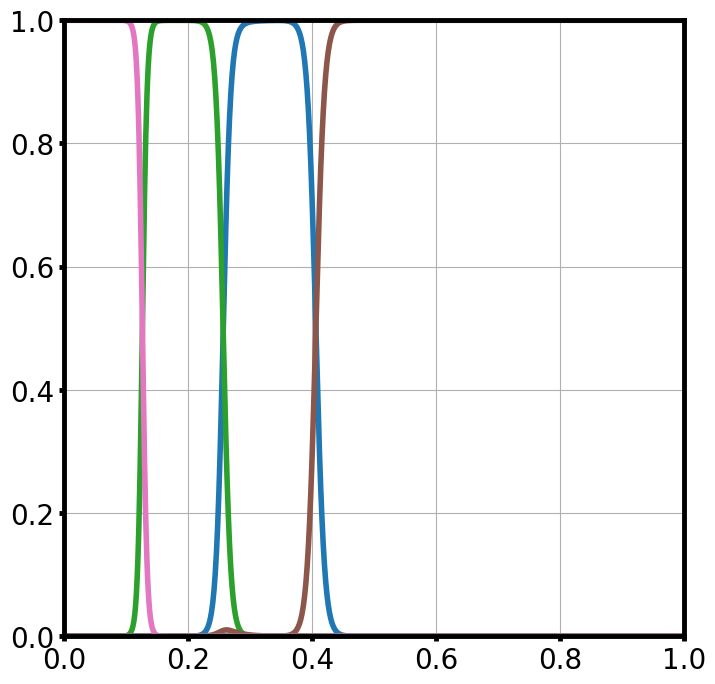

**--- Epoch 9000: Visualizing Partitions ---**

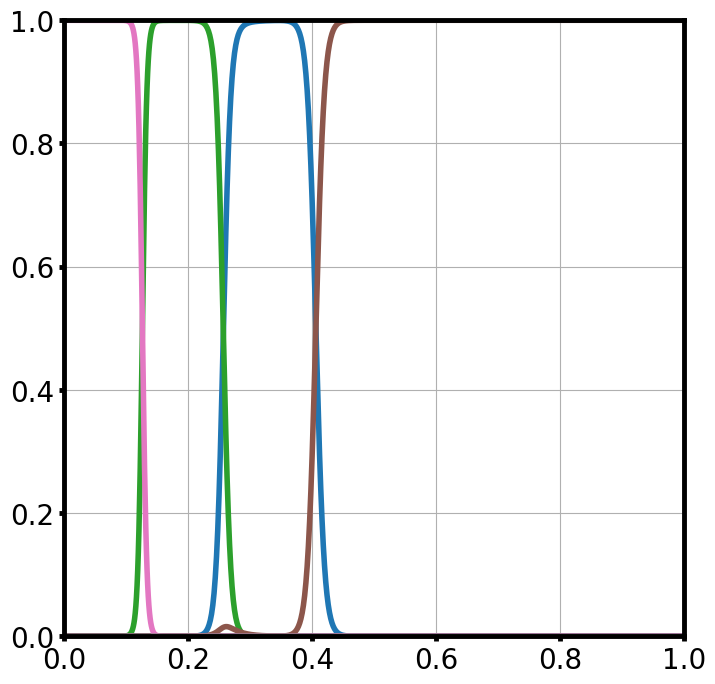

  Epoch   9000 | Loss: 1.876729e-01


**--- Epoch 9500: Visualizing Partitions ---**

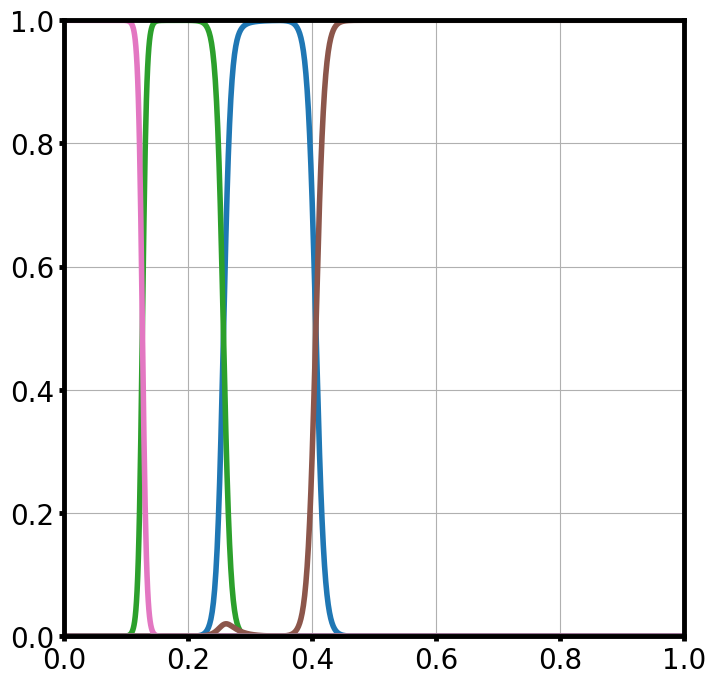

**--- Final Result for p=4 ---**

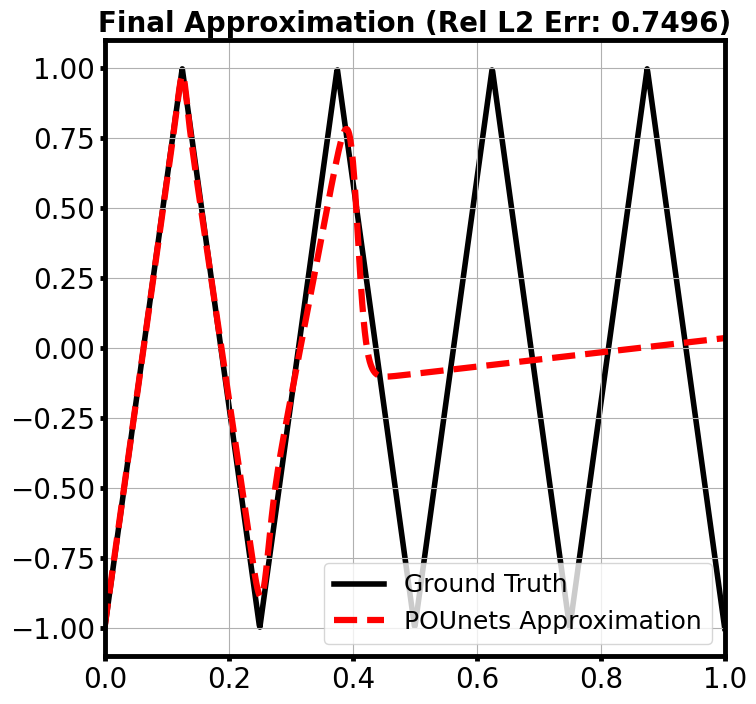

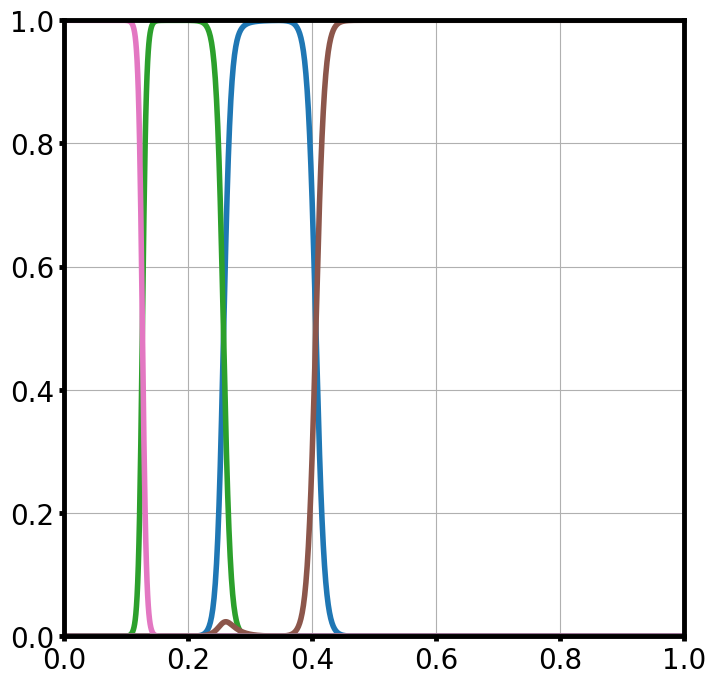

In [ ]:
NET_TAG = "mlp"
DIM = 1
EPOCHS = 10000
N_EXPERTS = 8
P_VALUE = 4
VIZ_INTERVAL = 500
POLY_DEGREE = 1 # Use 1 for linear, 2 for quadratic
HIDDEN_LAYERS = (8,8) 
LEARNING_RATE = 1e-3
LAM_INIT = 0
RHO = 1.0
N_STAG = 100
key     = jax.random.PRNGKey(5)
display(Markdown(f'### 1D {NET_TAG.upper()} Experiment (p={P_VALUE}, degree={POLY_DEGREE})'))

x_train = jnp.linspace(0, 1, 1000)[:, None]
y_train = _tri_func_1d(x_train, p=P_VALUE)
net = MLPPOUNet(input_dim=DIM, num_experts=N_EXPERTS, hidden=HIDDEN_LAYERS, key=key)
params = net.init_params()

display(Markdown(f"**--- Initial Partitions (Epoch 0) ---**"))
fig_initial = viz_partitions(net, params, x_train)
if fig_initial:
    fig_initial.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_p{P_VALUE}_{N_EXPERTS}exp_initial_partitions.png")
    plt.show(fig_initial)

lsgd_cfg = LSGDConfig(n_epochs=EPOCHS, viz_interval=VIZ_INTERVAL, lr=LEARNING_RATE,
                      lam_init=LAM_INIT, rho=RHO, n_stag=N_STAG, poly_degree=POLY_DEGREE)
final_params = run_lsgd(net, params, x_train, y_train, lsgd_cfg)

display(Markdown(f"**--- Final Result for p={P_VALUE} ---**"))

fig_approx = viz_final(net, final_params, x_train, y_train, POLY_DEGREE)
if fig_approx:
    fig_approx.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_p{P_VALUE}_{N_EXPERTS}exp_final_approx.png")
    plt.show(fig_approx)
    
fig_part = viz_partitions(net, final_params, x_train)
if fig_part:
    fig_part.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_p{P_VALUE}_{N_EXPERTS}exp_final_partitions.png")
    plt.show(fig_part)

### 1D MLP Experiment (p=4, degree=1)

**--- Initial Partitions (Epoch 0) ---**

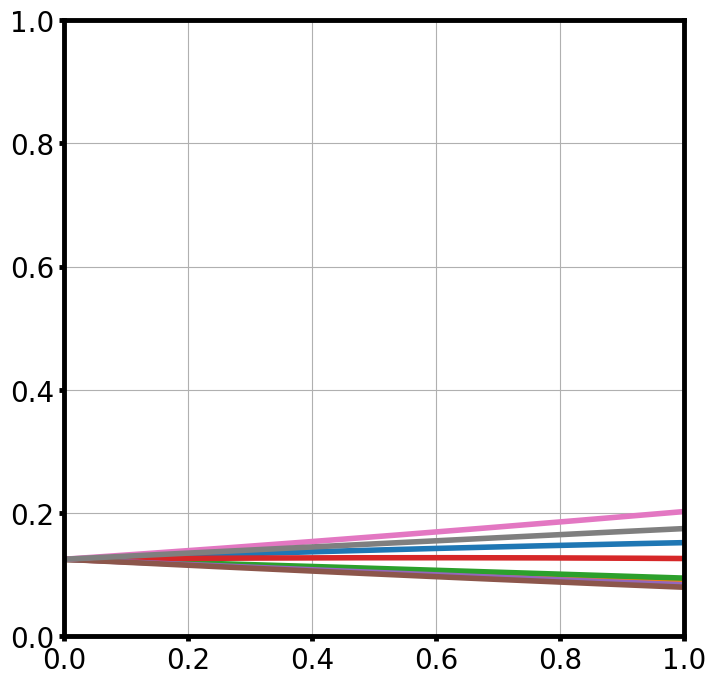

  Epoch      0 | Loss: 3.339779e-01


**--- Epoch 2500: Visualizing Partitions ---**

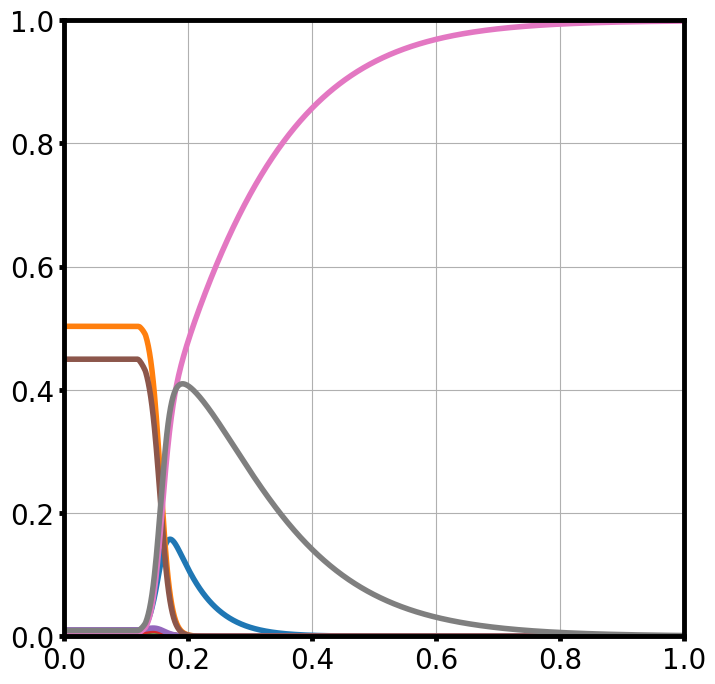

**--- Epoch 5000: Visualizing Partitions ---**

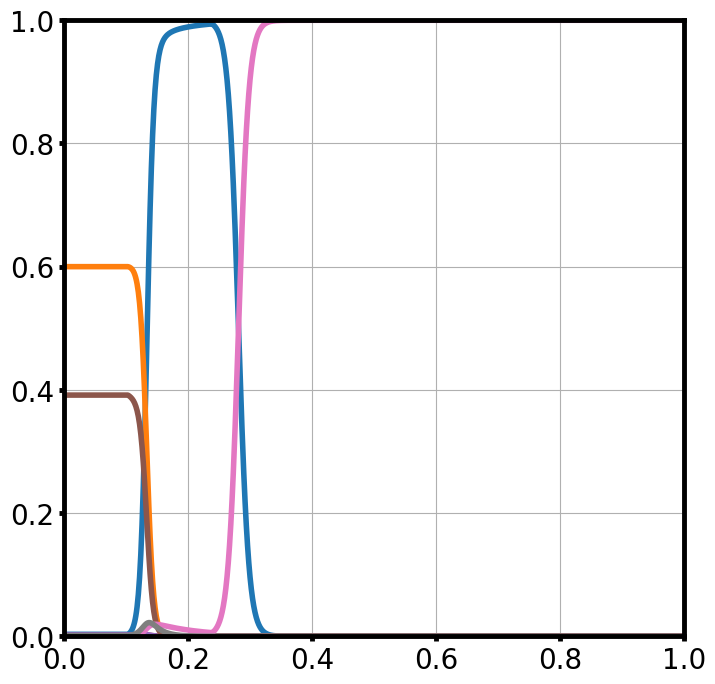

  Epoch   5000 | Loss: 2.284906e-01


**--- Epoch 7500: Visualizing Partitions ---**

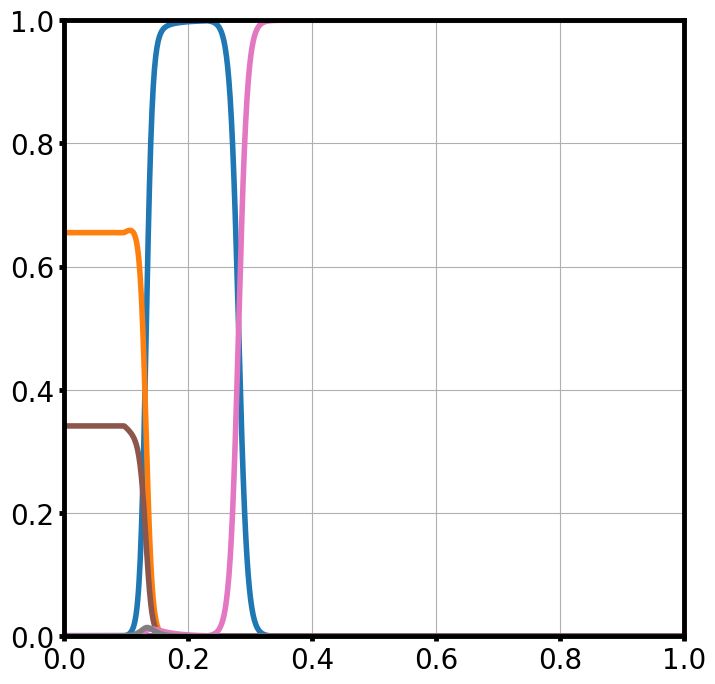

**--- Epoch 10000: Visualizing Partitions ---**

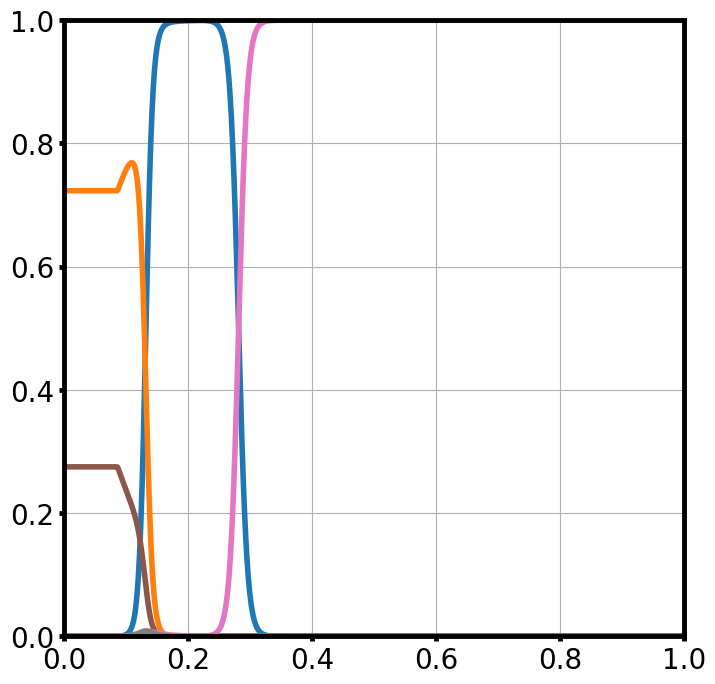

  Epoch  10000 | Loss: 2.278768e-01


**--- Epoch 12500: Visualizing Partitions ---**

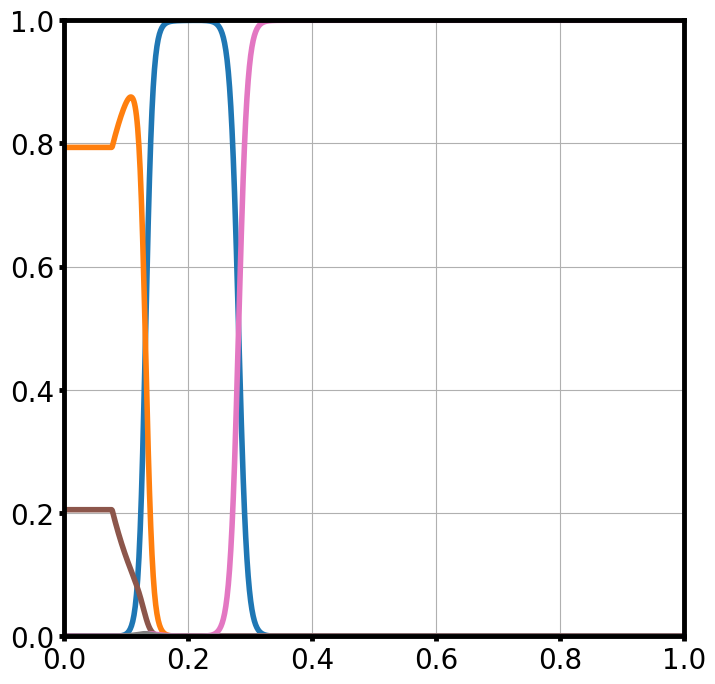

**--- Epoch 15000: Visualizing Partitions ---**

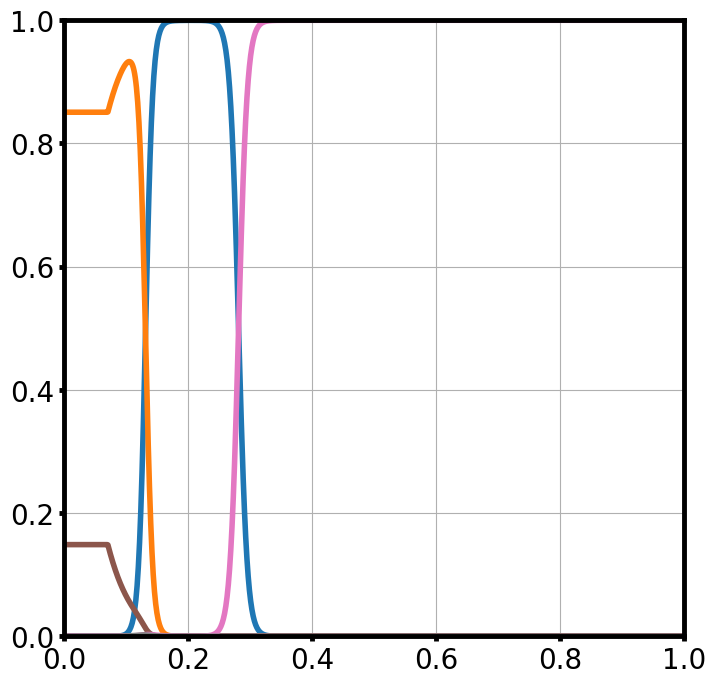

  Epoch  15000 | Loss: 2.278576e-01


**--- Epoch 17500: Visualizing Partitions ---**

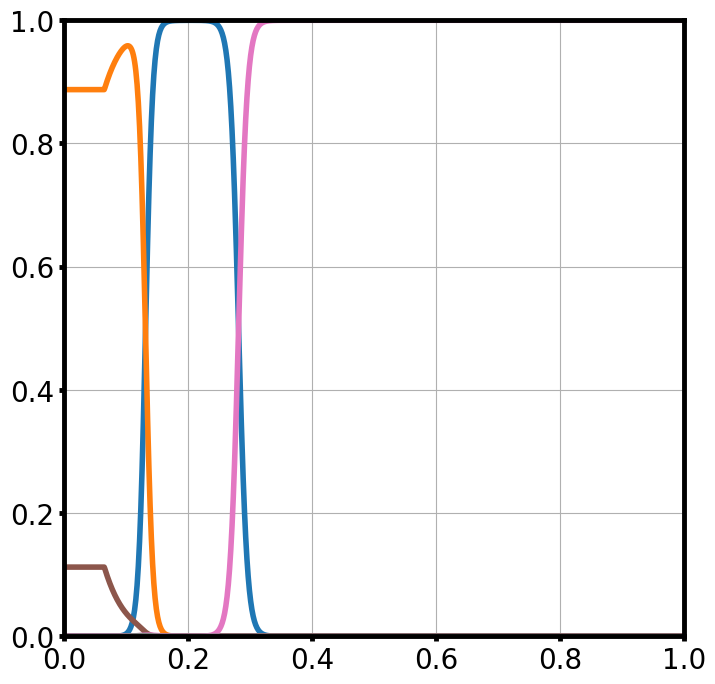

**--- Epoch 20000: Visualizing Partitions ---**

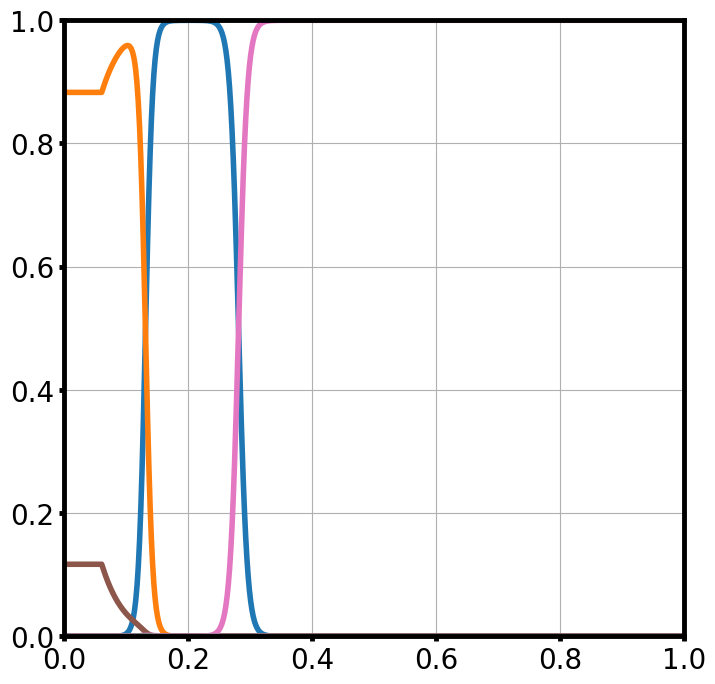

  Epoch  20000 | Loss: 2.278563e-01


**--- Epoch 22500: Visualizing Partitions ---**

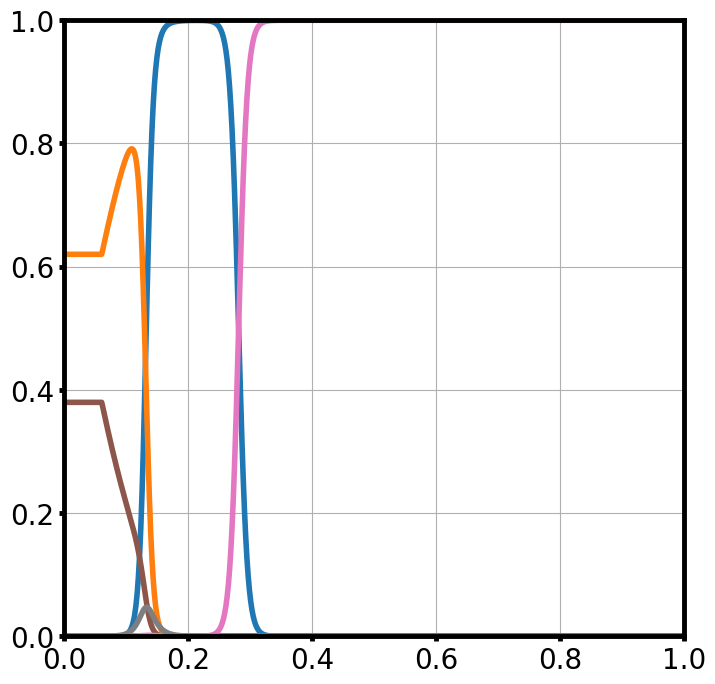

**--- Epoch 25000: Visualizing Partitions ---**

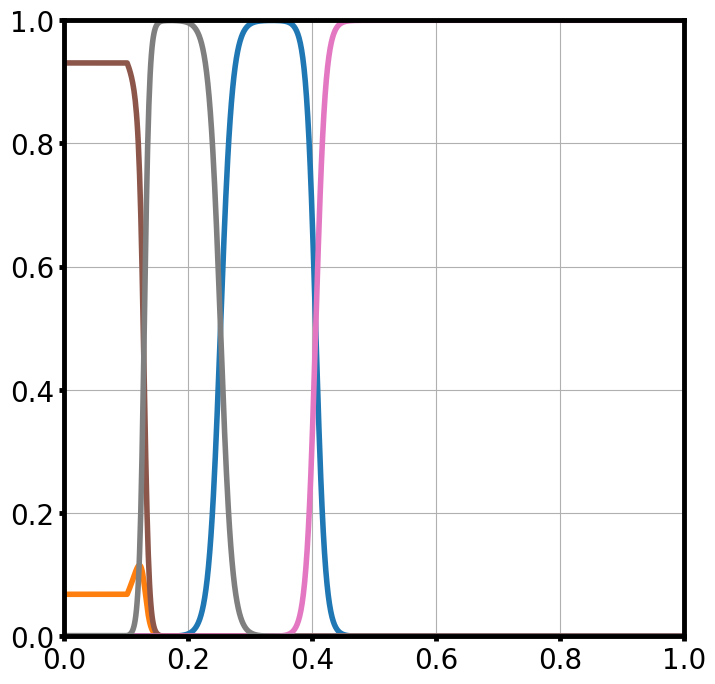

  Epoch  25000 | Loss: 1.880271e-01


**--- Epoch 27500: Visualizing Partitions ---**

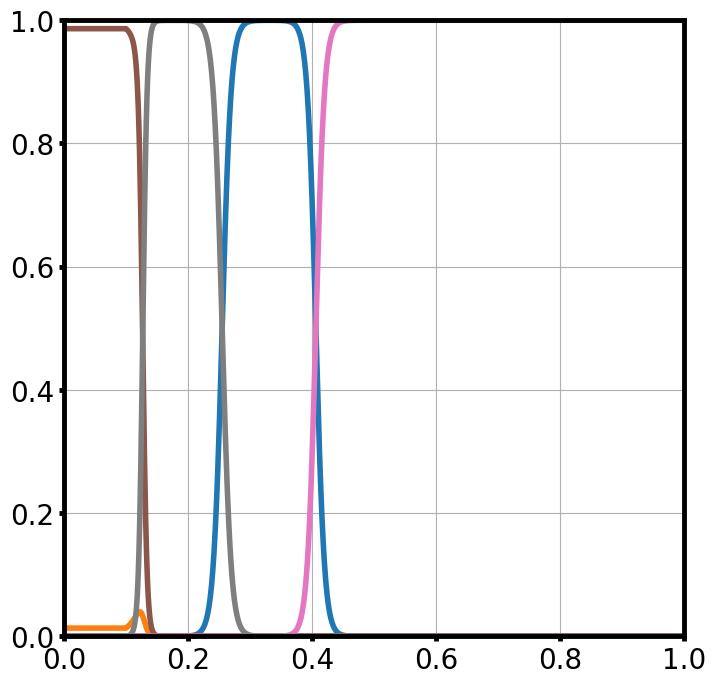

**--- Epoch 30000: Visualizing Partitions ---**

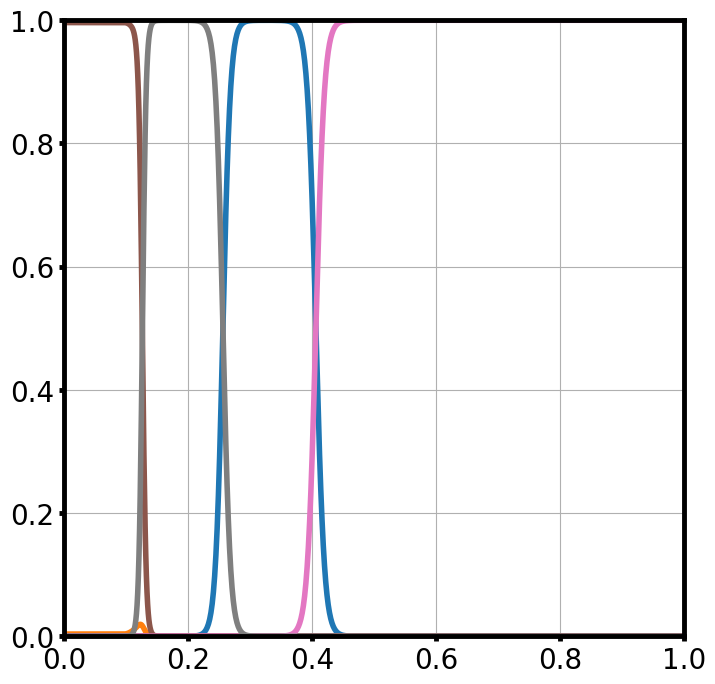

  Epoch  30000 | Loss: 1.876805e-01


**--- Epoch 32500: Visualizing Partitions ---**

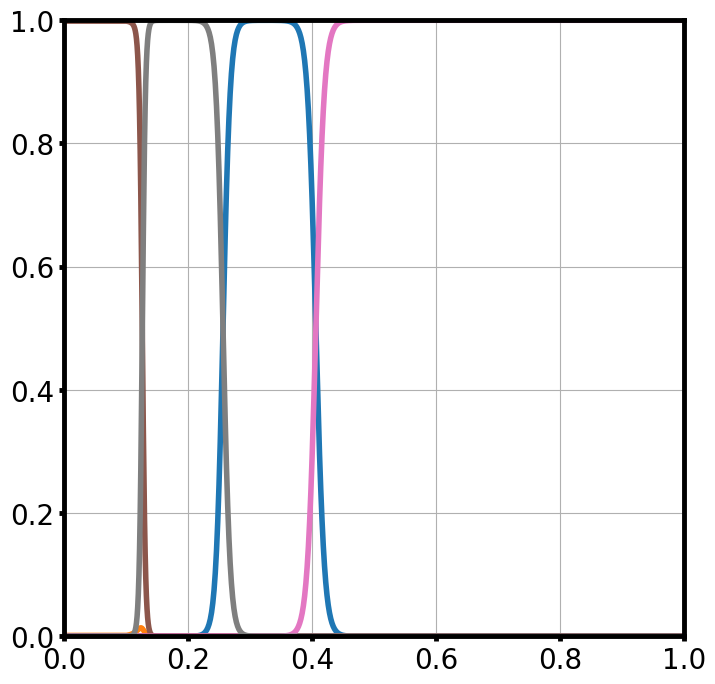

**--- Epoch 35000: Visualizing Partitions ---**

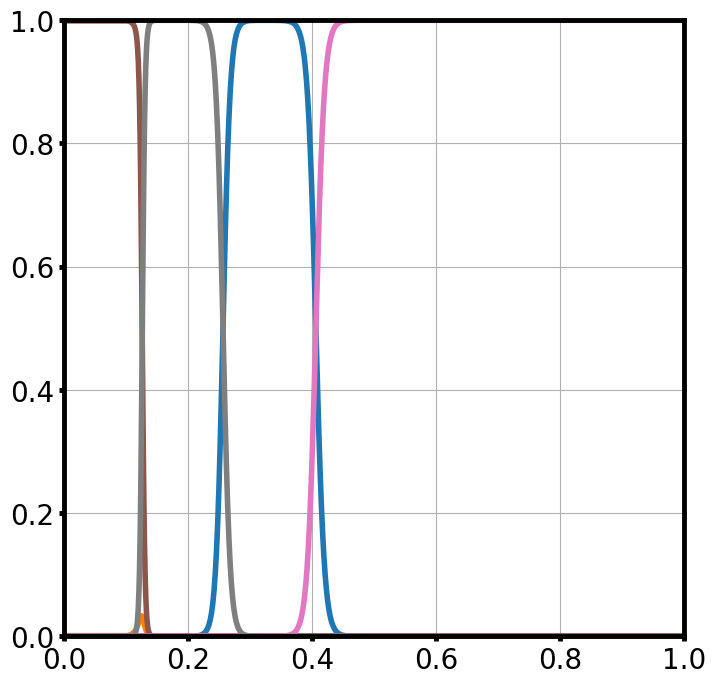

  Epoch  35000 | Loss: 1.876693e-01


**--- Epoch 37500: Visualizing Partitions ---**

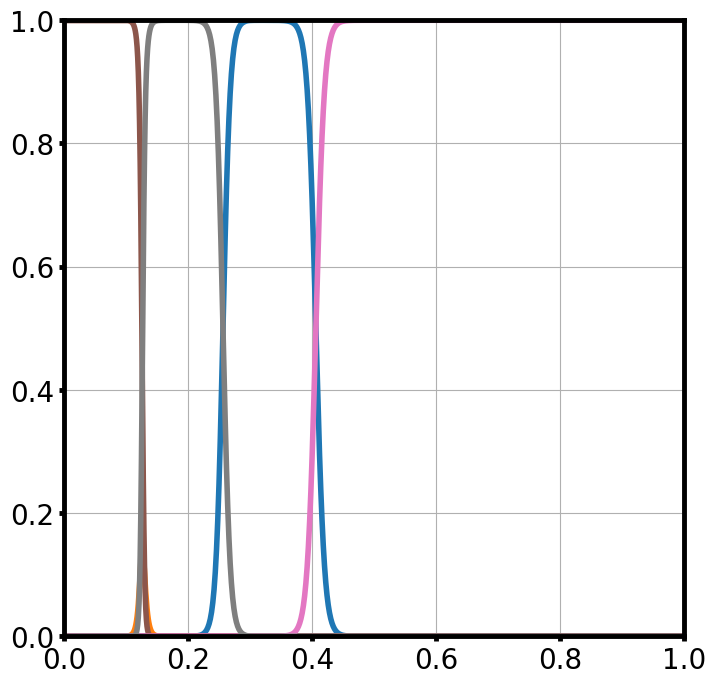

**--- Epoch 40000: Visualizing Partitions ---**

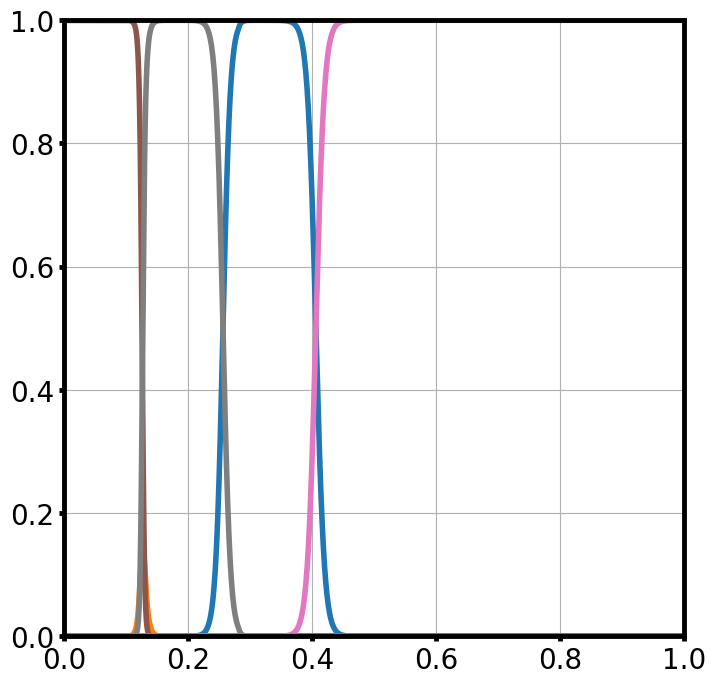

  Epoch  40000 | Loss: 1.876650e-01


**--- Epoch 42500: Visualizing Partitions ---**

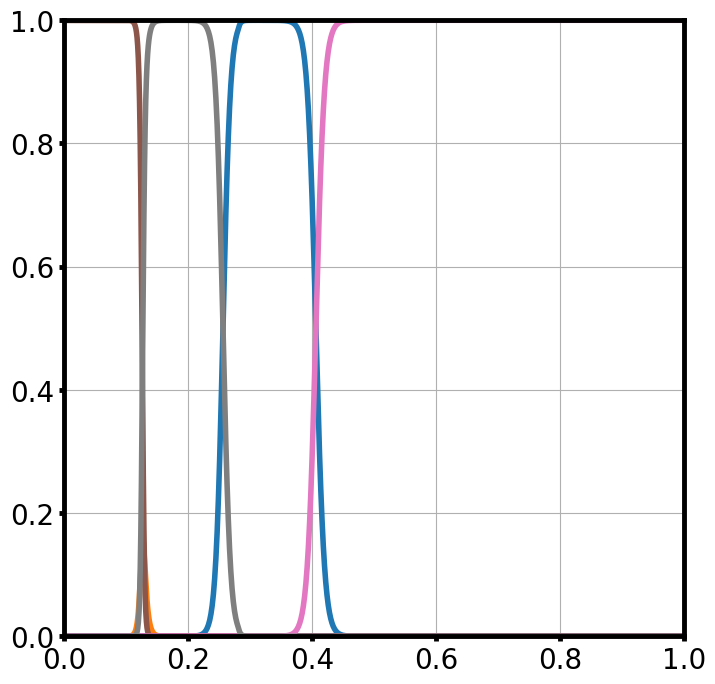

**--- Epoch 45000: Visualizing Partitions ---**

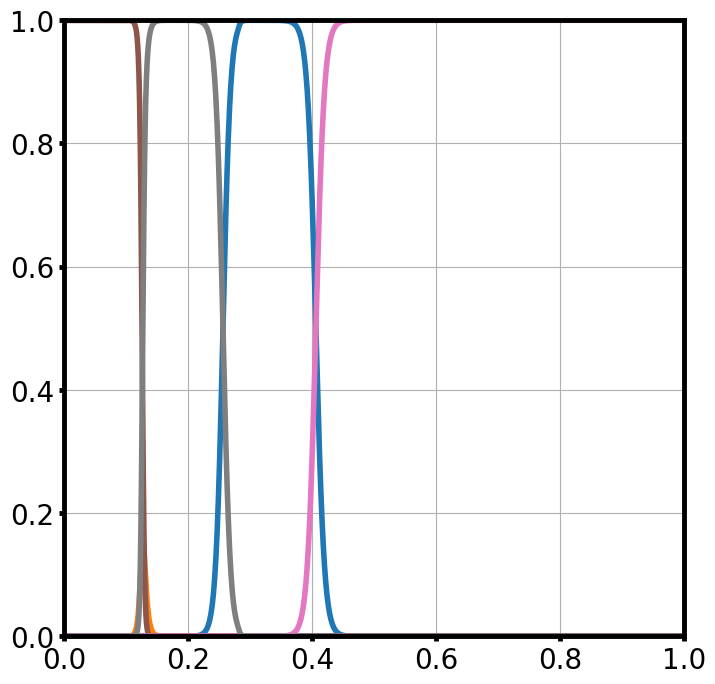

  Epoch  45000 | Loss: 1.876645e-01


**--- Epoch 47500: Visualizing Partitions ---**

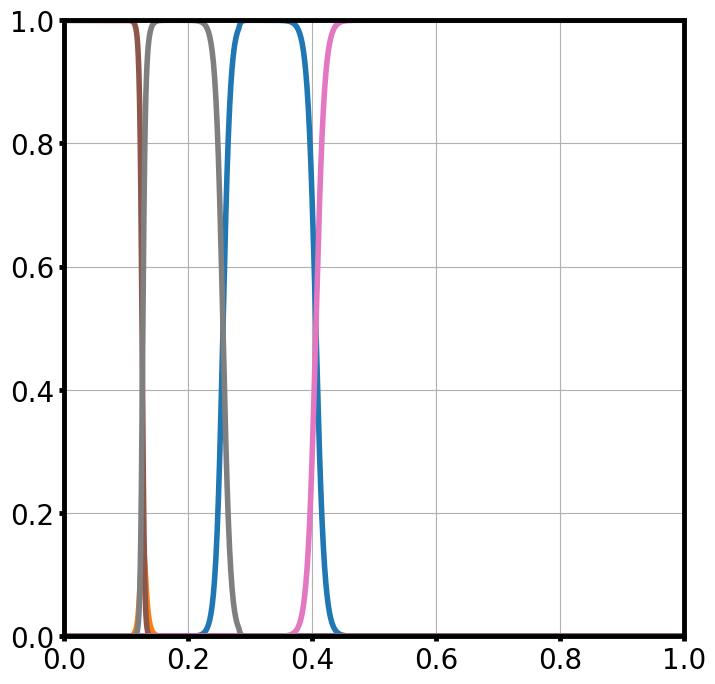

**--- Final Result for p=4 ---**

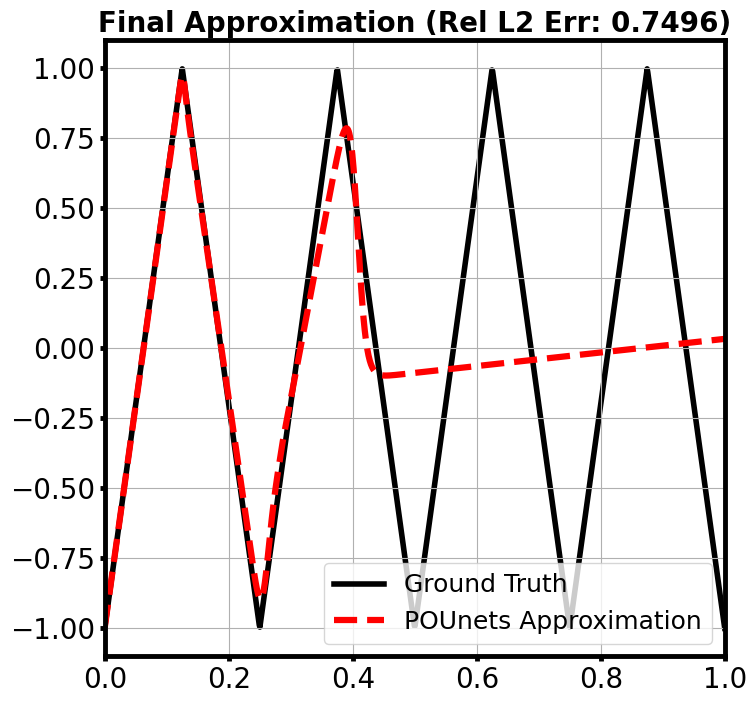

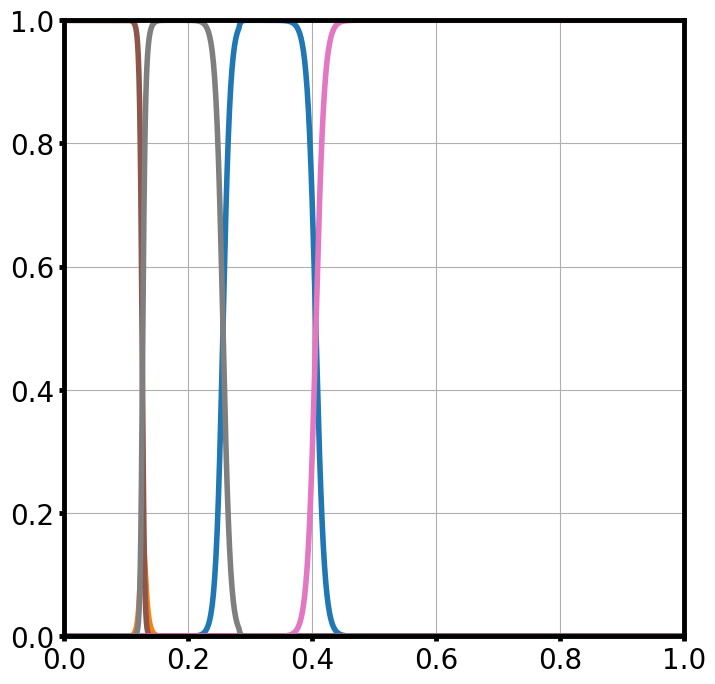

In [ ]:
NET_TAG = "mlp"
DIM = 1
EPOCHS = 50000
N_EXPERTS = 8
P_VALUE = 4
VIZ_INTERVAL = 2500
POLY_DEGREE = 1 # Use 1 for linear, 2 for quadratic
# --- Network Architecture ---
HIDDEN_LAYERS = (4,4) #  (64,) for one layer, (64, 64) for two
# --- Hyperparameters to Tune ---
LEARNING_RATE = 1e-3
LAM_INIT = 0
RHO = 1
N_STAG = 100

display(Markdown(f'### 1D {NET_TAG.upper()} Experiment (p={P_VALUE}, degree={POLY_DEGREE})'))

x_train = jnp.linspace(0, 1, 1000)[:, None]
y_train = _tri_func_1d(x_train, p=P_VALUE)
net = MLPPOUNet(input_dim=DIM, num_experts=N_EXPERTS, hidden=HIDDEN_LAYERS, key=key)
params = net.init_params()

display(Markdown(f"**--- Initial Partitions (Epoch 0) ---**"))
fig_initial = viz_partitions(net, params, x_train)
if fig_initial:
    fig_initial.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_p{P_VALUE}_{N_EXPERTS}exp_initial_partitions.png")
    plt.show(fig_initial)

lsgd_cfg = LSGDConfig(n_epochs=EPOCHS, viz_interval=VIZ_INTERVAL, lr=LEARNING_RATE,
                      lam_init=LAM_INIT, rho=RHO, n_stag=N_STAG, poly_degree=POLY_DEGREE)
final_params = run_lsgd(net, params, x_train, y_train, lsgd_cfg)

display(Markdown(f"**--- Final Result for p={P_VALUE} ---**"))

fig_approx = viz_final(net, final_params, x_train, y_train, POLY_DEGREE)
if fig_approx:
    fig_approx.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_p{P_VALUE}_{N_EXPERTS}exp_final_approx.png")
    plt.show(fig_approx)
    
fig_part = viz_partitions(net, final_params, x_train)
if fig_part:
    fig_part.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_p{P_VALUE}_{N_EXPERTS}exp_final_partitions.png")
    plt.show(fig_part)

### 1D RBF Experiment (sin(2πkx), k=4, degree=2)

**--- Initial Partitions (Epoch 0) ---**

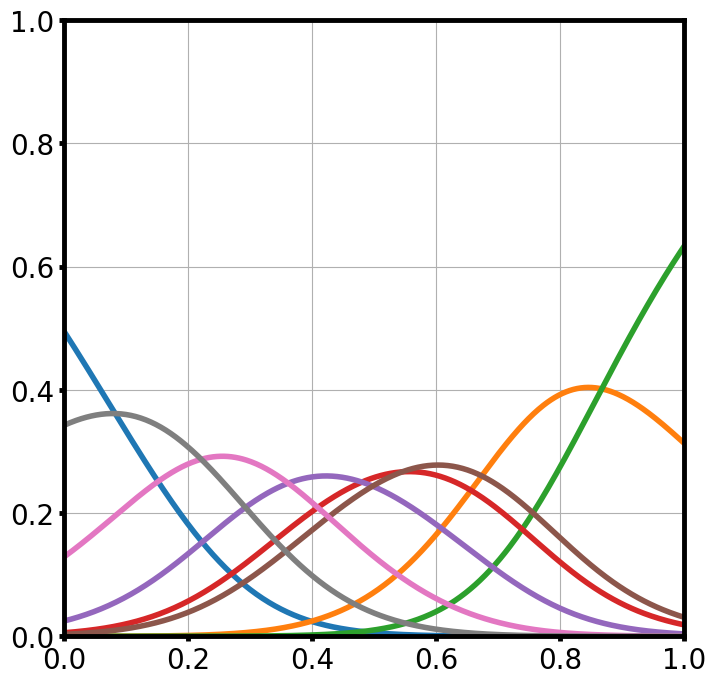

  Epoch      0 | Loss: 4.383447e-01
  Epoch    100 | Loss: 2.677237e-01
  Epoch    200 | Loss: 9.348237e-03
  Epoch    300 | Loss: 1.592633e-03
  Epoch    400 | Loss: 9.730712e-04


**--- Epoch 500: Visualizing Partitions ---**

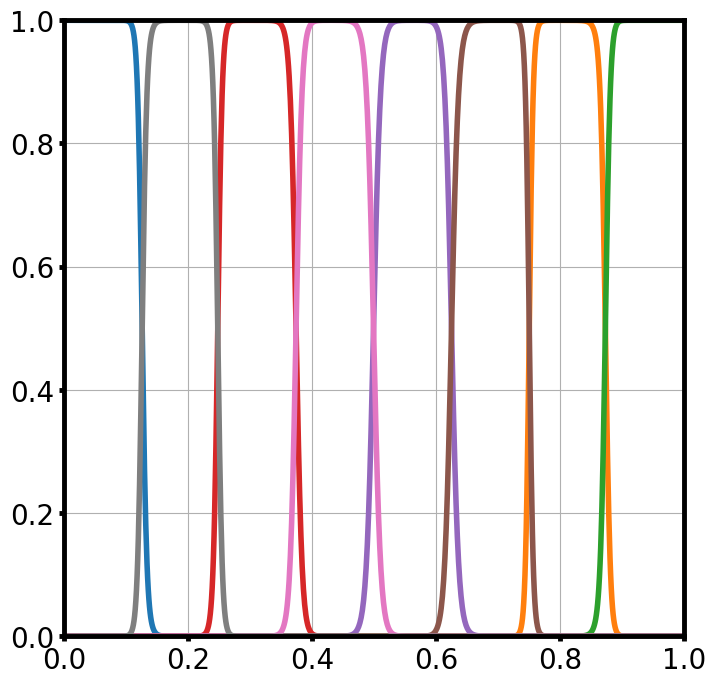

  Epoch    500 | Loss: 5.417807e-04
  Epoch    600 | Loss: 3.624390e-04
  Epoch    700 | Loss: 2.985090e-04
  Epoch    800 | Loss: 2.716921e-04
  Epoch    900 | Loss: 2.588204e-04


**--- Final Result for k=4 ---**

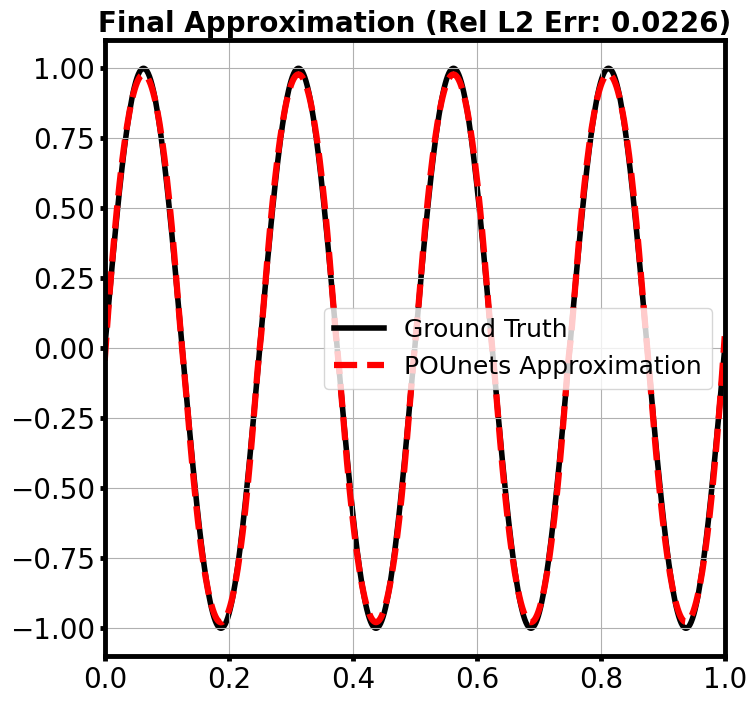

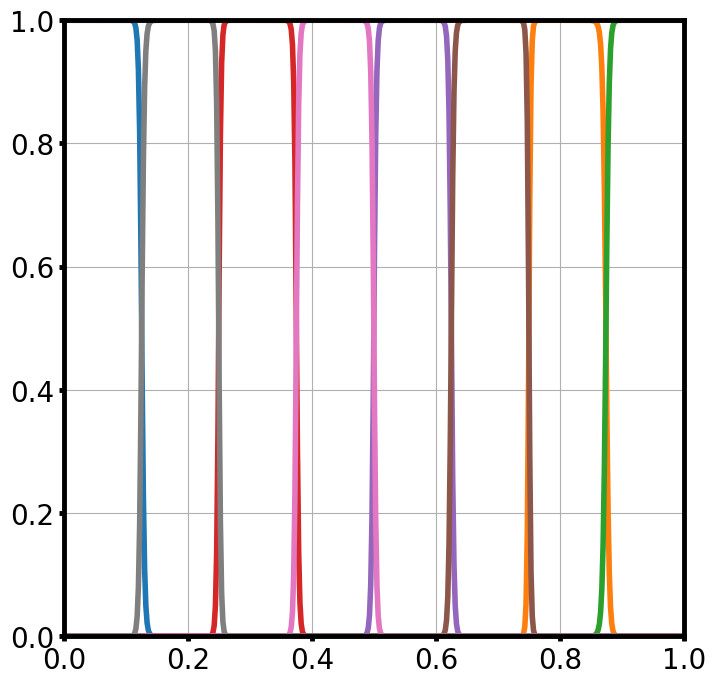

In [ ]:
NET_TAG = "rbf"
DIM = 1
EPOCHS = 1000
N_EXPERTS = 8
k_val = 4 # Frequency parameter for the sine wave
VIZ_INTERVAL = 500 
POLY_DEGREE = 2
LEARNING_RATE = 1e-3
LAM_INIT = 0
RHO = 1.0
N_STAG = 200

display(Markdown(f'### 1D {NET_TAG.upper()} Experiment (sin(2πkx), k={k_val}, degree={POLY_DEGREE})'))
key, data_key = random.split(key)
x_train = jnp.linspace(0, 1, 1000)[:, None]
y_train = _sin_func_1d(x_train, k=k_val)
net = RBFPOUNet(input_dim=DIM, num_centers=N_EXPERTS, key=key)
params = net.init_params()

display(Markdown(f"**--- Initial Partitions (Epoch 0) ---**"))
x_viz_init = jnp.linspace(0, 1, 500)[:, None]
fig_initial = viz_partitions(net, params, x_viz_init)
if fig_initial:
    plt.show(fig_initial)

lsgd_cfg = LSGDConfig(n_epochs=EPOCHS, viz_interval=VIZ_INTERVAL, lr=LEARNING_RATE, 
                          lam_init=LAM_INIT, rho=RHO, n_stag=N_STAG, poly_degree=POLY_DEGREE)
final_params = run_lsgd(net, params, x_train, y_train, lsgd_cfg)

display(Markdown(f"**--- Final Result for k={k_val} ---**"))
x_viz = jnp.linspace(0, 1, 500)[:, None]
y_viz = _sin_func_1d(x_viz, k=k_val)
fig_approx = viz_final(net, final_params, x_viz, y_viz, POLY_DEGREE)
if fig_approx:
    plt.show(fig_approx)
fig_part = viz_partitions(net, final_params, x_viz)
if fig_part:
    plt.show(fig_part)

### 1D MLP Experiment (sin(2πkx), k=2, degree=2)

**--- Initial Partitions (Epoch 0) ---**

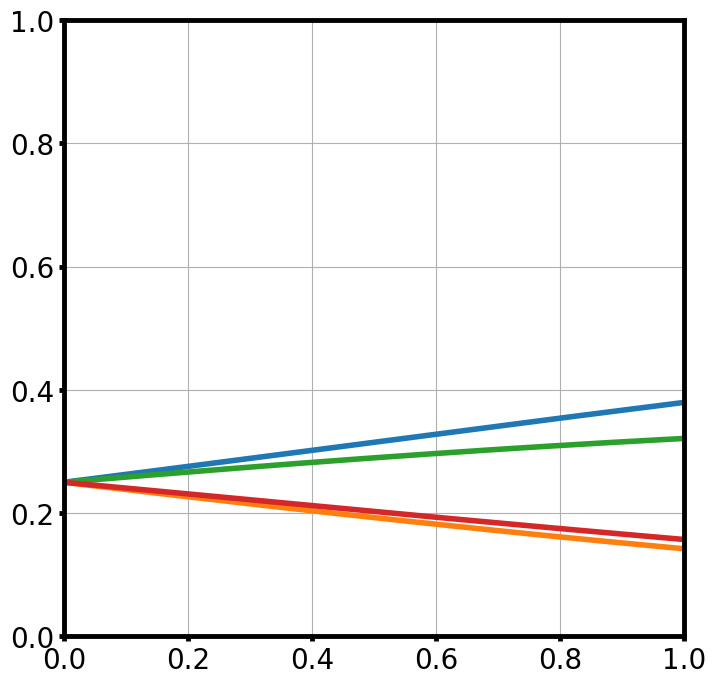

  Epoch      0 | Loss: 4.222203e-01


**--- Epoch 500: Visualizing Partitions ---**

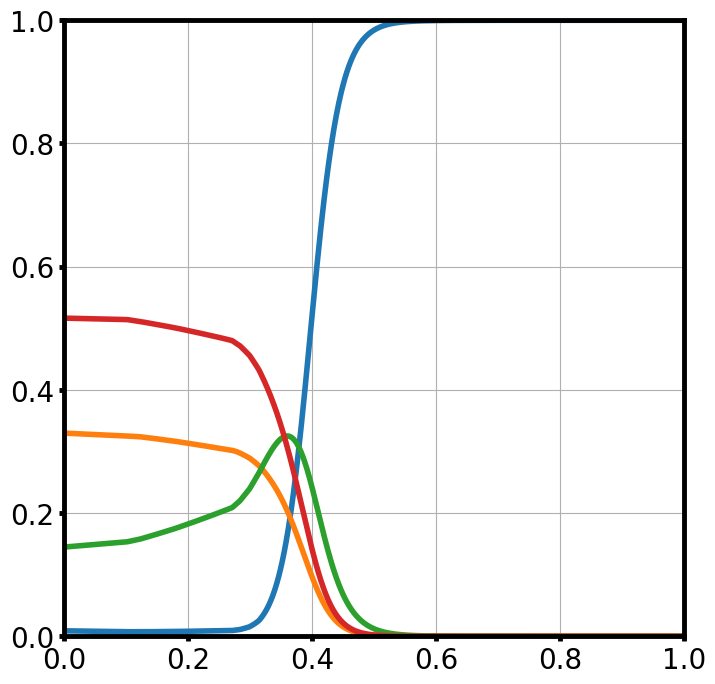

**--- Epoch 1000: Visualizing Partitions ---**

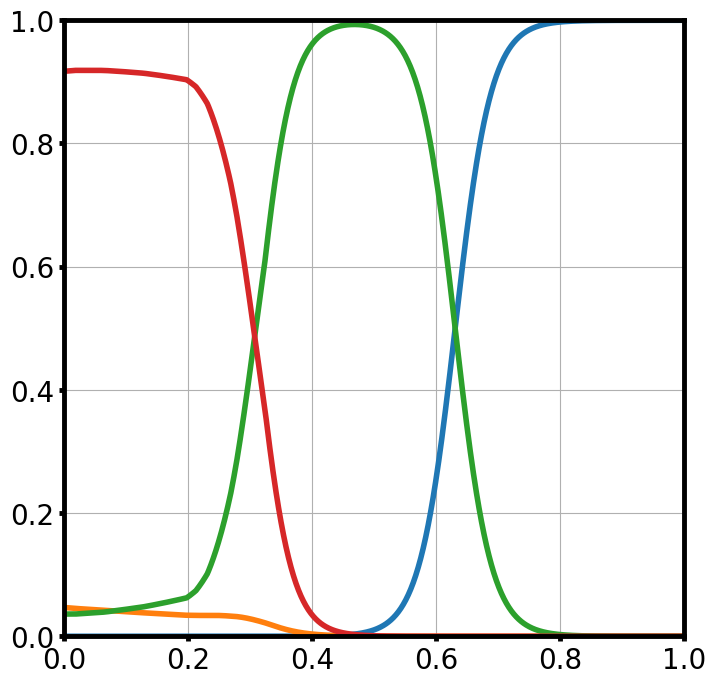

  Epoch   1000 | Loss: 3.667269e-02


**--- Epoch 1500: Visualizing Partitions ---**

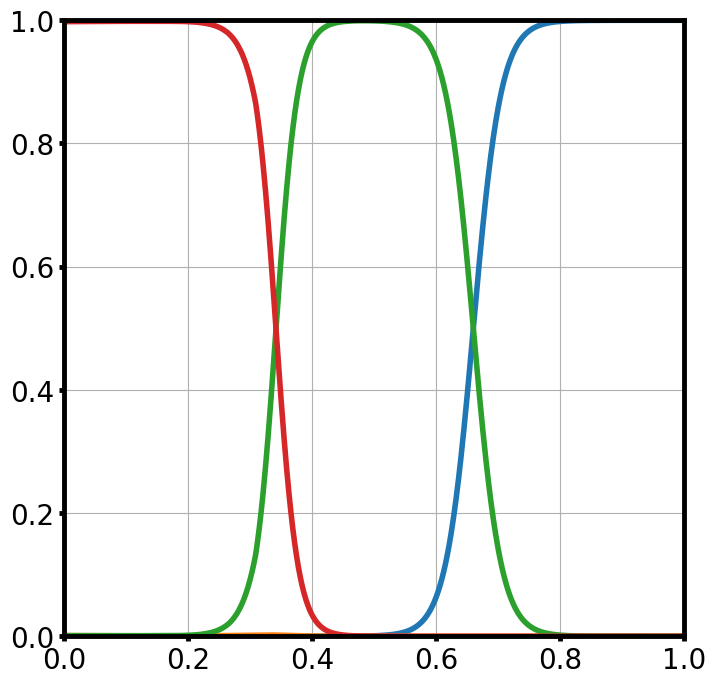

**--- Epoch 2000: Visualizing Partitions ---**

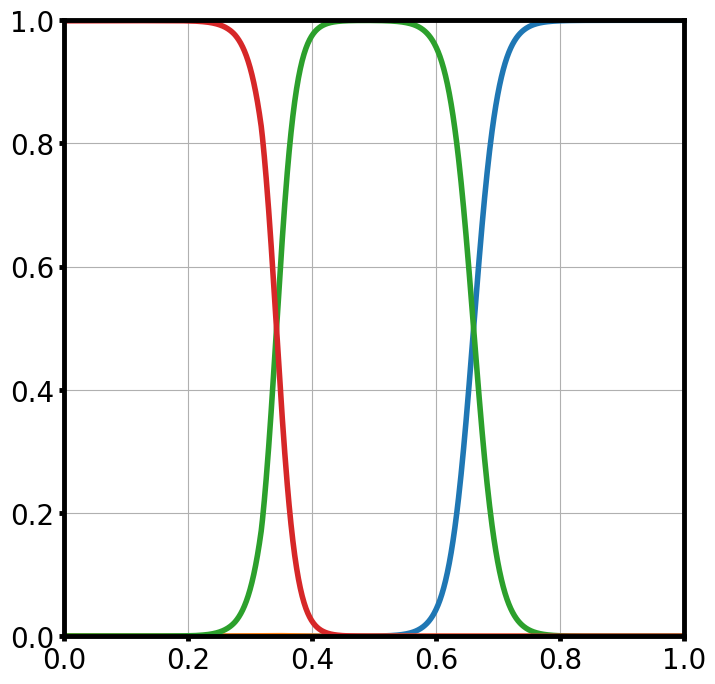

  Epoch   2000 | Loss: 2.085773e-02


**--- Epoch 2500: Visualizing Partitions ---**

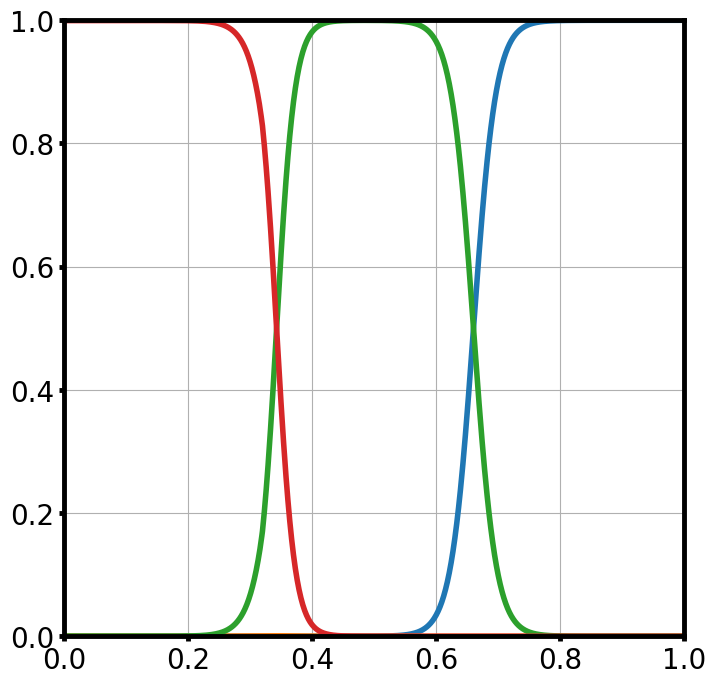

**--- Epoch 3000: Visualizing Partitions ---**

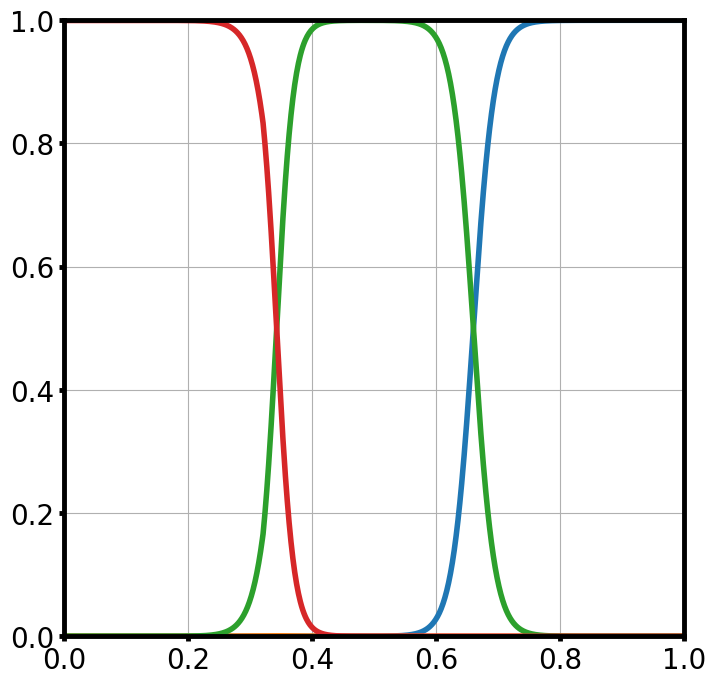

  Epoch   3000 | Loss: 2.039082e-02


**--- Epoch 3500: Visualizing Partitions ---**

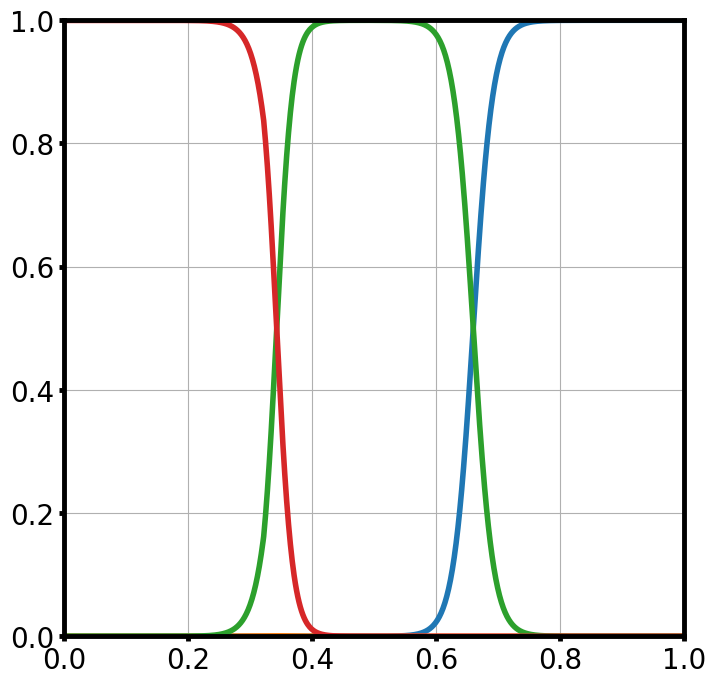

**--- Epoch 4000: Visualizing Partitions ---**

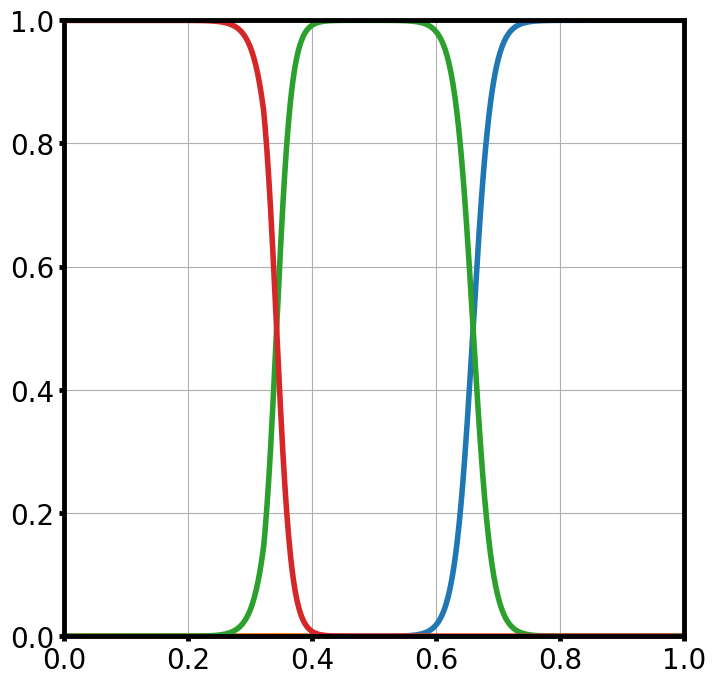

  Epoch   4000 | Loss: 2.017106e-02


**--- Epoch 4500: Visualizing Partitions ---**

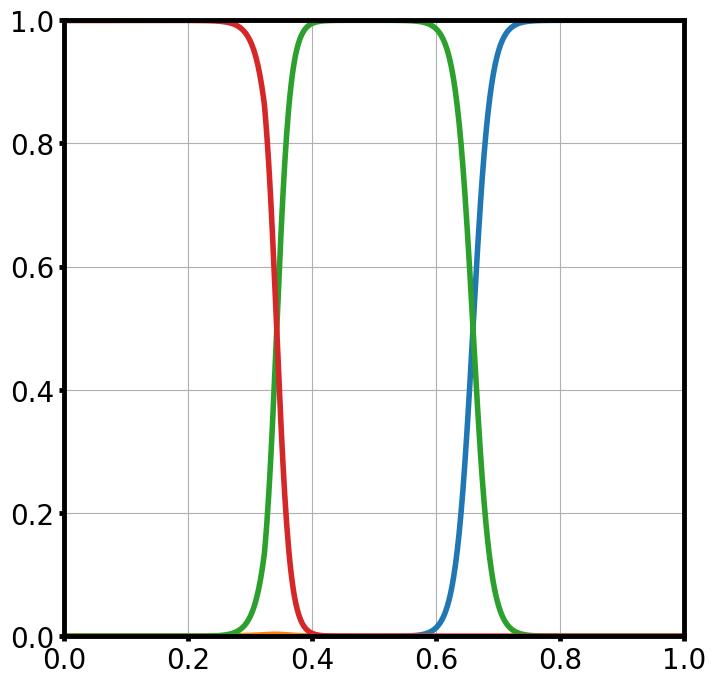

**--- Epoch 5000: Visualizing Partitions ---**

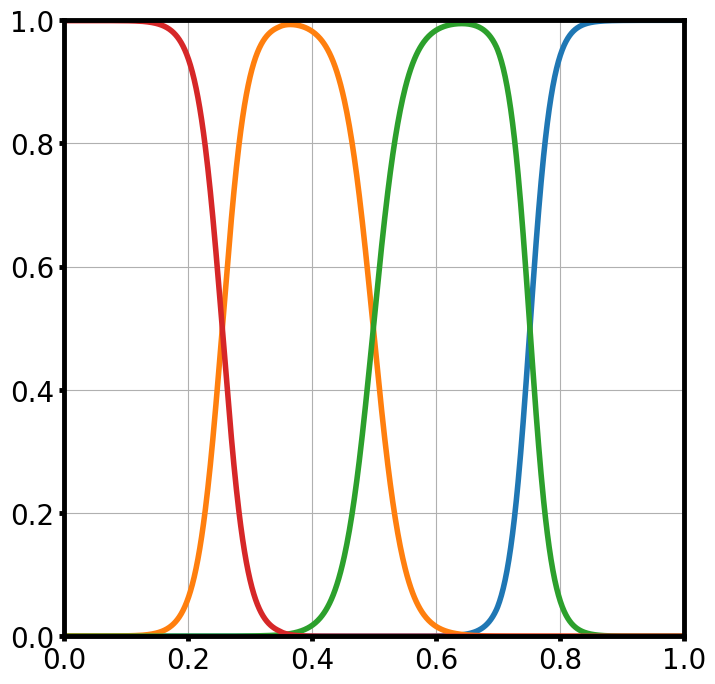

  Epoch   5000 | Loss: 1.802178e-03


**--- Epoch 5500: Visualizing Partitions ---**

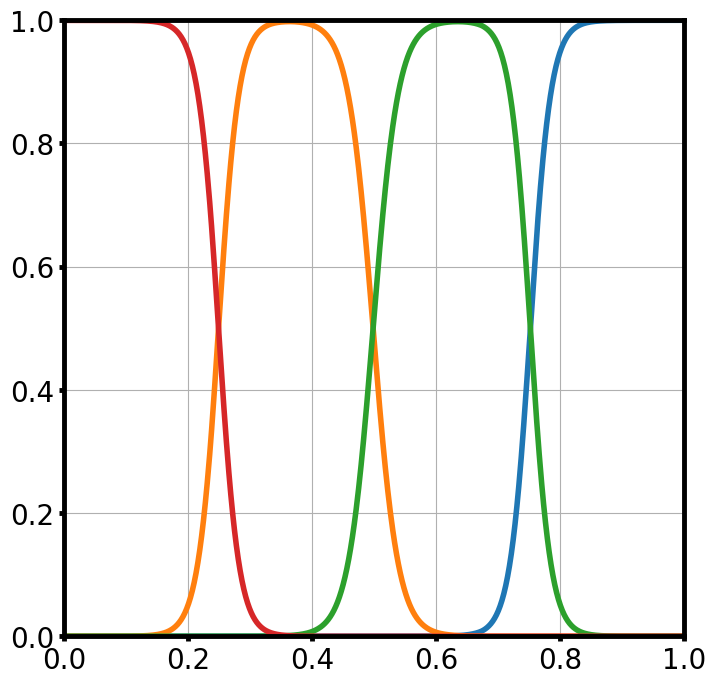

**--- Epoch 6000: Visualizing Partitions ---**

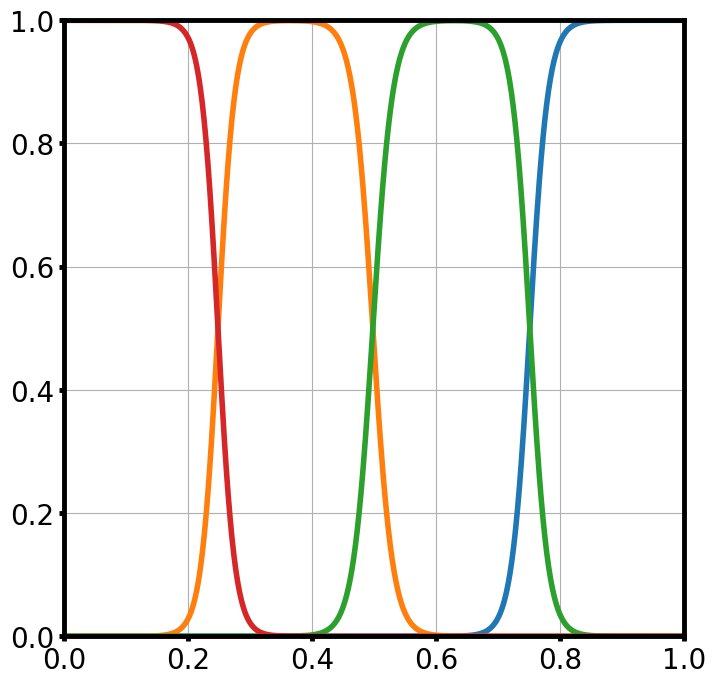

  Epoch   6000 | Loss: 1.137042e-03


**--- Epoch 6500: Visualizing Partitions ---**

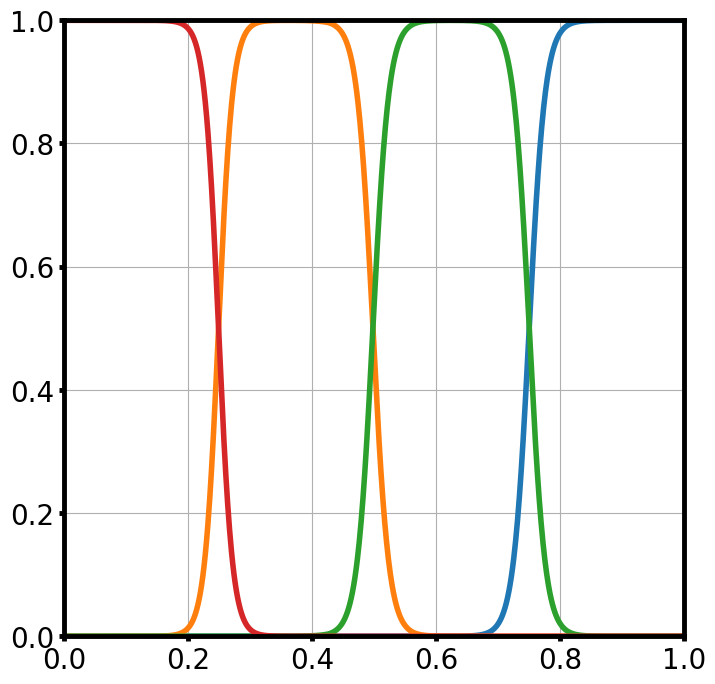

**--- Epoch 7000: Visualizing Partitions ---**

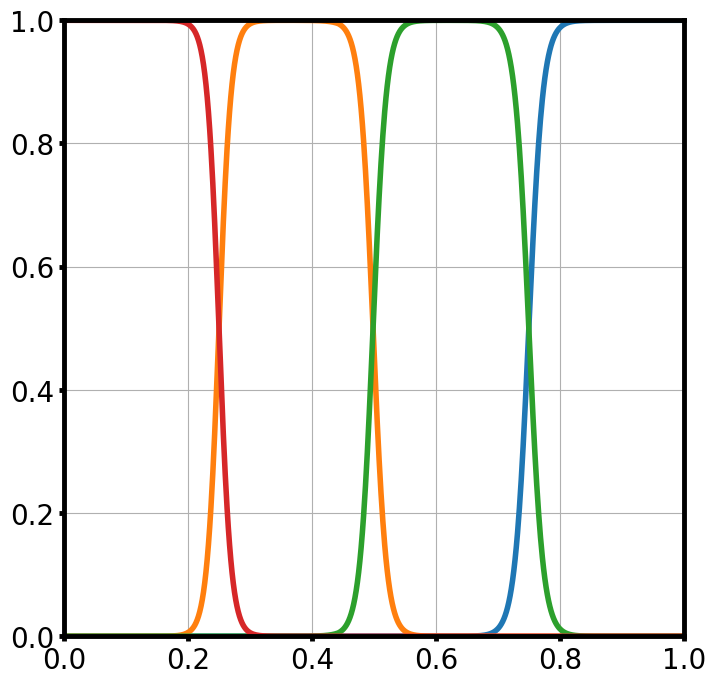

  Epoch   7000 | Loss: 6.567833e-04


**--- Epoch 7500: Visualizing Partitions ---**

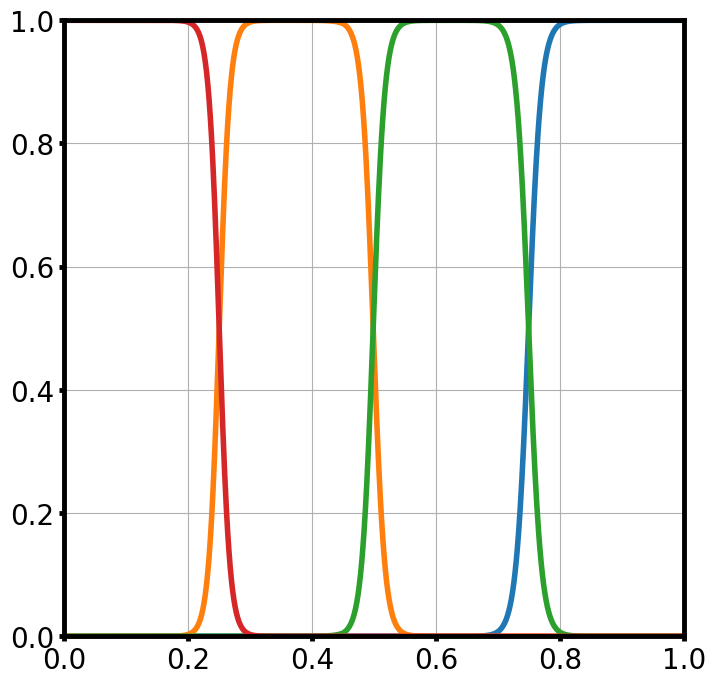

**--- Epoch 8000: Visualizing Partitions ---**

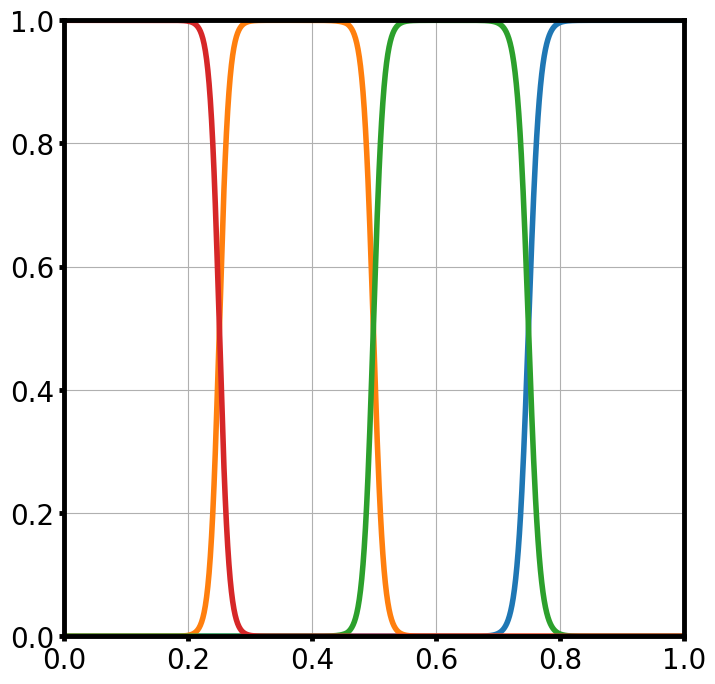

  Epoch   8000 | Loss: 4.451677e-04


**--- Epoch 8500: Visualizing Partitions ---**

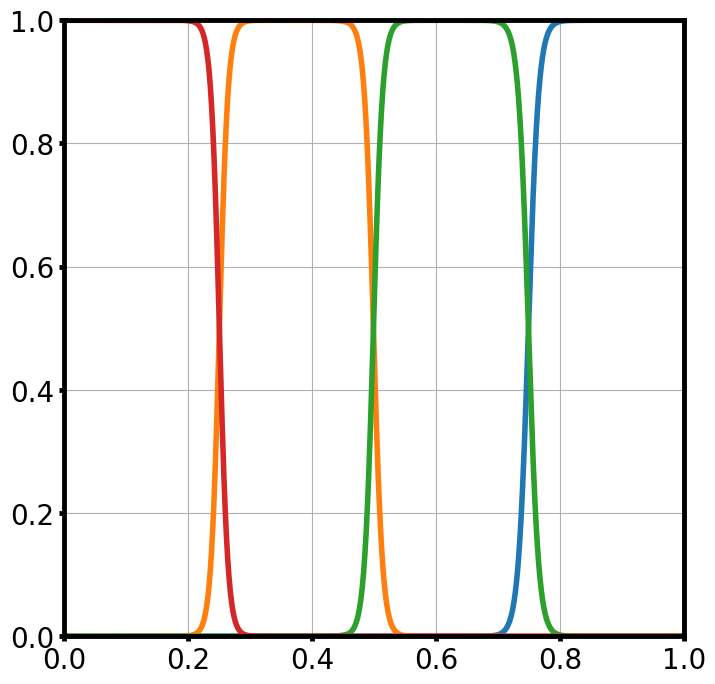

**--- Epoch 9000: Visualizing Partitions ---**

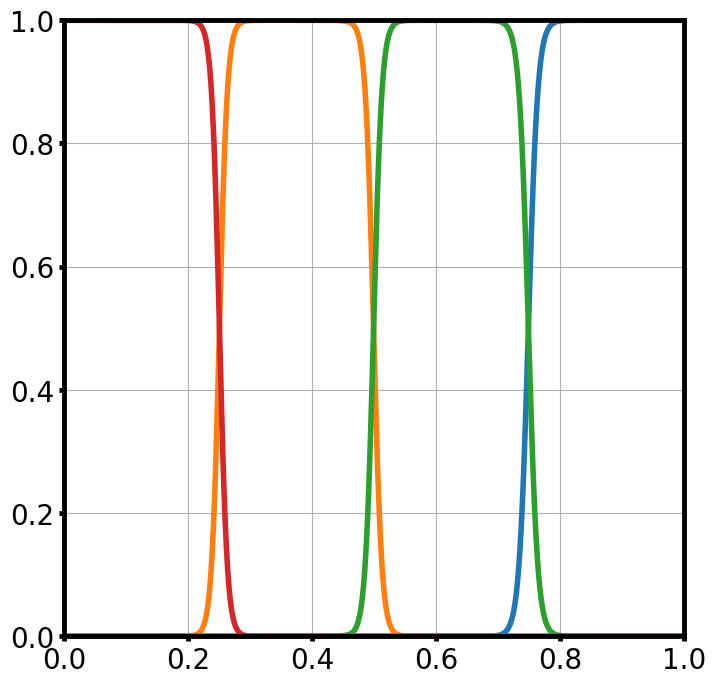

  Epoch   9000 | Loss: 3.478708e-04


**--- Epoch 9500: Visualizing Partitions ---**

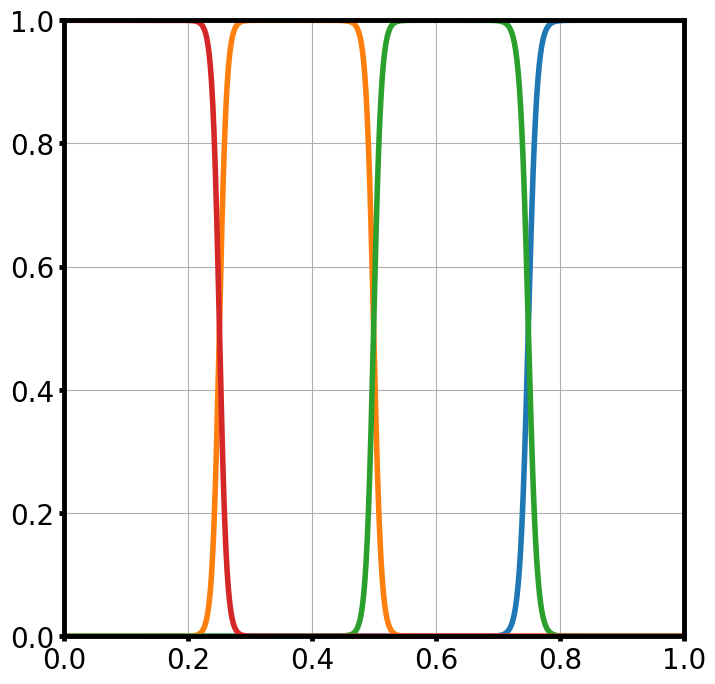

**--- Final Result for k=2 ---**

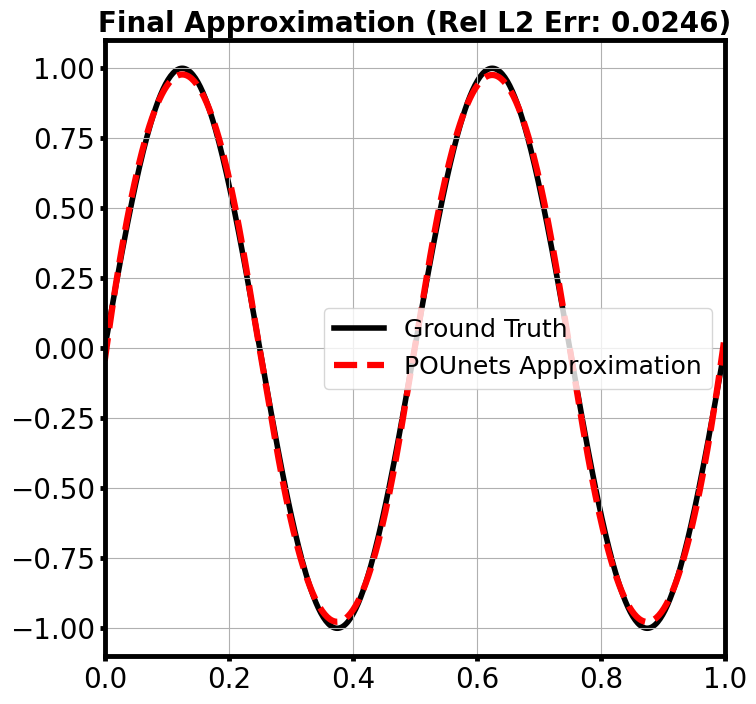

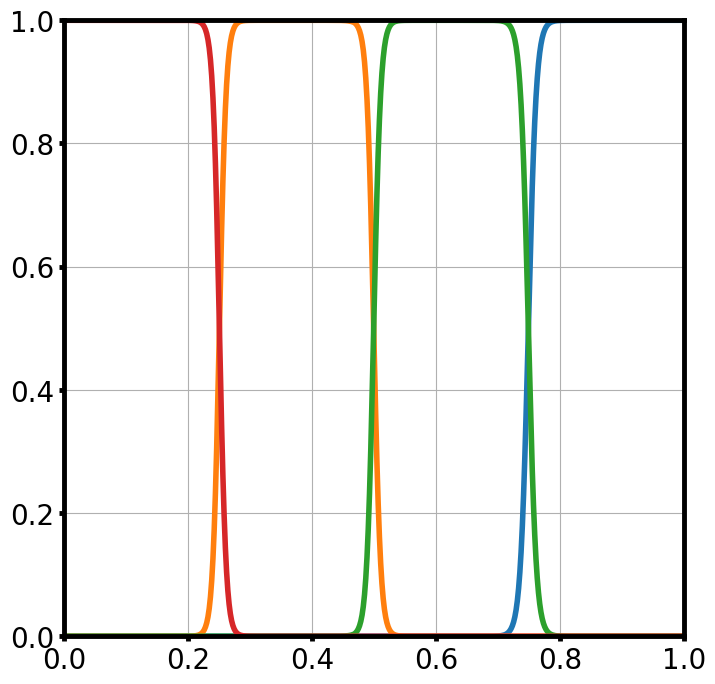

In [ ]:
NET_TAG = "mlp"
DIM = 1
EPOCHS = 10000
N_EXPERTS = 4
k_val = 2 # Frequency parameter for the sine wave
VIZ_INTERVAL = 500
POLY_DEGREE = 2
HIDDEN_LAYERS = (16, 16)
LEARNING_RATE = 1e-3
LAM_INIT = 0
RHO = 1.0
N_STAG = 200

display(Markdown(f'### 1D {NET_TAG.upper()} Experiment (sin(2πkx), k={k_val}, degree={POLY_DEGREE})'))

key, data_key = random.split(key)
x_train = jnp.linspace(0, 1, 1000)[:, None]
y_train = _sin_func_1d(x_train, k=k_val)
net = MLPPOUNet(input_dim=DIM, num_experts=N_EXPERTS, hidden=HIDDEN_LAYERS, key=key)
params = net.init_params()

display(Markdown(f"**--- Initial Partitions (Epoch 0) ---**"))
x_viz_init = jnp.linspace(0, 1, 500)[:, None]
fig_initial = viz_partitions(net, params, x_viz_init)
if fig_initial:
    plt.show(fig_initial)

lsgd_cfg = LSGDConfig(n_epochs=EPOCHS, viz_interval=VIZ_INTERVAL, lr=LEARNING_RATE, 
                          lam_init=LAM_INIT, rho=RHO, n_stag=N_STAG, poly_degree=POLY_DEGREE)
final_params = run_lsgd(net, params, x_train, y_train, lsgd_cfg)

display(Markdown(f"**--- Final Result for k={k_val} ---**"))
x_viz = jnp.linspace(0, 1, 500)[:, None]
y_viz = _sin_func_1d(x_viz, k=k_val)
fig_approx = viz_final(net, final_params, x_viz, y_viz, POLY_DEGREE)
if fig_approx:
    plt.show(fig_approx)
fig_part = viz_partitions(net, final_params, x_viz)
if fig_part:
    plt.show(fig_part)

### 1D MLP Experiment (sin(2πkx), k=4, degree=2)

**--- Initial Partitions (Epoch 0) ---**

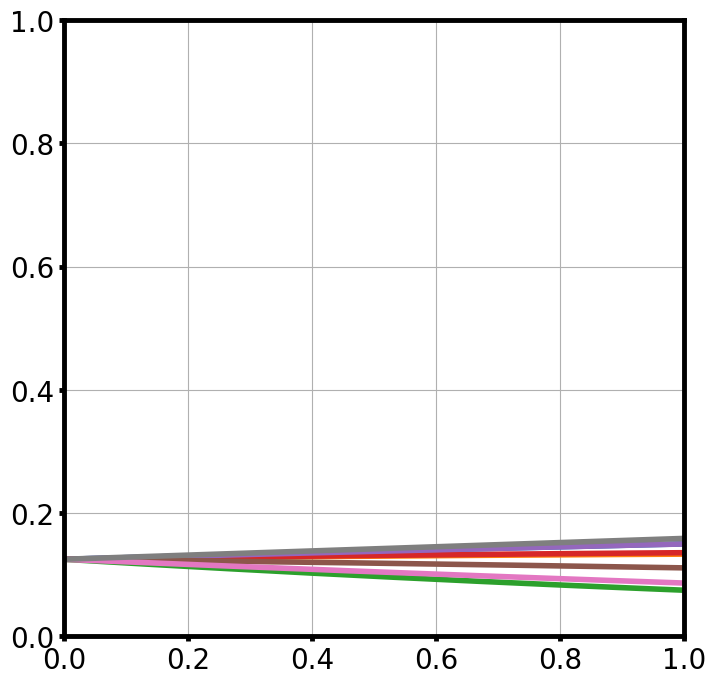

  Epoch      0 | Loss: 4.803029e-01


KeyboardInterrupt: 

In [25]:
NET_TAG = "mlp"
DIM = 1
EPOCHS = 30000
N_EXPERTS = 8
k_val = 4 # Frequency parameter for the sine wave
VIZ_INTERVAL = 15000
POLY_DEGREE = 2
HIDDEN_LAYERS = (4,4)
LEARNING_RATE = 1e-4
LAM_INIT = 0.0
RHO = 1.0
N_STAG = 300

display(Markdown(f'### 1D {NET_TAG.upper()} Experiment (sin(2πkx), k={k_val}, degree={POLY_DEGREE})'))

key, data_key = random.split(key)
x_train = jnp.linspace(0, 1, 1000)[:, None]
y_train = _sin_func_1d(x_train, k=k_val)
net = MLPPOUNet(input_dim=DIM, num_experts=N_EXPERTS, hidden=HIDDEN_LAYERS, key=key)
params = net.init_params()

display(Markdown(f"**--- Initial Partitions (Epoch 0) ---**"))
x_viz_init = jnp.linspace(0, 1, 500)[:, None]
fig_initial = viz_partitions(net, params, x_viz_init)
if fig_initial:
    plt.show(fig_initial)

lsgd_cfg = LSGDConfig(n_epochs=EPOCHS, viz_interval=VIZ_INTERVAL, lr=LEARNING_RATE, 
                          lam_init=LAM_INIT, rho=RHO, n_stag=N_STAG, poly_degree=POLY_DEGREE)
final_params = run_lsgd(net, params, x_train, y_train, lsgd_cfg)

display(Markdown(f"**--- Final Result for k={k_val} ---**"))
x_viz = jnp.linspace(0, 1, 500)[:, None]
y_viz = _sin_func_1d(x_viz, k=k_val)
fig_approx = viz_final(net, final_params, x_viz, y_viz, POLY_DEGREE)
if fig_approx:
    plt.show(fig_approx)
fig_part = viz_partitions(net, final_params, x_viz)
if fig_part:
    plt.show(fig_part)

### 2D RBF Experiment (degree=2)

**--- Initial Partitions (Epoch 0) ---**

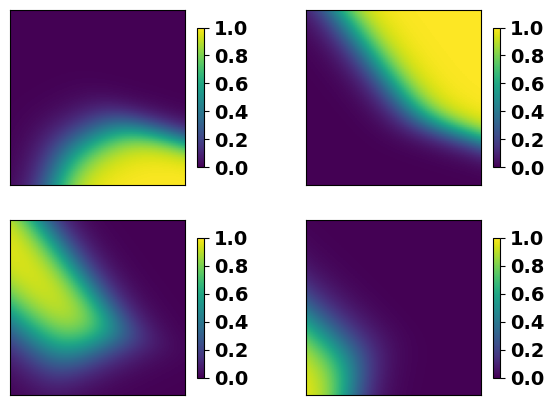

  Epoch      0 | Loss: 7.352648e-02
  Epoch   1000 | Loss: 6.713242e-03
  Epoch   2000 | Loss: 6.663595e-03


**--- Epoch 2500: Visualizing Partitions ---**

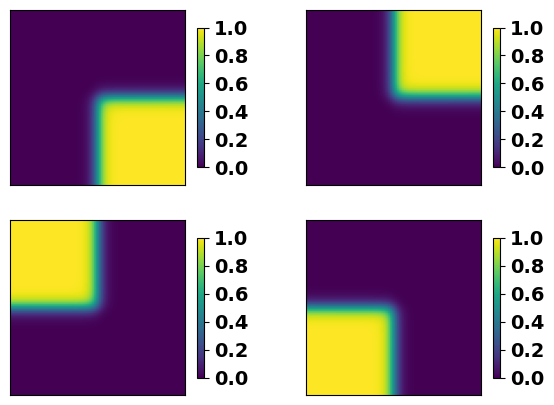

  Epoch   3000 | Loss: 6.661659e-03
  Epoch   4000 | Loss: 6.661653e-03


**--- Epoch 5000: Visualizing Partitions ---**

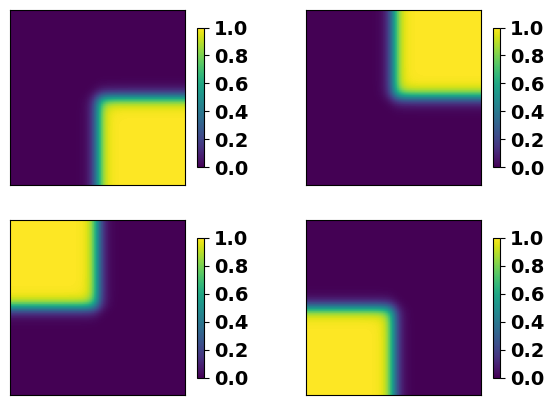

  Epoch   5000 | Loss: 6.661653e-03
  Epoch   6000 | Loss: 6.661653e-03
  Epoch   7000 | Loss: 6.661654e-03


**--- Epoch 7500: Visualizing Partitions ---**

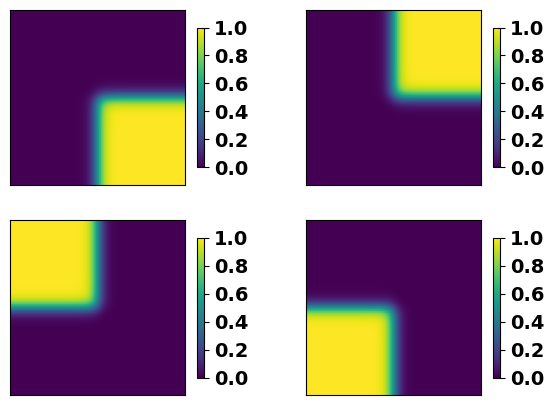

  Epoch   8000 | Loss: 6.661653e-03
  Epoch   9000 | Loss: 6.661653e-03


**--- Final Result ---**

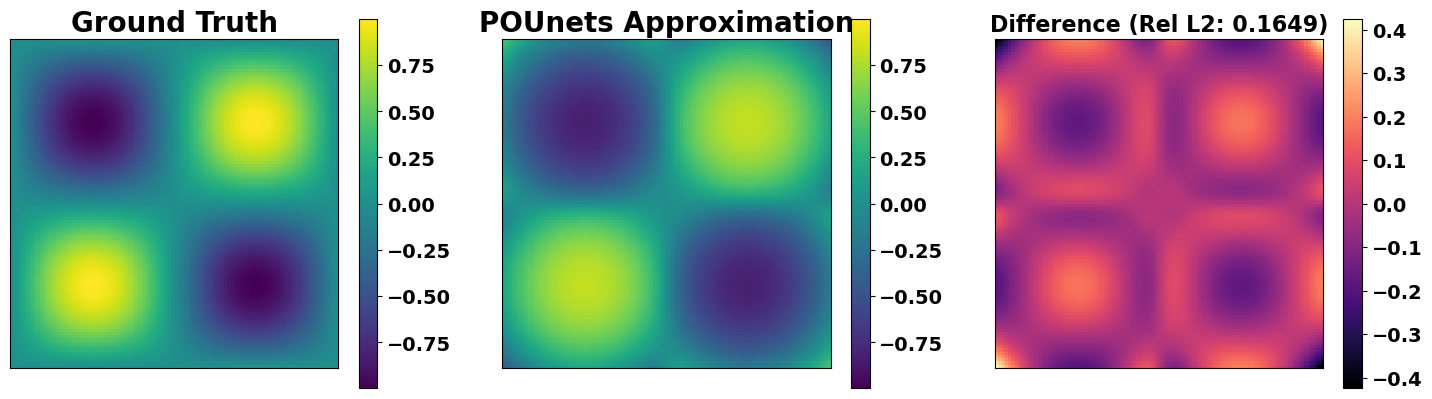

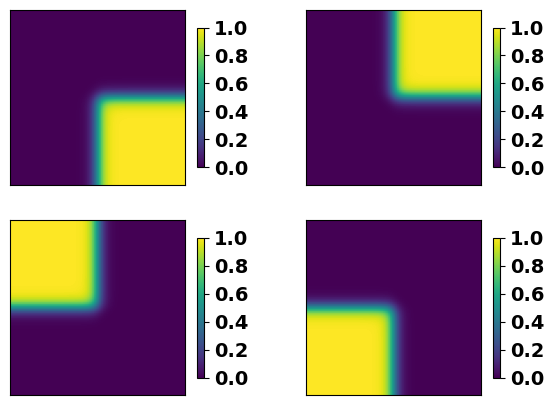

In [ ]:
NET_TAG = "rbf"
DIM = 2
EPOCHS = 10000
N_EXPERTS = 4 # 4x4 
VIZ_INTERVAL = 2500
POLY_DEGREE = 2 # Use 1 for linear, 2 for quadratic

LEARNING_RATE = 1e-3
LAM_INIT = 0
RHO = 1.0
N_STAG = 100
key=jax.random.PRNGKey(1)
display(Markdown(f'### 2D {NET_TAG.upper()} Experiment (degree={POLY_DEGREE})'))

# 1. Data and Model Setup
n_points_per_axis = 100
xs = jnp.linspace(0, 1, n_points_per_axis)
xx, yy = jnp.meshgrid(xs, xs)
x_train = jnp.stack([xx.ravel(), yy.ravel()], axis=-1)
y_train = _sinsin_func_2d(x_train)
net = RBFPOUNet(input_dim=DIM, num_centers=N_EXPERTS, key=key)
params = net.init_params()

display(Markdown(f"**--- Initial Partitions (Epoch 0) ---**"))
fig_initial = viz_partitions(net, params, x_train)
if fig_initial:
    fig_initial.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_{N_EXPERTS}exp_initial_partitions.png")
    plt.show(fig_initial)


lsgd_cfg = LSGDConfig(n_epochs=EPOCHS, viz_interval=VIZ_INTERVAL, lr=LEARNING_RATE,
                      lam_init=LAM_INIT, rho=RHO, n_stag=N_STAG, poly_degree=POLY_DEGREE)
final_params = run_lsgd(net, params, x_train, y_train, lsgd_cfg)

#VIS
display(Markdown(f"**--- Final Result ---**"))

fig_approx = viz_final(net, final_params, x_train, y_train, POLY_DEGREE)
if fig_approx:
    fig_approx.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_{N_EXPERTS}exp_final_approx.png")
    plt.show(fig_approx)
    
fig_part = viz_partitions(net, final_params, x_train)
if fig_part:
    fig_part.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_{N_EXPERTS}exp_final_partitions.png")
    plt.show(fig_part)

### 2D MLP Experiment (sin(2πx)sin(2πy), degree=2)

**--- Initial Partitions (Epoch 0) ---**

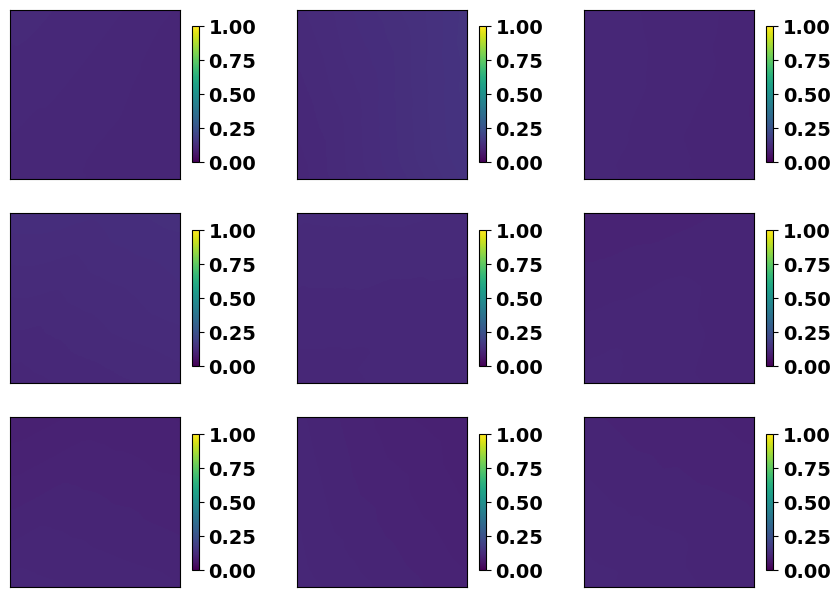

  Epoch      0 | Loss: 1.598522e-01
  Epoch   1000 | Loss: 3.300913e-03
  Epoch   2000 | Loss: 2.050315e-03


**--- Epoch 2500: Visualizing Partitions ---**

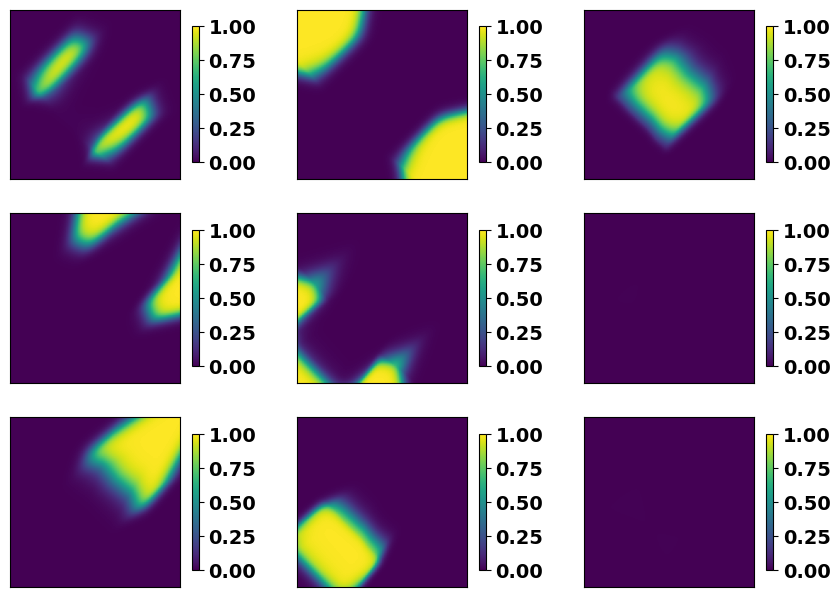

  Epoch   3000 | Loss: 1.977365e-03
  Epoch   4000 | Loss: 1.708329e-03


**--- Epoch 5000: Visualizing Partitions ---**

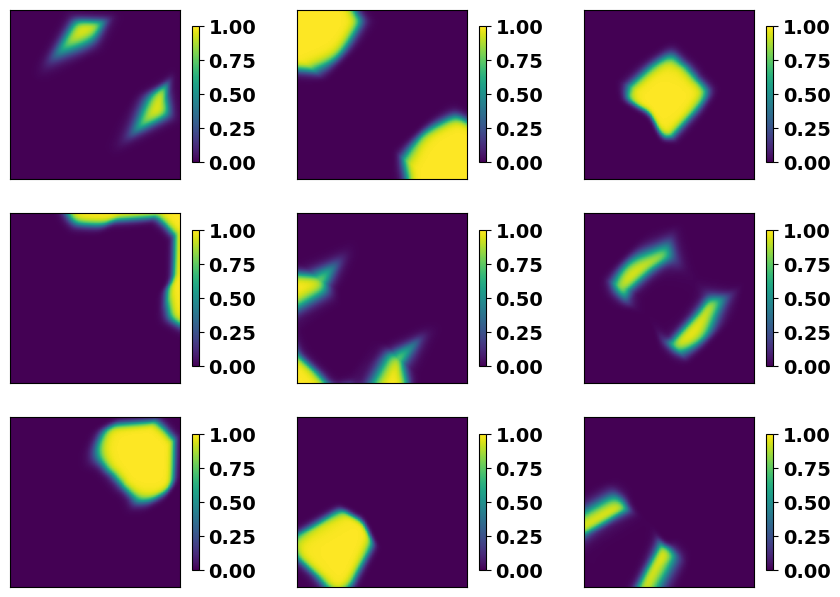

  Epoch   5000 | Loss: 1.045710e-03
  Epoch   6000 | Loss: 8.926629e-04
  Epoch   7000 | Loss: 8.328083e-04


**--- Epoch 7500: Visualizing Partitions ---**

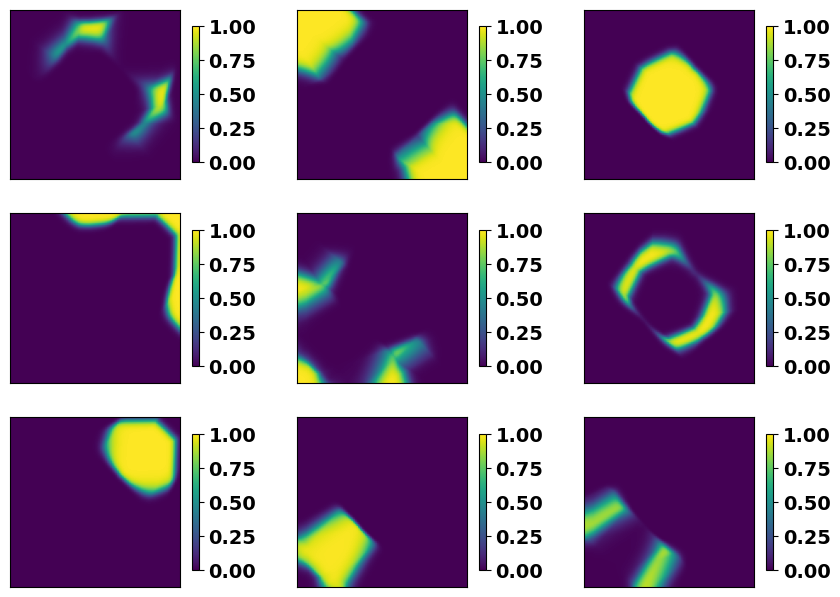

  Epoch   8000 | Loss: 7.849412e-04
  Epoch   9000 | Loss: 7.499846e-04


**--- Final Result ---**

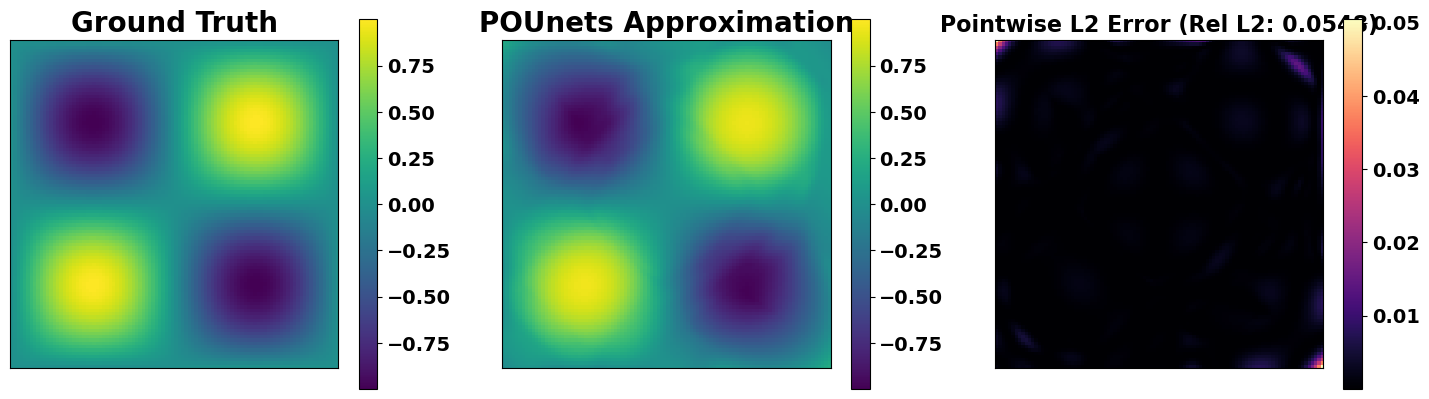

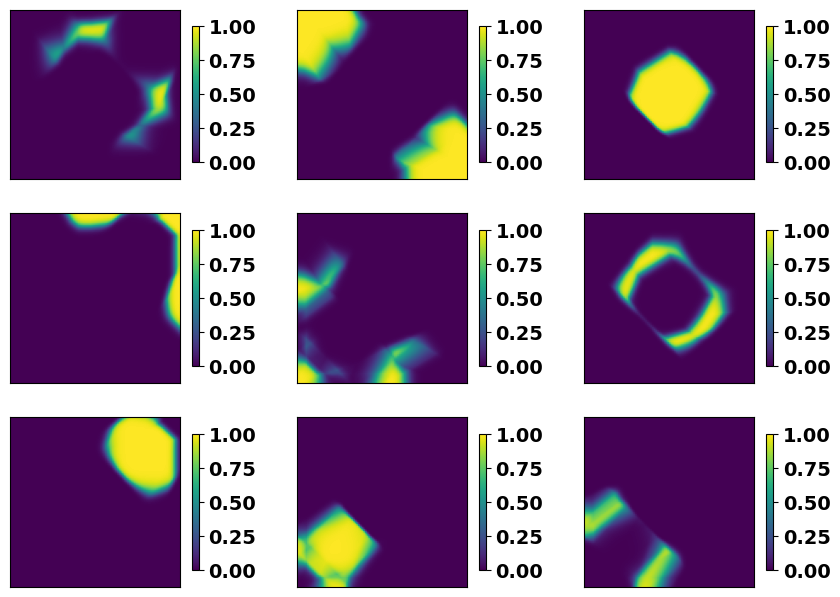

In [ ]:
NET_TAG = "mlp"
DIM = 2
EPOCHS = 10000
N_EXPERTS = 9
VIZ_INTERVAL = 2500
POLY_DEGREE = 2 # Use 1 for linear, 2 for quadratic
# --- Network Architecture ---
HIDDEN_LAYERS = (64,64)
# --- Hyperparameters to Tune ---
LEARNING_RATE = 1e-3
LAM_INIT = 0
RHO = 1.0
N_STAG = 100


display(Markdown(f'### 2D {NET_TAG.upper()} Experiment (sin(2πx)sin(2πy), degree={POLY_DEGREE})'))


n_points_per_axis = 100
xs = jnp.linspace(0, 1, n_points_per_axis)
xx, yy = jnp.meshgrid(xs, xs)
x_train = jnp.stack([xx.ravel(), yy.ravel()], axis=-1)
y_train = _sinsin_func_2d(x_train)
net = MLPPOUNet(input_dim=DIM, num_experts=N_EXPERTS, hidden=HIDDEN_LAYERS, key=key)
params = net.init_params()


display(Markdown(f"**--- Initial Partitions (Epoch 0) ---**"))
xs_viz = jnp.linspace(0, 1, n_points_per_axis)
xx_viz, yy_viz = jnp.meshgrid(xs_viz, xs_viz)
x_viz = jnp.stack([xx_viz.ravel(), yy_viz.ravel()], axis=-1)
fig_initial = viz_partitions(net, params, x_viz)
if fig_initial:
    fig_initial.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_{N_EXPERTS}exp_sinsin_initial_partitions.png")
    plt.show(fig_initial)


lsgd_cfg = LSGDConfig(n_epochs=EPOCHS, viz_interval=VIZ_INTERVAL, lr=LEARNING_RATE,
                      lam_init=LAM_INIT, rho=RHO, n_stag=N_STAG, poly_degree=POLY_DEGREE)
final_params = run_lsgd(net, params, x_train, y_train, lsgd_cfg)


display(Markdown(f"**--- Final Result ---**"))
y_viz = _sinsin_func_2d(x_viz)
fig_approx = viz_final(net, final_params, x_viz, y_viz, POLY_DEGREE)
if fig_approx:
    fig_approx.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_{N_EXPERTS}exp_sinsin_final_approx.png")
    plt.show(fig_approx)
    
fig_part = viz_partitions(net, final_params, x_viz)
if fig_part:
    fig_part.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_{N_EXPERTS}exp_sinsin_final_partitions.png")
    plt.show(fig_part)

### 2D MLP Experiment (sin(2πx)sin(2πy), degree=2)

**--- Initial Partitions (Epoch 0) ---**

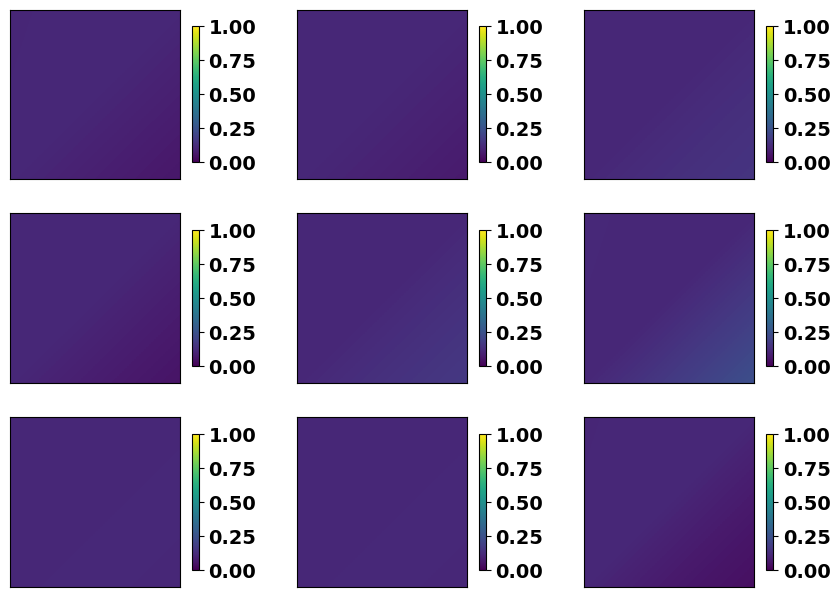

  Epoch      0 | Loss: 1.591687e-01


KeyboardInterrupt: 

In [199]:
NET_TAG = "mlp"
DIM = 2
EPOCHS = 10000
N_EXPERTS = 9
VIZ_INTERVAL = 2500
POLY_DEGREE = 2 # Use 1 for linear, 2 for quadratic
# --- Network Architecture ---
HIDDEN_LAYERS = (2,2)
# --- Hyperparameters to Tune ---
LEARNING_RATE = 1e-3
LAM_INIT = 0
RHO = 1.0
N_STAG = 100

# --- Run Experiment ---
display(Markdown(f'### 2D {NET_TAG.upper()} Experiment (sin(2πx)sin(2πy), degree={POLY_DEGREE})'))

# 1. Data and Model Setup
n_points_per_axis = 100
xs = jnp.linspace(0, 1, n_points_per_axis)
xx, yy = jnp.meshgrid(xs, xs)
x_train = jnp.stack([xx.ravel(), yy.ravel()], axis=-1)
y_train = _sinsin_func_2d(x_train)
net = MLPPOUNet(input_dim=DIM, num_experts=N_EXPERTS, hidden=HIDDEN_LAYERS, key=key)
params = net.init_params()

# 2. Initial Visualization (Before Training)
display(Markdown(f"**--- Initial Partitions (Epoch 0) ---**"))
xs_viz = jnp.linspace(0, 1, n_points_per_axis)
xx_viz, yy_viz = jnp.meshgrid(xs_viz, xs_viz)
x_viz = jnp.stack([xx_viz.ravel(), yy_viz.ravel()], axis=-1)
fig_initial = viz_partitions(net, params, x_viz)
if fig_initial:
    fig_initial.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_{N_EXPERTS}exp_sinsin_initial_partitions.png")
    plt.show(fig_initial)

# 3. Training
lsgd_cfg = LSGDConfig(n_epochs=EPOCHS, viz_interval=VIZ_INTERVAL, lr=LEARNING_RATE,
                      lam_init=LAM_INIT, rho=RHO, n_stag=N_STAG, poly_degree=POLY_DEGREE)
final_params = run_lsgd(net, params, x_train, y_train, lsgd_cfg)

# 4. Final Visualization
display(Markdown(f"**--- Final Result ---**"))
y_viz = _sinsin_func_2d(x_viz)
fig_approx = viz_final(net, final_params, x_viz, y_viz, POLY_DEGREE)
if fig_approx:
    fig_approx.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_{N_EXPERTS}exp_sinsin_final_approx.png")
    plt.show(fig_approx)
    
fig_part = viz_partitions(net, final_params, x_viz)
if fig_part:
    fig_part.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_{N_EXPERTS}exp_sinsin_final_partitions.png")
    plt.show(fig_part)

### 2D MLP Experiment (sin(2πx)sin(2πy), degree=2)

**--- Initial Partitions (Epoch 0) ---**

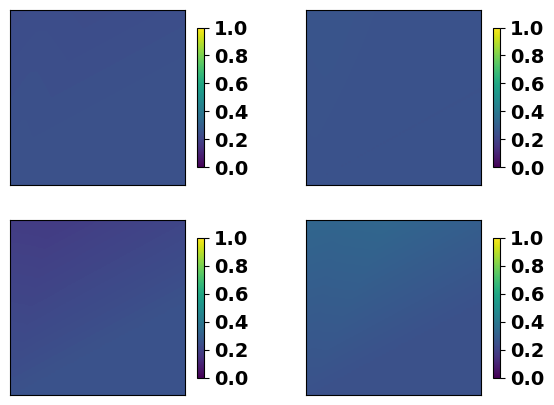

  Epoch      0 | Loss: 1.598359e-01
  Epoch   1000 | Loss: 1.000331e-01
  Epoch   2000 | Loss: 6.096629e-02


**--- Epoch 2500: Visualizing Partitions ---**

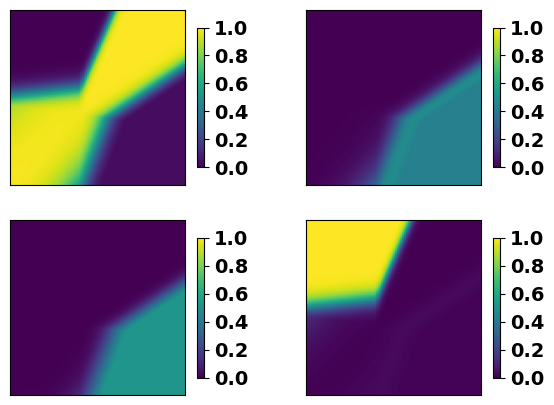

  Epoch   3000 | Loss: 1.640362e-02
  Epoch   4000 | Loss: 6.451436e-03


**--- Epoch 5000: Visualizing Partitions ---**

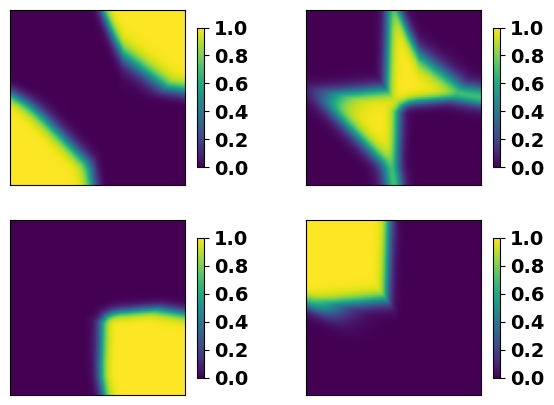

  Epoch   5000 | Loss: 6.112038e-03
  Epoch   6000 | Loss: 6.017926e-03
  Epoch   7000 | Loss: 5.684960e-03


**--- Epoch 7500: Visualizing Partitions ---**

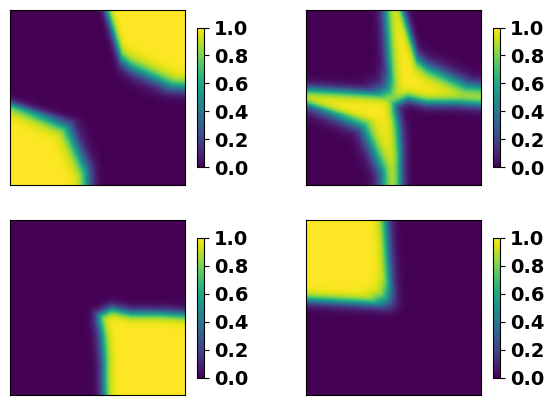

  Epoch   8000 | Loss: 5.614426e-03
  Epoch   9000 | Loss: 5.584424e-03


**--- Final Result ---**

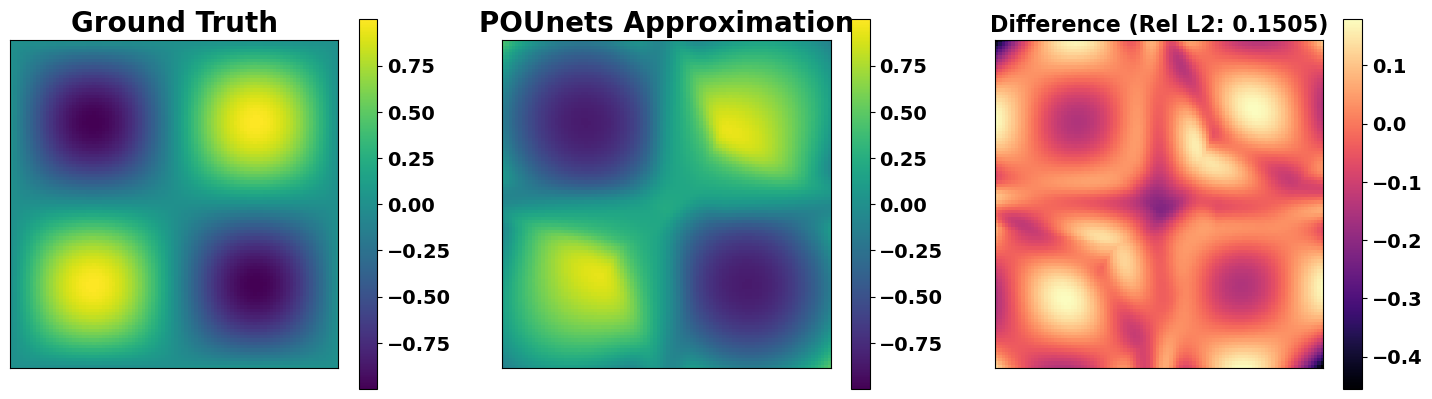

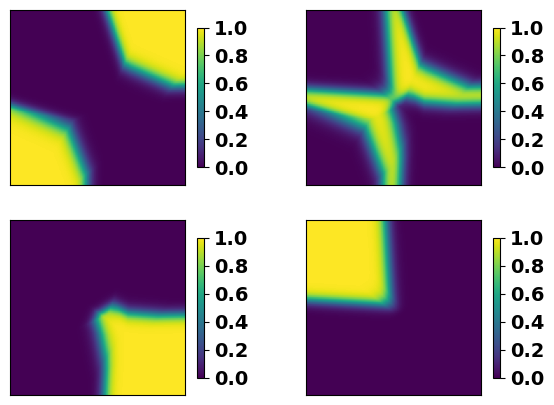

In [21]:
NET_TAG = "mlp"
DIM = 2
EPOCHS = 10000
N_EXPERTS = 4
VIZ_INTERVAL = 2500
POLY_DEGREE = 2 # Use 1 for linear, 2 for quadratic
# --- Network Architecture ---
HIDDEN_LAYERS = (8,8)
# --- Hyperparameters to Tune ---
LEARNING_RATE = 0.001
LAM_INIT = 0
RHO = 1.0
N_STAG = 100

# --- Run Experiment ---
display(Markdown(f'### 2D {NET_TAG.upper()} Experiment (sin(2πx)sin(2πy), degree={POLY_DEGREE})'))

# 1. Data and Model Setup
n_points_per_axis = 100
xs = jnp.linspace(0, 1, n_points_per_axis)
xx, yy = jnp.meshgrid(xs, xs)
x_train = jnp.stack([xx.ravel(), yy.ravel()], axis=-1)
y_train = _sinsin_func_2d(x_train)
net = MLPPOUNet(input_dim=DIM, num_experts=N_EXPERTS, hidden=HIDDEN_LAYERS, key=key)
params = net.init_params()

# 2. Initial Visualization (Before Training)
display(Markdown(f"**--- Initial Partitions (Epoch 0) ---**"))
xs_viz = jnp.linspace(0, 1, n_points_per_axis)
xx_viz, yy_viz = jnp.meshgrid(xs_viz, xs_viz)
x_viz = jnp.stack([xx_viz.ravel(), yy_viz.ravel()], axis=-1)
fig_initial = viz_partitions(net, params, x_viz)
if fig_initial:
    fig_initial.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_{N_EXPERTS}exp_sinsin_initial_partitions.png")
    plt.show(fig_initial)

# 3. Training
lsgd_cfg = LSGDConfig(n_epochs=EPOCHS, viz_interval=VIZ_INTERVAL, lr=LEARNING_RATE,
                      lam_init=LAM_INIT, rho=RHO, n_stag=N_STAG, poly_degree=POLY_DEGREE)
final_params = run_lsgd(net, params, x_train, y_train, lsgd_cfg)

# 4. Final Visualization
display(Markdown(f"**--- Final Result ---**"))
y_viz = _sinsin_func_2d(x_viz)
fig_approx = viz_final(net, final_params, x_viz, y_viz, POLY_DEGREE)
if fig_approx:
    fig_approx.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_{N_EXPERTS}exp_sinsin_final_approx.png")
    plt.show(fig_approx)
    
fig_part = viz_partitions(net, final_params, x_viz)
if fig_part:
    fig_part.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_{N_EXPERTS}exp_sinsin_final_partitions.png")
    plt.show(fig_part)

### 2D SEP_MLP Experiment (sin(2πx)sin(2πy), degree=2)

**--- Initial Partitions (Epoch 0) ---**

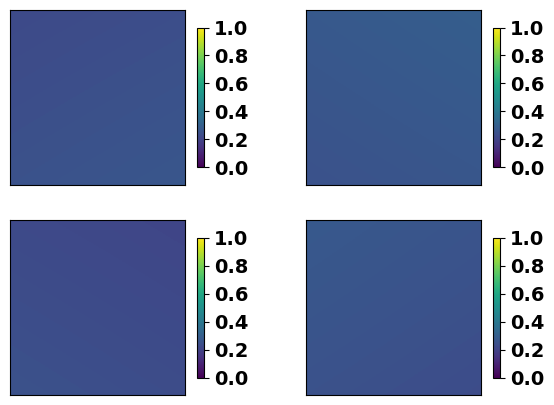

  Epoch      0 | Loss: 1.598641e-01
  Epoch   1000 | Loss: 7.252587e-03
  Epoch   2000 | Loss: 6.759266e-03


**--- Epoch 2500: Visualizing Partitions ---**

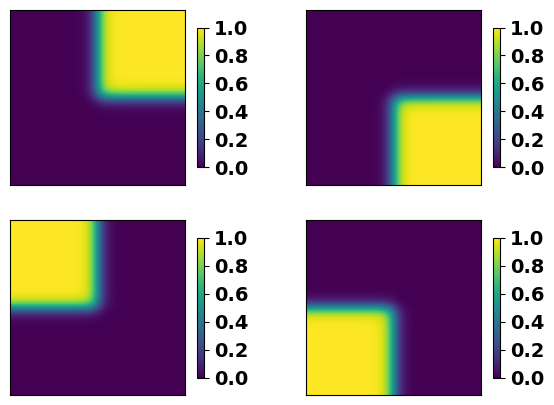

  Epoch   3000 | Loss: 6.689841e-03
  Epoch   4000 | Loss: 6.674459e-03


**--- Epoch 5000: Visualizing Partitions ---**

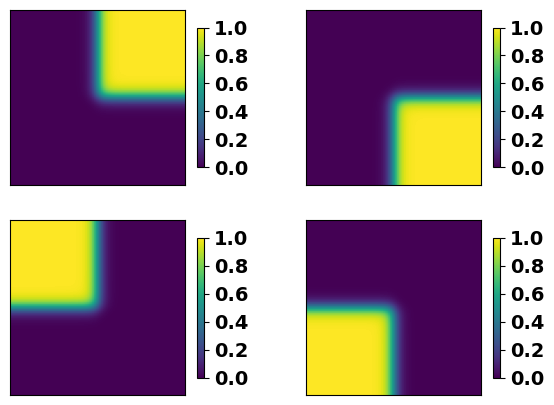

  Epoch   5000 | Loss: 6.668719e-03
  Epoch   6000 | Loss: 6.665592e-03
  Epoch   7000 | Loss: 6.663954e-03


**--- Epoch 7500: Visualizing Partitions ---**

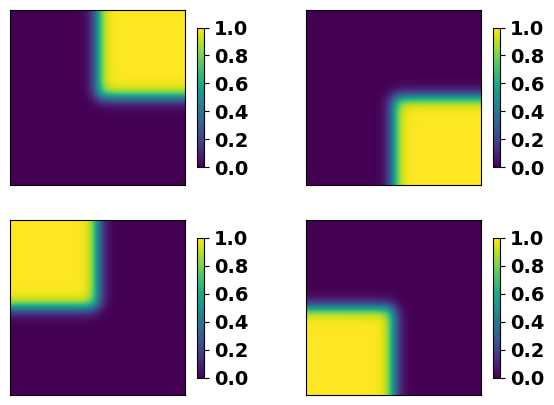

  Epoch   8000 | Loss: 6.663019e-03
  Epoch   9000 | Loss: 6.662473e-03


**--- Final Result ---**

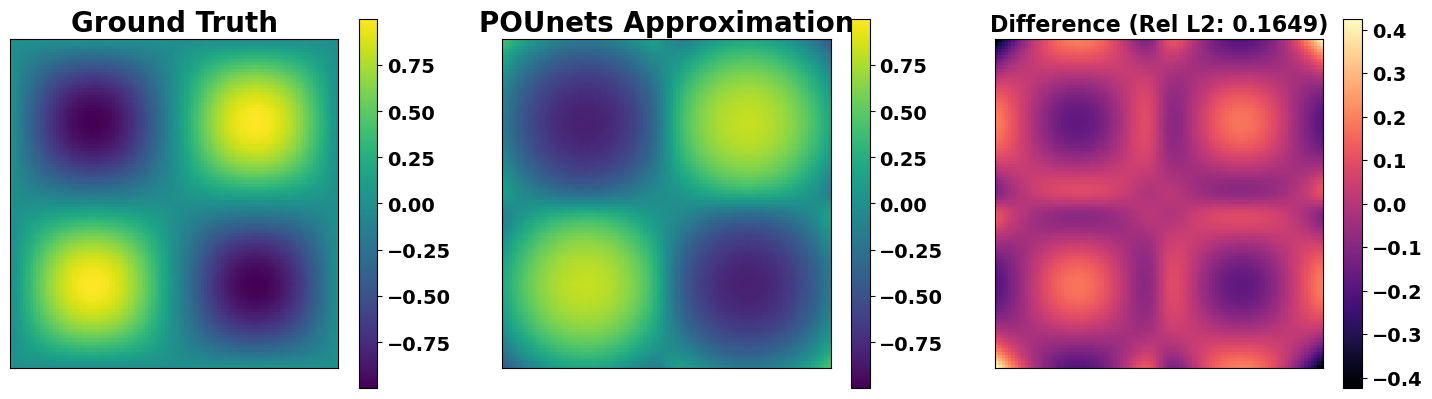

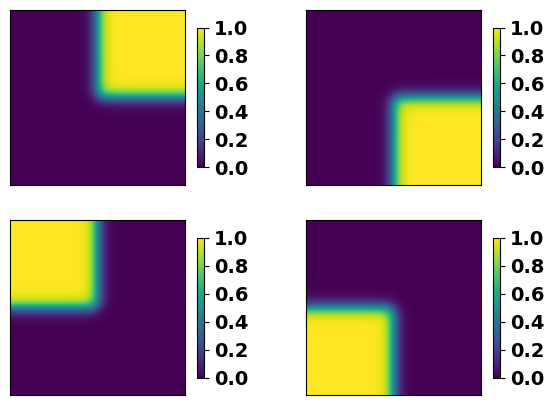

In [ ]:
NET_TAG = "sep_mlp"
DIM = 2
EPOCHS = 10000
NX_EXPERTS = 2
NY_EXPERTS = 2
VIZ_INTERVAL = 2500
POLY_DEGREE = 2 # 1, 2, or 3

HIDDEN_LAYERS = (8, 8)

LEARNING_RATE = 1e-3
LAM_INIT = 0
RHO = 1.0
N_STAG = 200


display(Markdown(f'### 2D {NET_TAG.upper()} Experiment (sin(2πx)sin(2πy), degree={POLY_DEGREE})'))


n_points_per_axis = 100
xs = jnp.linspace(0, 1, n_points_per_axis)
xx, yy = jnp.meshgrid(xs, xs)
x_train = jnp.stack([xx.ravel(), yy.ravel()], axis=-1)
y_train = _sinsin_func_2d(x_train)
net = SepMLPPOUNet(input_dim=DIM, nx=NX_EXPERTS, ny=NY_EXPERTS, hidden=HIDDEN_LAYERS, key=key)
params = net.init_params()

display(Markdown(f"**--- Initial Partitions (Epoch 0) ---**"))
xs_viz = jnp.linspace(0, 1, n_points_per_axis)
xx_viz, yy_viz = jnp.meshgrid(xs_viz, xs_viz)
x_viz = jnp.stack([xx_viz.ravel(), yy_viz.ravel()], axis=-1)
fig_initial = viz_partitions(net, params, x_viz)
if fig_initial:
    fig_initial.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_{NX_EXPERTS}x{NY_EXPERTS}exp_sinsin_initial_partitions.png")
    plt.show(fig_initial)


lsgd_cfg = LSGDConfig(n_epochs=EPOCHS, viz_interval=VIZ_INTERVAL, lr=LEARNING_RATE,
                      lam_init=LAM_INIT, rho=RHO, n_stag=N_STAG, poly_degree=POLY_DEGREE)
final_params = run_lsgd(net, params, x_train, y_train, lsgd_cfg)


display(Markdown(f"**--- Final Result ---**"))
y_viz = _sinsin_func_2d(x_viz)
fig_approx = viz_final(net, final_params, x_viz, y_viz, POLY_DEGREE)
if fig_approx:
    fig_approx.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_{NX_EXPERTS}x{NY_EXPERTS}exp_sinsin_final_approx.png")
    plt.show(fig_approx)
    
fig_part = viz_partitions(net, final_params, x_viz)
if fig_part:
    fig_part.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_{NX_EXPERTS}x{NY_EXPERTS}exp_sinsin_final_partitions.png")
    plt.show(fig_part)

### 2D SEP_RBF Experiment (sin(2πx)sin(2πy), degree=2)

**--- Initial Partitions (Epoch 0) ---**

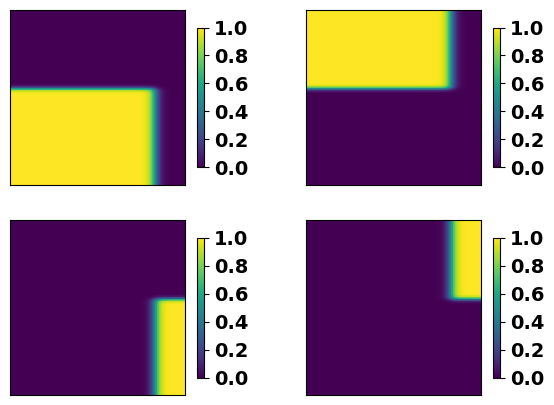

  Epoch      0 | Loss: 6.515968e-02
  Epoch   1000 | Loss: 6.724426e-03
  Epoch   2000 | Loss: 6.667189e-03


**--- Epoch 2500: Visualizing Partitions ---**

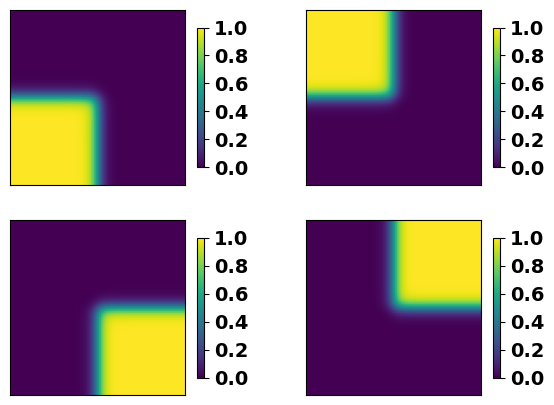

  Epoch   3000 | Loss: 6.661917e-03
  Epoch   4000 | Loss: 6.661655e-03


**--- Epoch 5000: Visualizing Partitions ---**

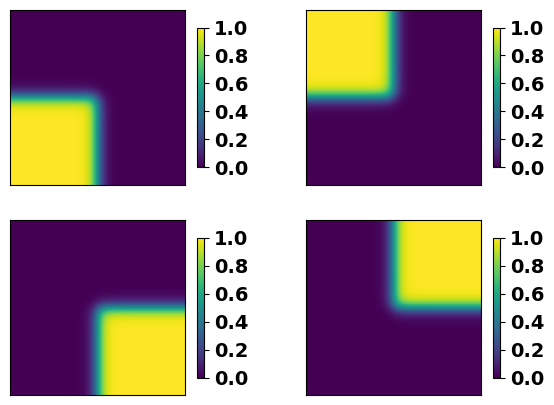

  Epoch   5000 | Loss: 6.661653e-03
  Epoch   6000 | Loss: 6.661653e-03
  Epoch   7000 | Loss: 6.661653e-03


**--- Epoch 7500: Visualizing Partitions ---**

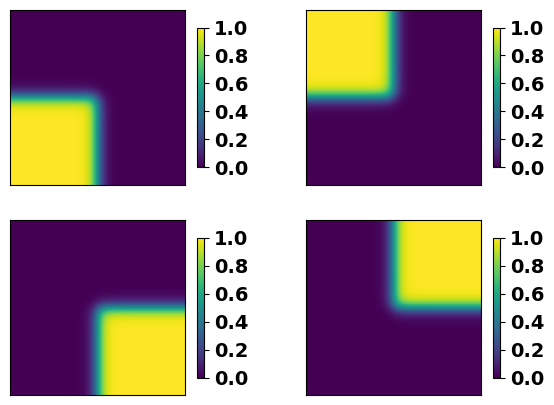

  Epoch   8000 | Loss: 6.661653e-03
  Epoch   9000 | Loss: 6.661653e-03


**--- Final Result ---**

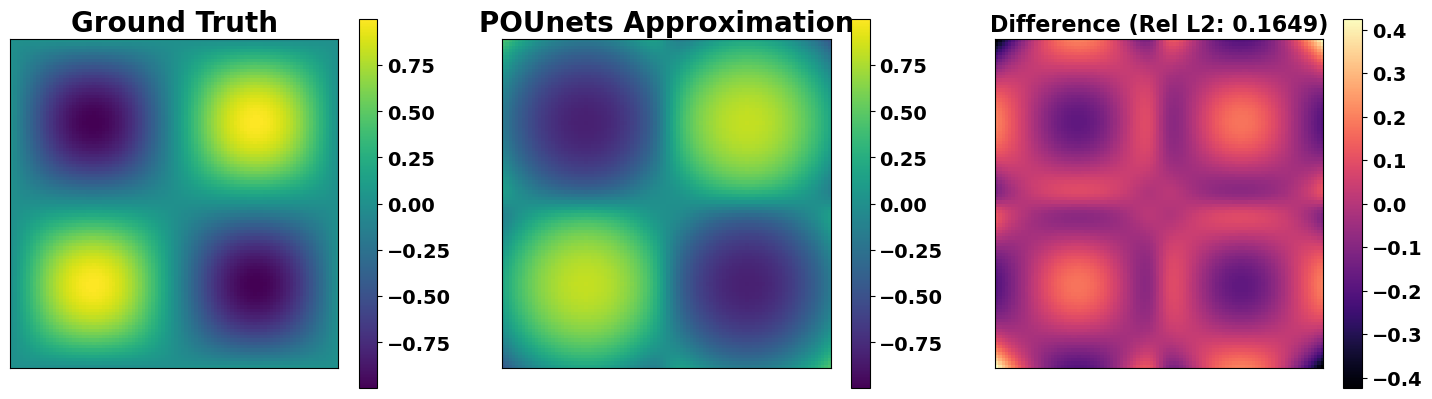

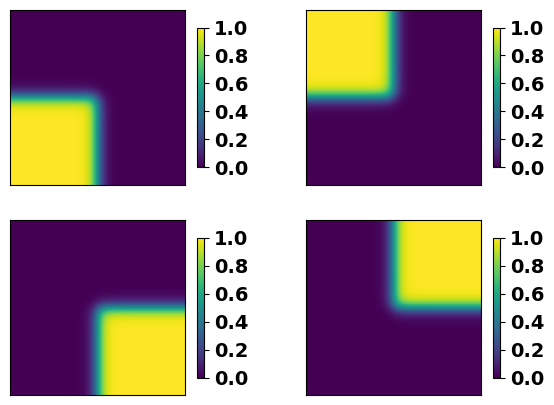

In [20]:
NET_TAG = "sep_rbf"
DIM = 2
EPOCHS = 10000
NX_EXPERTS = 2
NY_EXPERTS = 2
VIZ_INTERVAL = 2500
POLY_DEGREE = 2 # Use 1, 2, or 3
# --- Hyperparameters to Tune ---
LEARNING_RATE = 1e-3
LAM_INIT = 0
RHO = 1.0
N_STAG = 200

# --- Run Experiment ---
display(Markdown(f'### 2D {NET_TAG.upper()} Experiment (sin(2πx)sin(2πy), degree={POLY_DEGREE})'))

# 1. Data and Model Setup
n_points_per_axis = 100
xs = jnp.linspace(0, 1, n_points_per_axis)
xx, yy = jnp.meshgrid(xs, xs)
x_train = jnp.stack([xx.ravel(), yy.ravel()], axis=-1)
y_train = _sinsin_func_2d(x_train)
net = SepRBFPOUNet(input_dim=DIM, nx=NX_EXPERTS, ny=NY_EXPERTS, key=key)
params = net.init_params()

# 2. Initial Visualization (Before Training)
display(Markdown(f"**--- Initial Partitions (Epoch 0) ---**"))
xs_viz = jnp.linspace(0, 1, n_points_per_axis)
xx_viz, yy_viz = jnp.meshgrid(xs_viz, xs_viz)
x_viz = jnp.stack([xx_viz.ravel(), yy_viz.ravel()], axis=-1)
fig_initial = viz_partitions(net, params, x_viz)
if fig_initial:
    fig_initial.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_{NX_EXPERTS}x{NY_EXPERTS}exp_sinsin_initial_partitions.png")
    plt.show(fig_initial)

# 3. Training
lsgd_cfg = LSGDConfig(n_epochs=EPOCHS, viz_interval=VIZ_INTERVAL, lr=LEARNING_RATE,
                      lam_init=LAM_INIT, rho=RHO, n_stag=N_STAG, poly_degree=POLY_DEGREE)
final_params = run_lsgd(net, params, x_train, y_train, lsgd_cfg)

# 4. Final Visualization
display(Markdown(f"**--- Final Result ---**"))
y_viz = _sinsin_func_2d(x_viz)
fig_approx = viz_final(net, final_params, x_viz, y_viz, POLY_DEGREE)
if fig_approx:
    fig_approx.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_{NX_EXPERTS}x{NY_EXPERTS}exp_sinsin_final_approx.png")
    plt.show(fig_approx)
    
fig_part = viz_partitions(net, final_params, x_viz)
if fig_part:
    fig_part.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_{NX_EXPERTS}x{NY_EXPERTS}exp_sinsin_final_partitions.png")
    plt.show(fig_part)

### 2D RBF Experiment (sin(10πx²)sin(10πy²), degree=2)

**--- Initial Partitions (Epoch 0) ---**

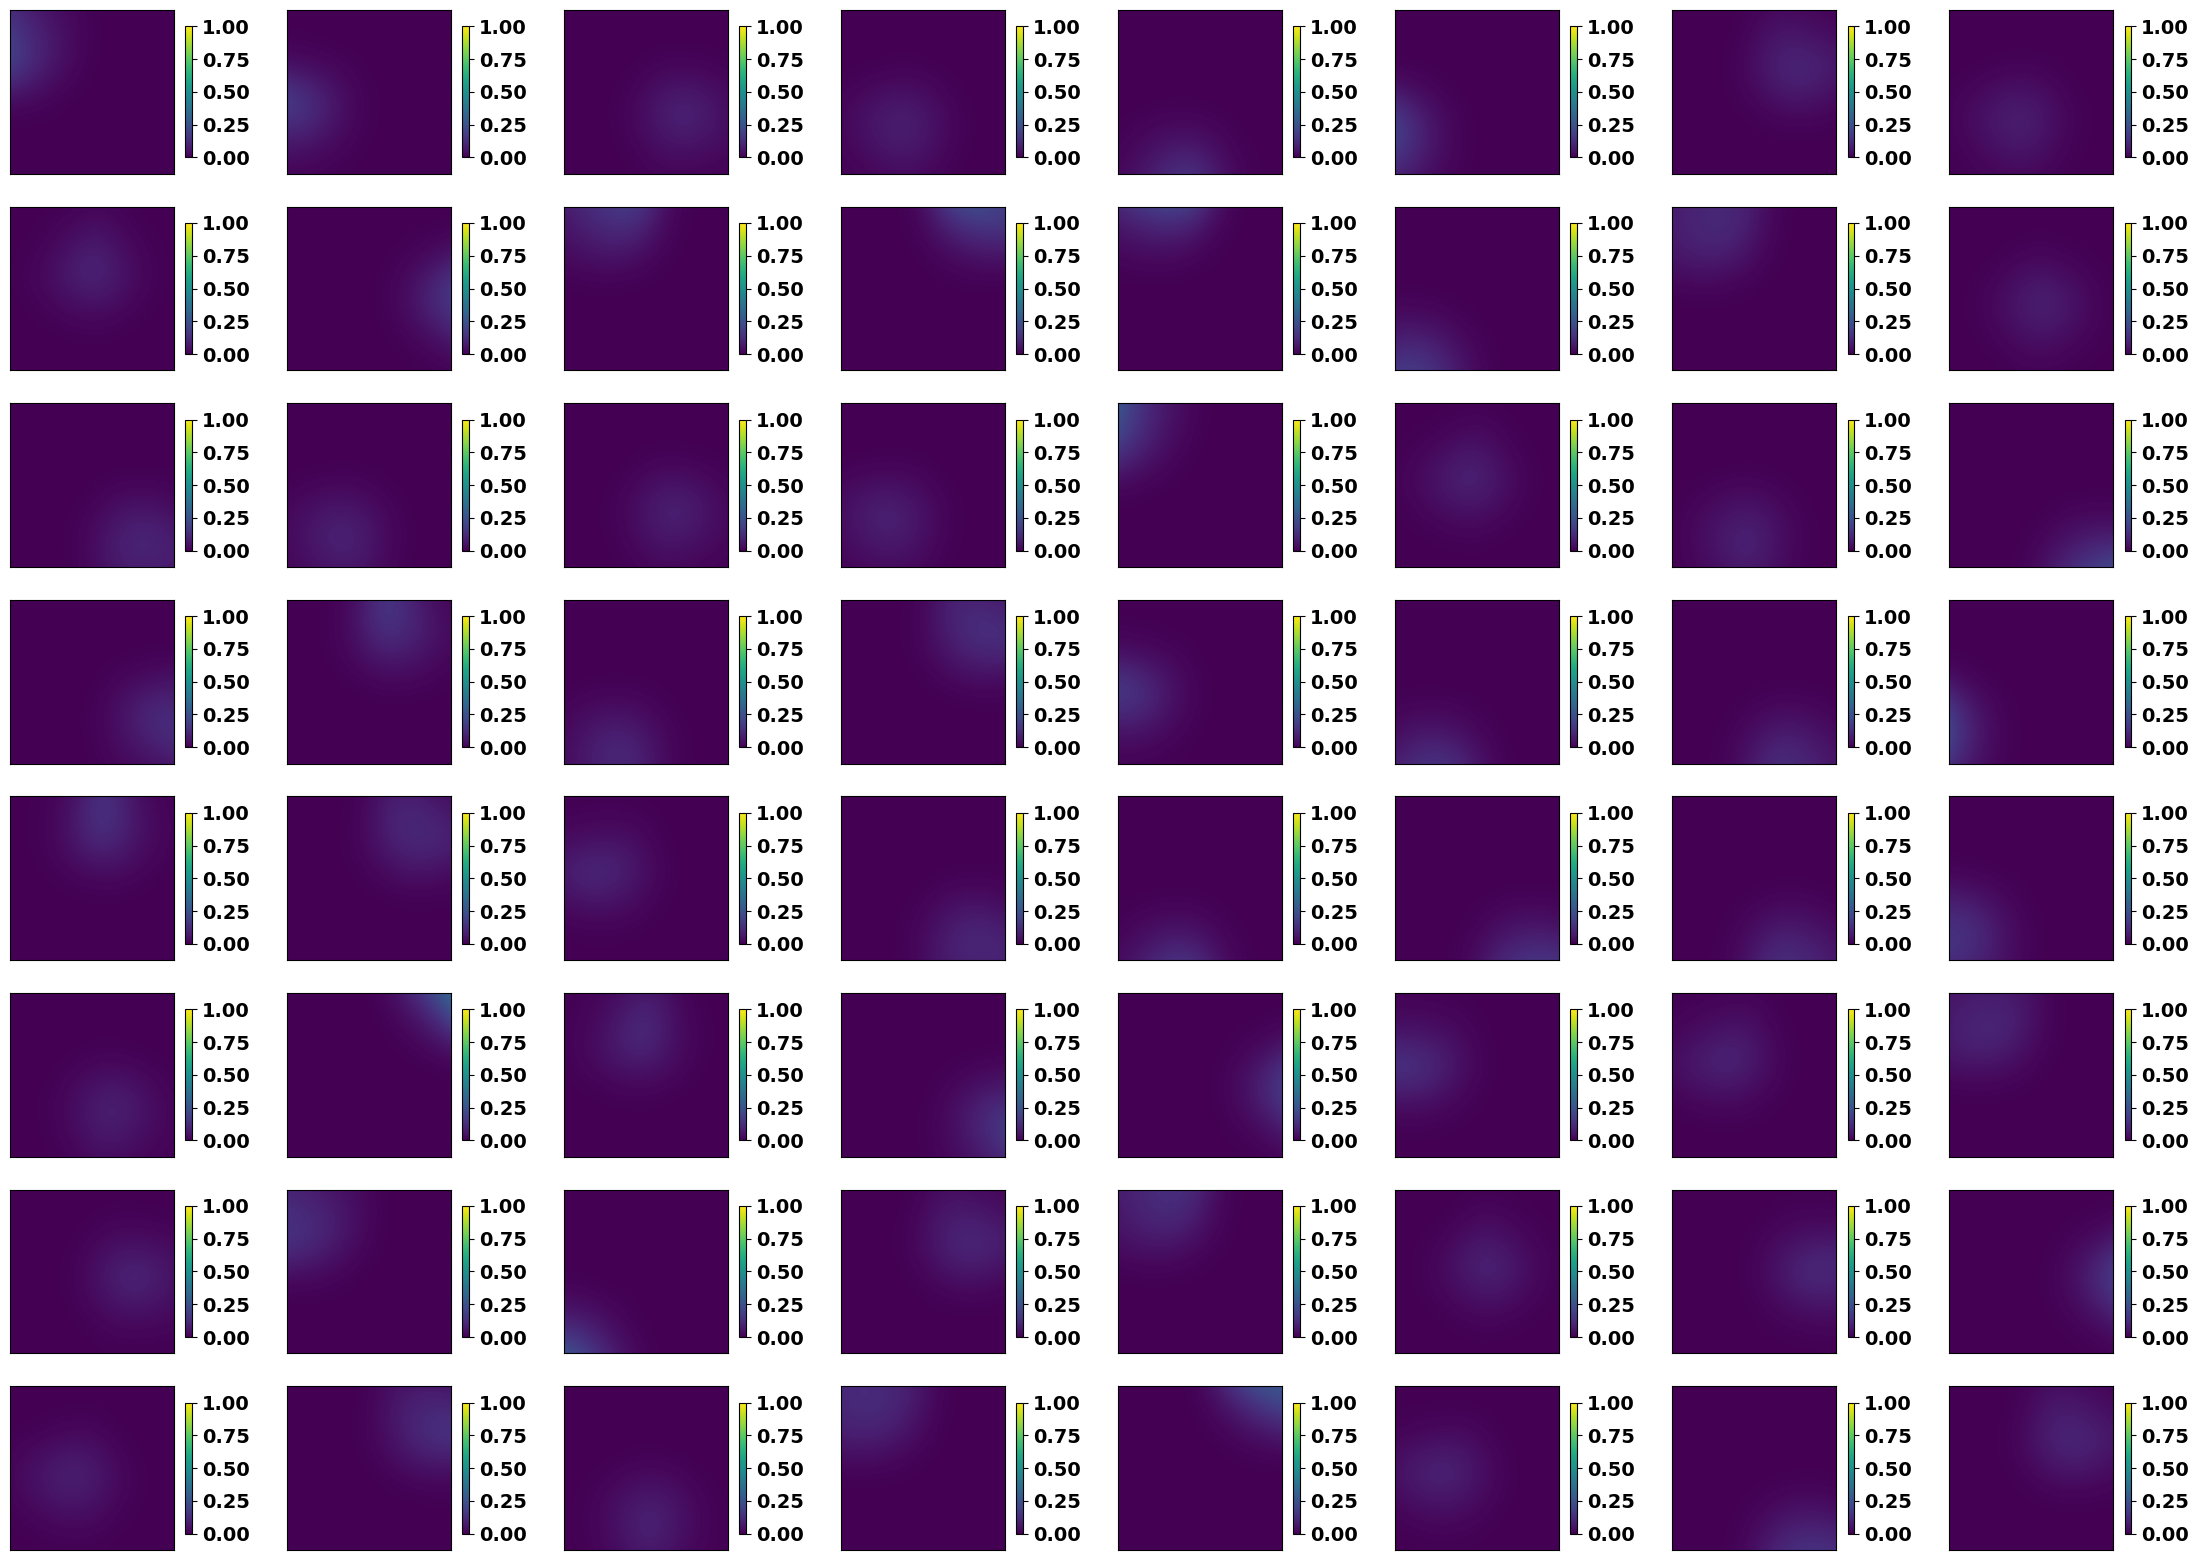

  Epoch      0 | Loss: 2.017545e-01


**--- Epoch 1000: Visualizing Partitions ---**

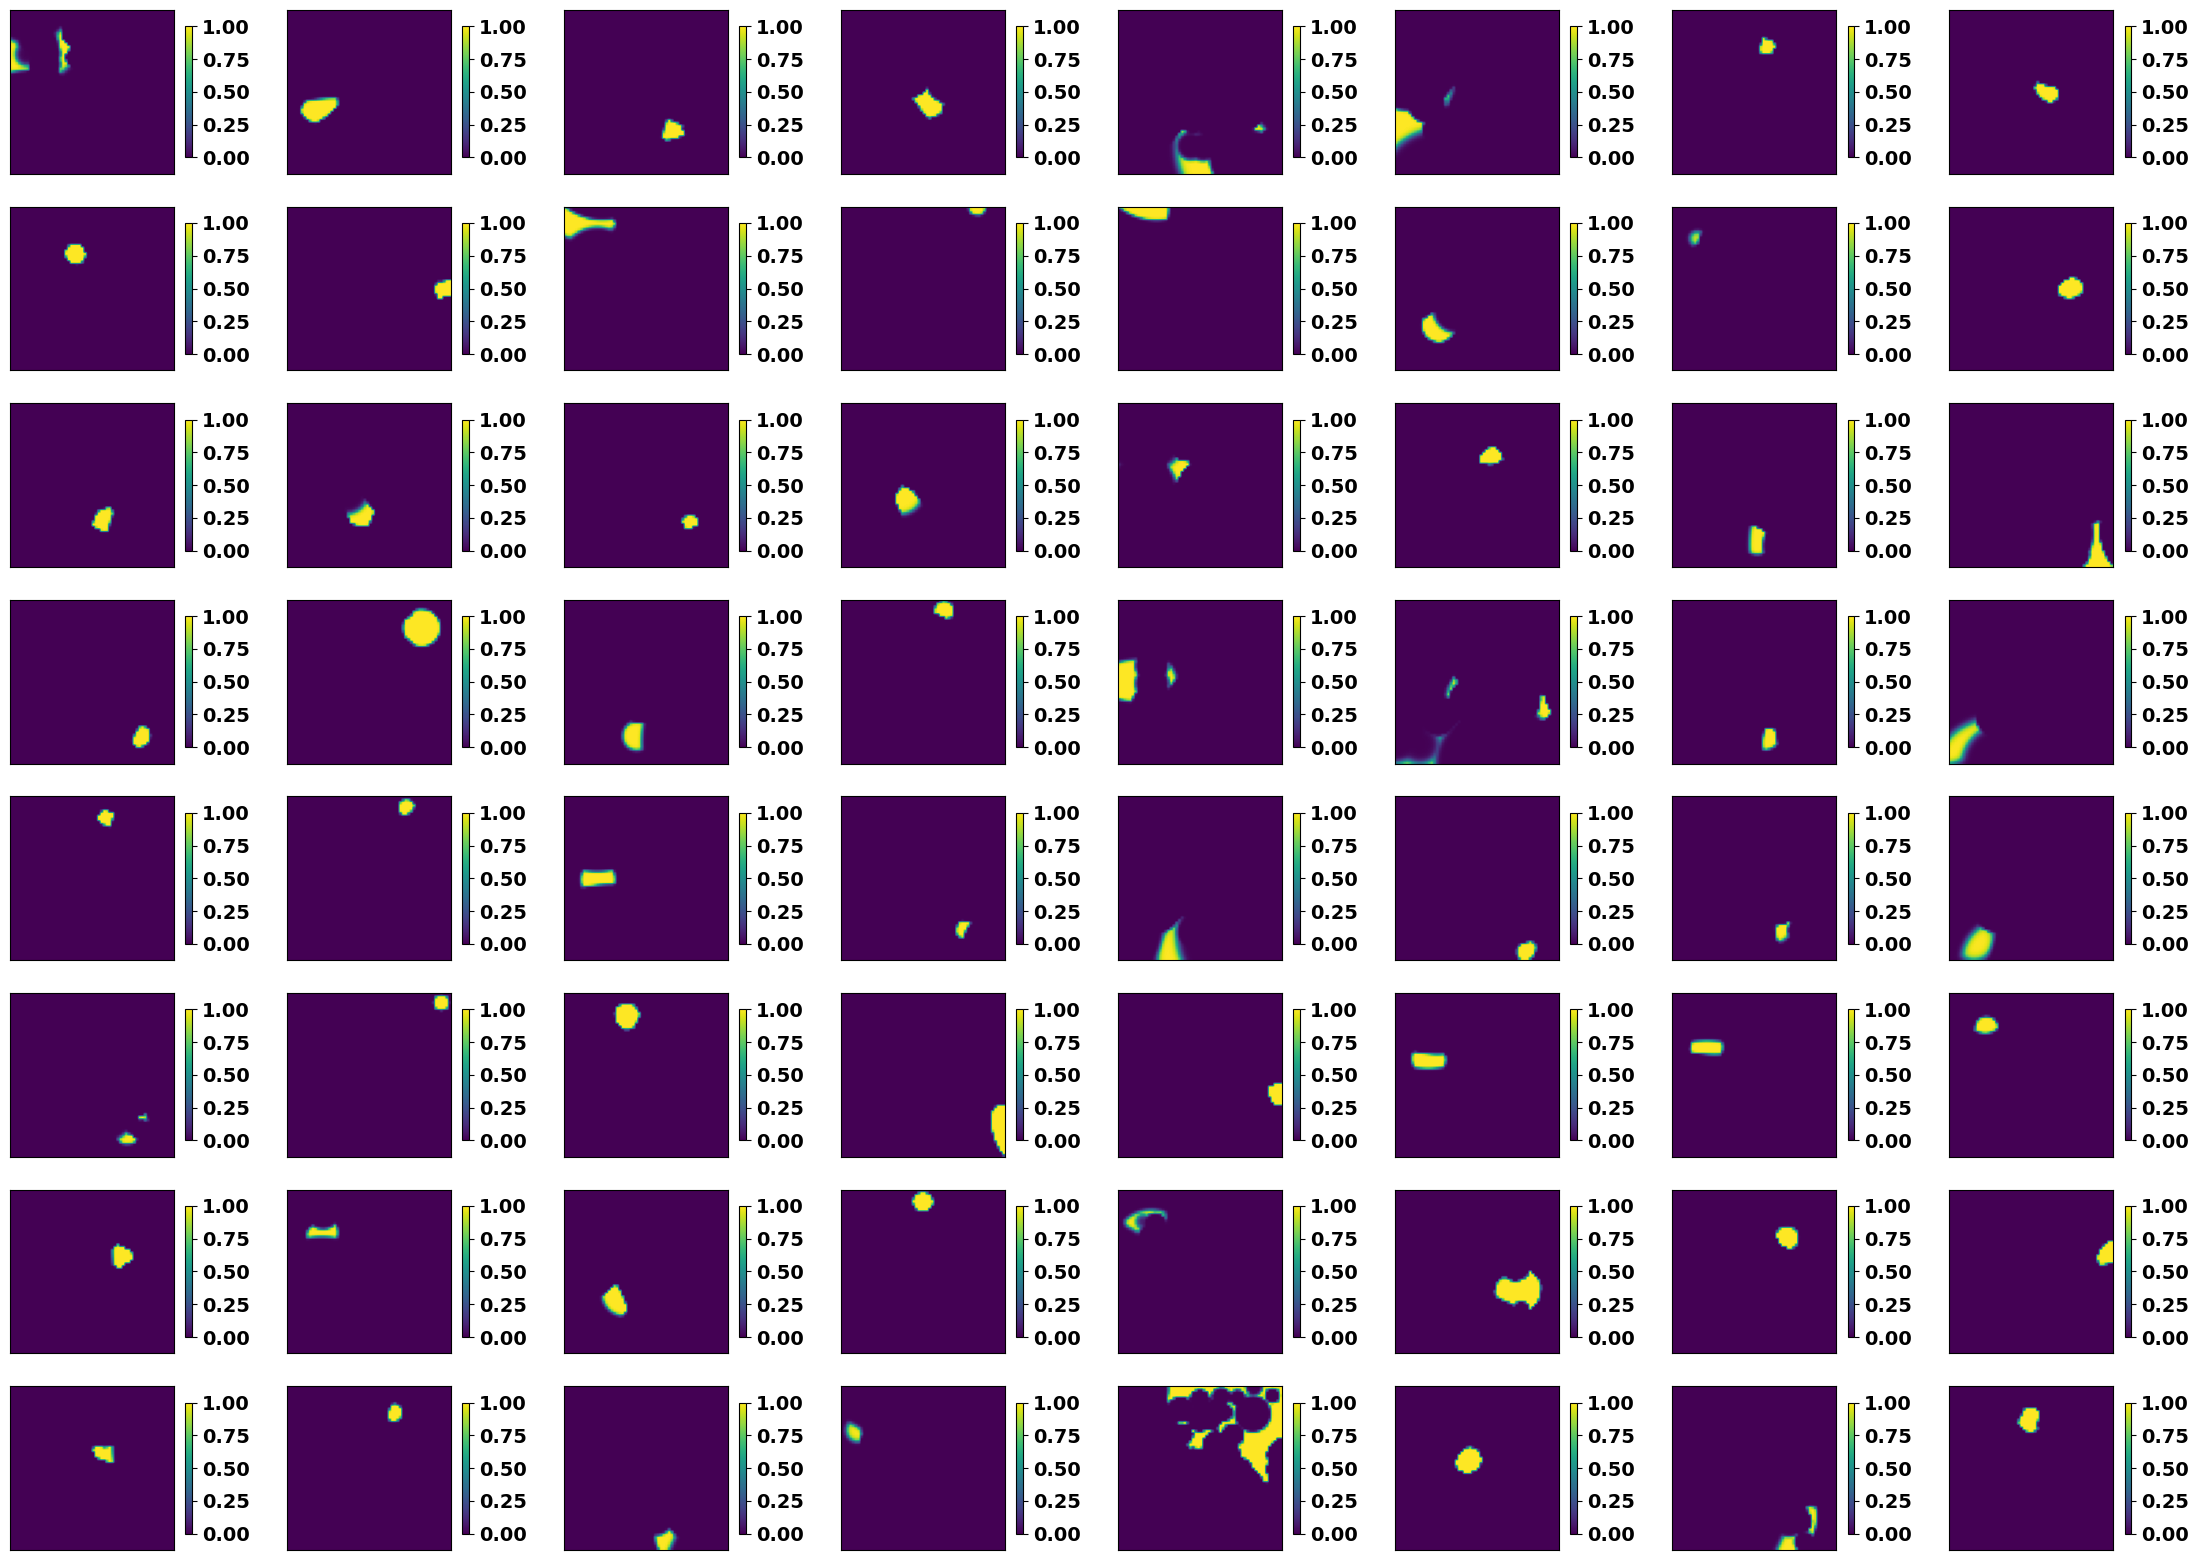

  Epoch   1000 | Loss: 4.549895e-02


**--- Epoch 2000: Visualizing Partitions ---**

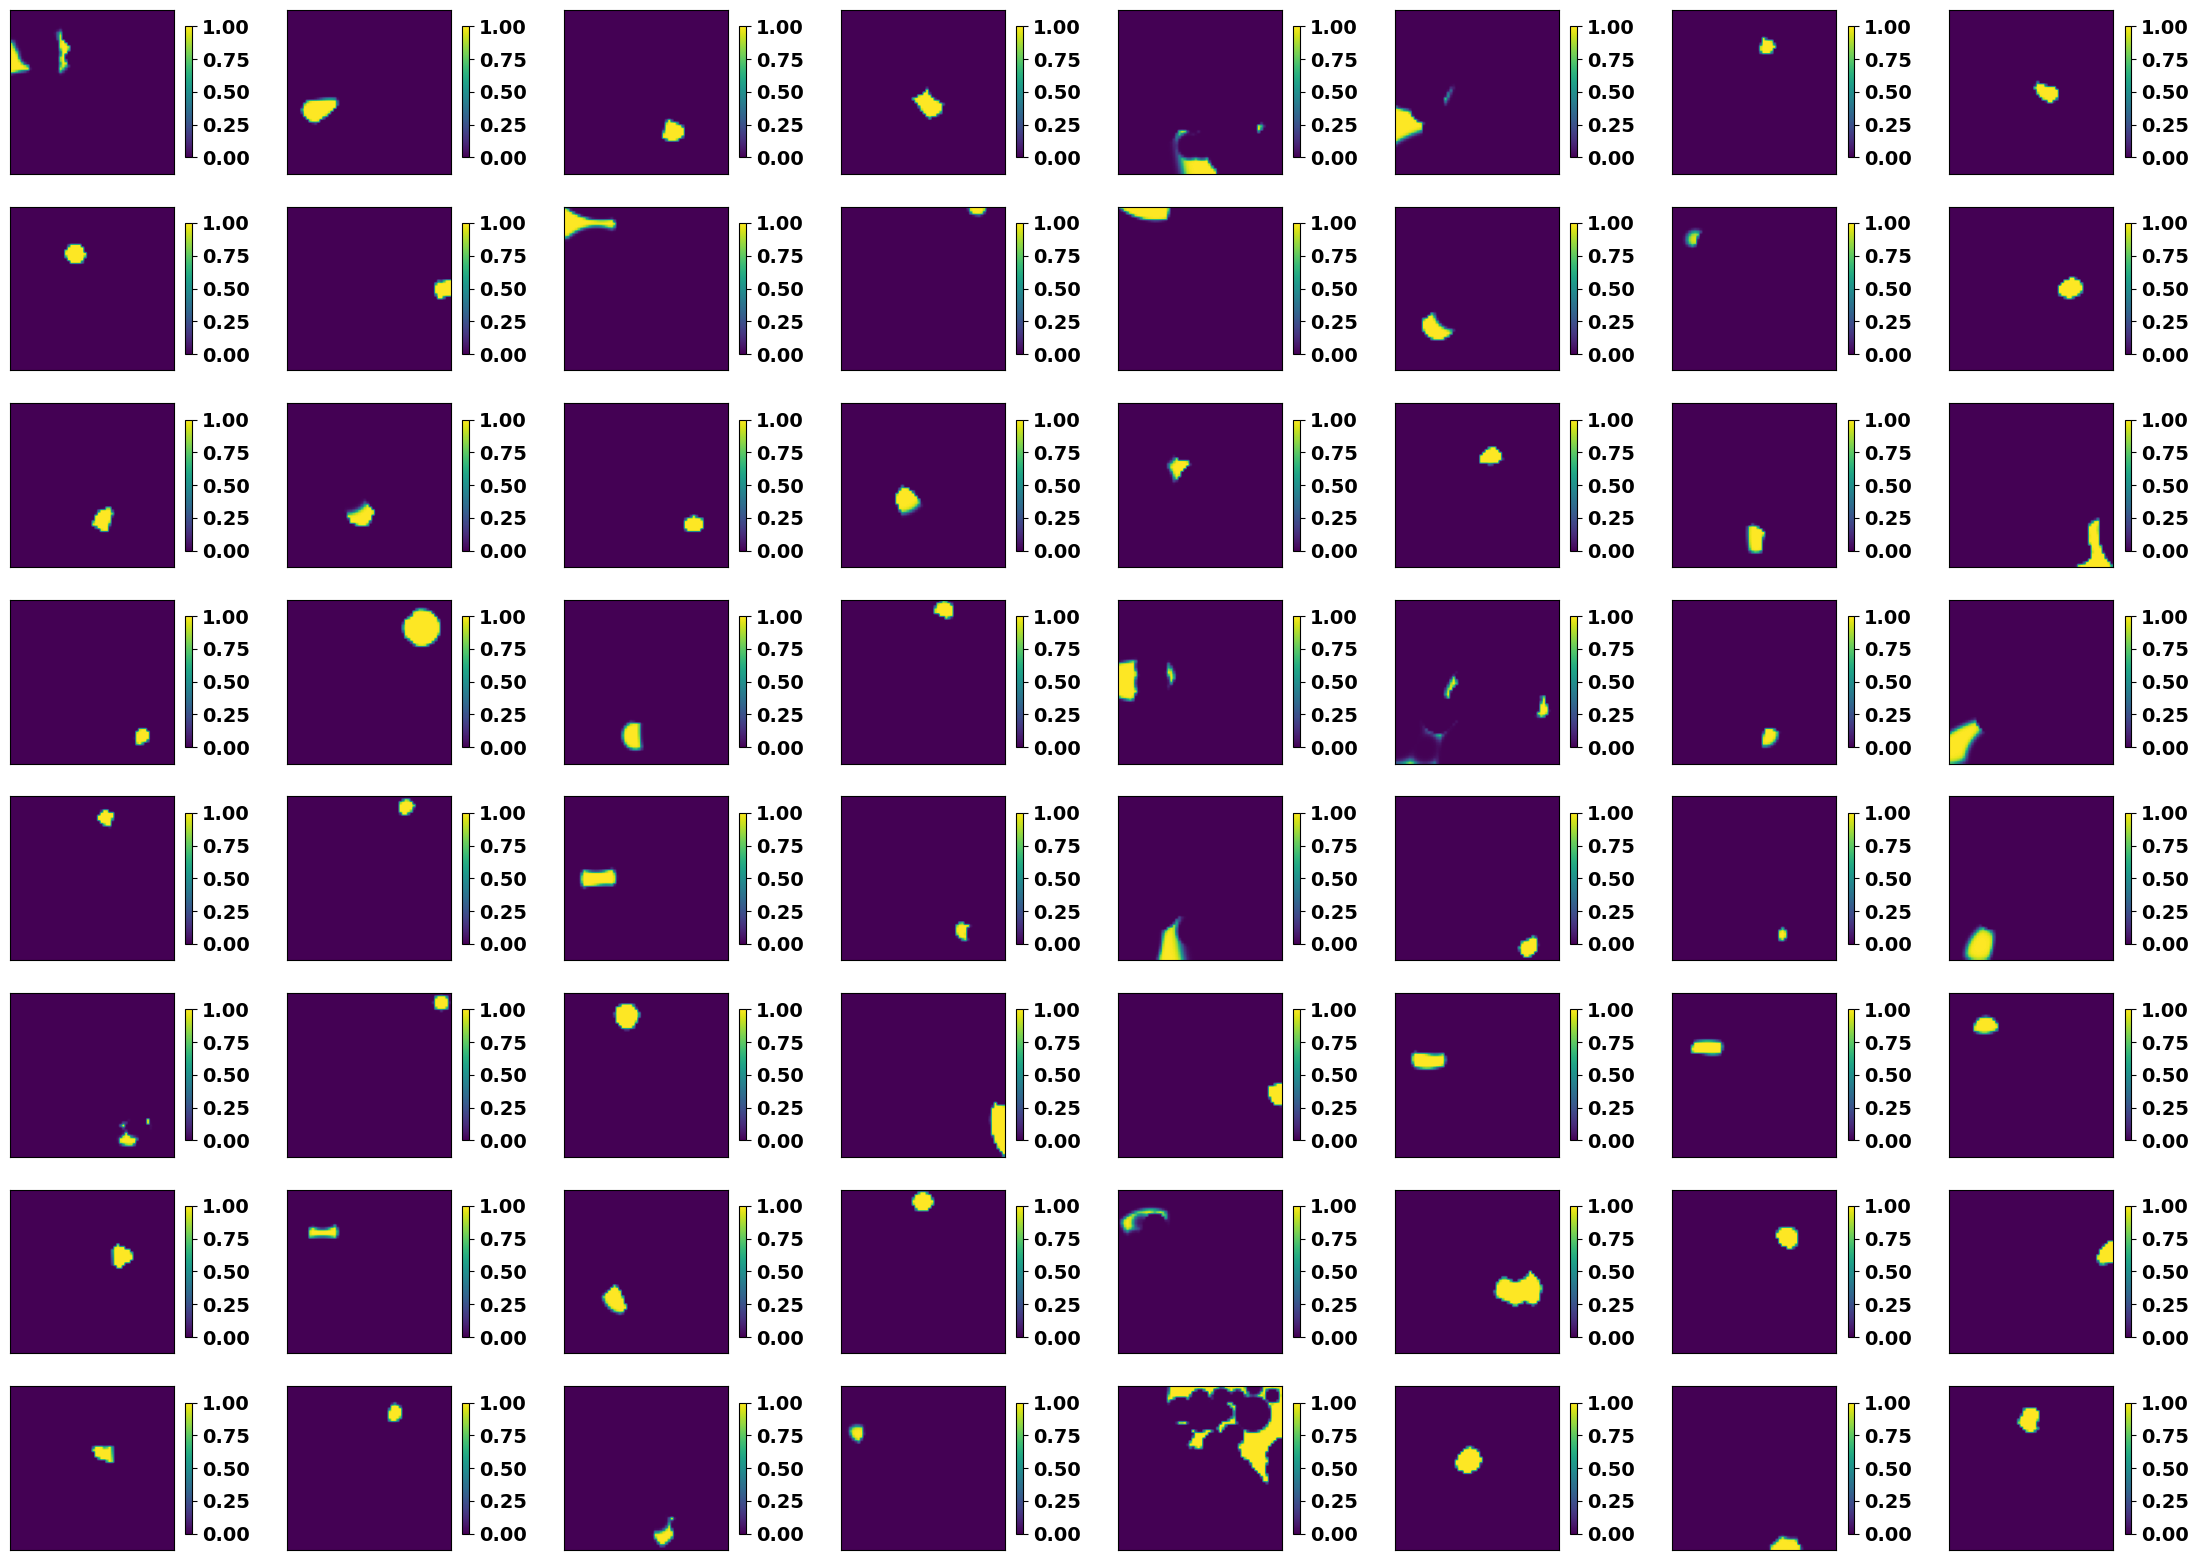

  Epoch   2000 | Loss: 4.506322e-02


KeyboardInterrupt: 

In [13]:
NET_TAG = "rbf"
DIM = 2
EPOCHS = 10000
N_EXPERTS = 64
VIZ_INTERVAL = 1000
POLY_DEGREE = 2
# --- Hyperparameters to Tune ---
LEARNING_RATE = 5e-4
LAM_INIT = 0
RHO = 1.0
N_STAG = 200

# --- Run Experiment ---
display(Markdown(f'### 2D {NET_TAG.upper()} Experiment (sin(10πx²)sin(10πy²), degree={POLY_DEGREE})'))

# 1. Data and Model Setup
n_points_per_axis = 60
xs = jnp.linspace(0, 1, n_points_per_axis)
xx, yy = jnp.meshgrid(xs, xs)
x_train = jnp.stack([xx.ravel(), yy.ravel()], axis=-1)
y_train = _sinsq_func_2d(x_train)
net = RBFPOUNet(input_dim=DIM, num_centers=N_EXPERTS, key=key)
params = net.init_params()

# 2. Initial Visualization (Before Training)
display(Markdown(f"**--- Initial Partitions (Epoch 0) ---**"))
fig_initial = viz_partitions(net, params, x_train)
if fig_initial:
    fig_initial.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_{N_EXPERTS}exp_sinsq_initial_partitions.png")
    plt.show(fig_initial)

# 3. Training
lsgd_cfg = LSGDConfig(n_epochs=EPOCHS, viz_interval=VIZ_INTERVAL, lr=LEARNING_RATE,
                      lam_init=LAM_INIT, rho=RHO, n_stag=N_STAG, poly_degree=POLY_DEGREE)
final_params = run_lsgd(net, params, x_train, y_train, lsgd_cfg)

# 4. Final Visualization
display(Markdown(f"**--- Final Result ---**"))

fig_approx = viz_final(net, final_params, x_train, y_train, POLY_DEGREE)
if fig_approx:
    fig_approx.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_{N_EXPERTS}exp_sinsq_final_approx.png")
    plt.show(fig_approx)
    
fig_part = viz_partitions(net, final_params, x_train)
if fig_part:
    fig_part.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_{N_EXPERTS}exp_sinsq_final_partitions.png")
    plt.show(fig_part)

### 2D MLP Experiment (sin(2πx)sin(2πy), degree=2)

**--- Initial Partitions (Epoch 0) ---**

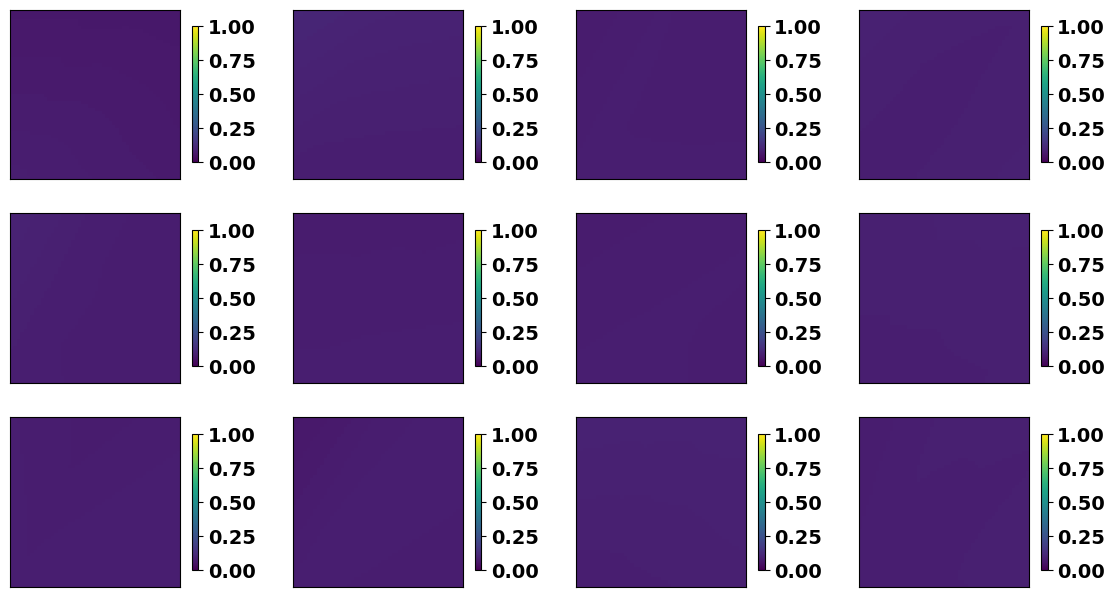

  Epoch      0 | Loss: 2.025320e-01
  Epoch    500 | Loss: 1.631093e-01
  Epoch   1000 | Loss: 1.617855e-01
  Epoch   1500 | Loss: 1.606527e-01
  Epoch   2000 | Loss: 1.598646e-01


**--- Epoch 2500: Visualizing Partitions ---**

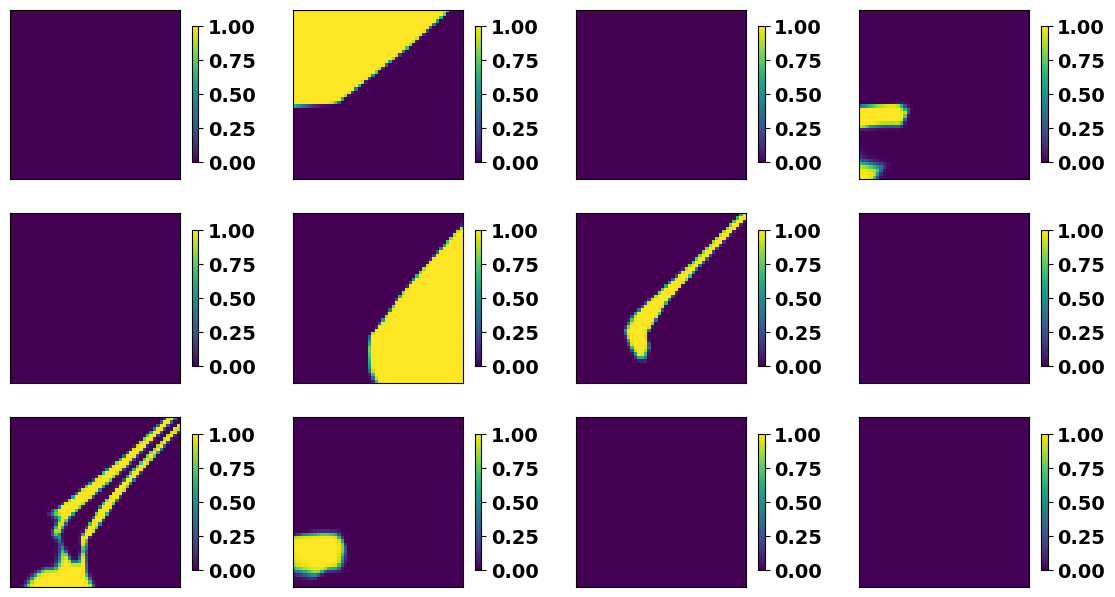

  Epoch   2500 | Loss: 1.597698e-01
  Epoch   3000 | Loss: 1.596603e-01
  Epoch   3500 | Loss: 1.595847e-01
  Epoch   4000 | Loss: 1.594827e-01
  Epoch   4500 | Loss: 1.595466e-01


**--- Final Result ---**

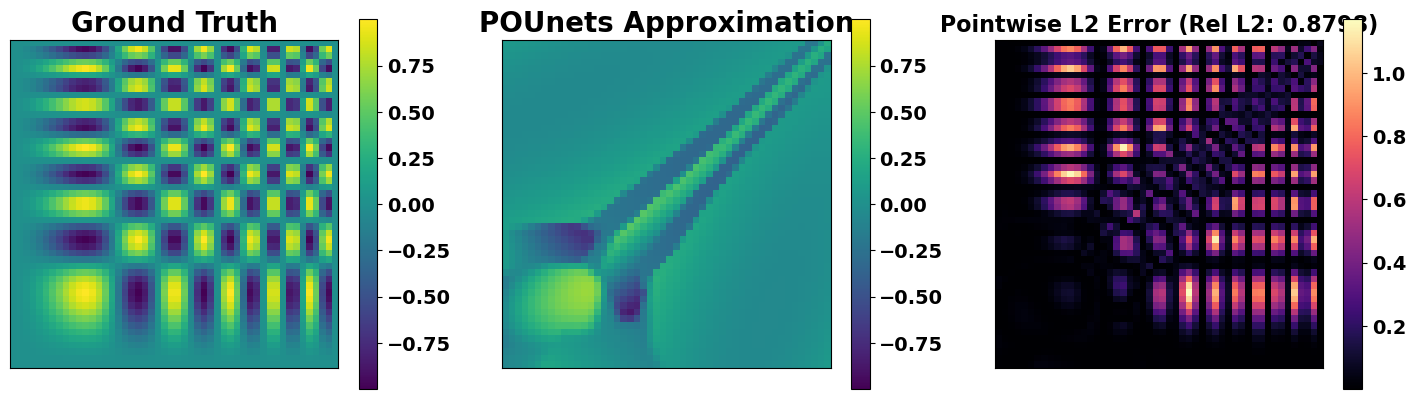

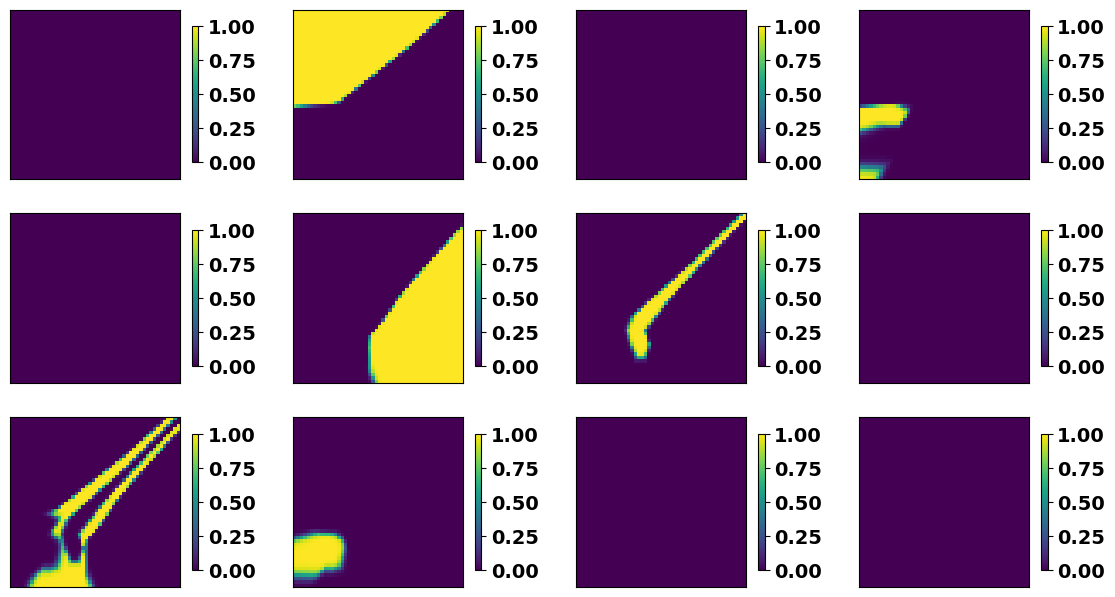

In [ ]:
NET_TAG = "mlp"
DIM = 2
EPOCHS = 5000
N_EXPERTS = 12
VIZ_INTERVAL = 2500
POLY_DEGREE = 2 # Use 1 for linear, 2 for quadratic

HIDDEN_LAYERS = (16,16)

LEARNING_RATE = 0.01
LAM_INIT = 0.1
RHO = 0.99
N_STAG = 100

display(Markdown(f'### 2D {NET_TAG.upper()} Experiment (sin(2πx)sin(2πy), degree={POLY_DEGREE})'))


n_points_per_axis = 50
xs = jnp.linspace(0, 1, n_points_per_axis)
xx, yy = jnp.meshgrid(xs, xs)
x_train = jnp.stack([xx.ravel(), yy.ravel()], axis=-1)
y_train = _sinsq_func_2d(x_train)
net = MLPPOUNet(input_dim=DIM, num_experts=N_EXPERTS, hidden=HIDDEN_LAYERS, key=key)
params = net.init_params()

display(Markdown(f"**--- Initial Partitions (Epoch 0) ---**"))
xs_viz = jnp.linspace(0, 1, n_points_per_axis)
xx_viz, yy_viz = jnp.meshgrid(xs_viz, xs_viz)
x_viz = jnp.stack([xx_viz.ravel(), yy_viz.ravel()], axis=-1)
fig_initial = viz_partitions(net, params, x_viz)
if fig_initial:
    fig_initial.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_{N_EXPERTS}exp_sinsin_initial_partitions.png")
    plt.show(fig_initial)

lsgd_cfg = LSGDConfig(n_epochs=EPOCHS, viz_interval=VIZ_INTERVAL, lr=LEARNING_RATE,
                      lam_init=LAM_INIT, rho=RHO, n_stag=N_STAG, poly_degree=POLY_DEGREE)
final_params = run_lsgd(net, params, x_train, y_train, lsgd_cfg)

display(Markdown(f"**--- Final Result ---**"))
y_viz = _sinsq_func_2d(x_viz)
fig_approx = viz_final(net, final_params, x_viz, y_viz, POLY_DEGREE)
if fig_approx:
    fig_approx.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_{N_EXPERTS}exp_sinsq_final_approx.png")
    plt.show(fig_approx)
    
fig_part = viz_partitions(net, final_params, x_viz)
if fig_part:
    fig_part.savefig(SAVE_DIR / f"{DIM}d_{NET_TAG}_{N_EXPERTS}exp_sinsq_final_partitions.png")
    plt.show(fig_part)